In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False) #for dark mode

## DATA PREPARATION

In the following project we focused on classification of military vehicle, based on images. Dataset is mixed of https://www.kaggle.com/datasets/antoreepjana/military-tanks-dataset-images - mainly tanks. In our case we focused on using Convolutional Neural Network, and Keras library. Dataset contains 1295 images, in 4 classes (tanks, armored tracked vehicle, armored wheeled vehicle, self-propelled artillery). Classes are not perfectly balanced, but handling with it is part of the problem.

In [2]:
from keras.preprocessing.image import smart_resize
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img


filenames = os.listdir('Data')
categories = []
for filename in filenames:
    category = filename.split(' ')[0]
    if category == 'Tank':
        categories.append(0)
    elif category == 'Tracked':
        categories.append(1)
    elif category == 'Wheeled':
        categories.append(2)
    else: 
        categories.append(3)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

X_list = []
for k in df.filename:
    path = 'Data//'
    img = load_img(path + k)
    img = smart_resize(img, (64, 64))
    array = img_to_array(img)
    array = np.resize(array, (12288,))
    array = array/255
    X_list.append(array)

y = df.category
X = df.filename

X = pd.DataFrame(np.vstack(X_list))

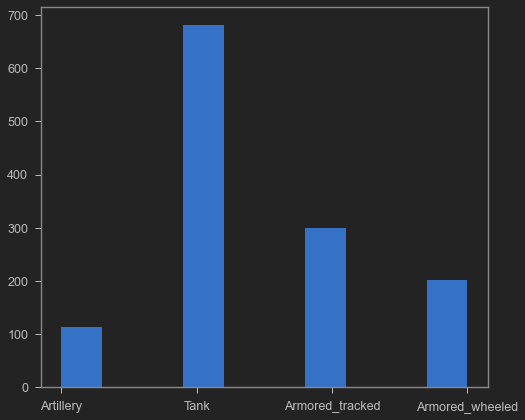

In [3]:
vehicle_dict = {0:'Tank', 1:'Armored_tracked', 2:'Armored_wheeled', 3:'Artillery'}

vehicles = pd.Series(y).map(vehicle_dict)
plt.hist(vehicles)
plt.show()


As we can see, dataset is not perfectly balanced hence, we will use some techniques for handling this problem - oversampling and data augmentation. 

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [5]:
data_to_transform = np.array(X_train)
data_to_transform_test = np.array(X_test)
X_train = np.reshape(data_to_transform, (data_to_transform.shape[0], 64, 64, 3))
X_test = np.reshape(data_to_transform_test, (data_to_transform_test.shape[0], 64, 64, 3))

In [6]:
from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
conf_test = np.argmax(y_test, axis=1)
target_names = ['Tank', 'Armored_tracked', 'Armored_wheeled', 'Artillery']

## MODELS

### 0. BASELINE MODEL - CNN

Baseline model is simple convolutional network, with ReLU activation, valid padding. We use 2 convolutional layers. In case of dense layers we using heuristcs from Matthew Kirk book 'Thoughtful Machine Learning with Python' - 2 dense layers, the second layer is two-thirds the size of the first layer.

In [7]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import MaxPool2D
from keras.layers import Flatten
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score

In [8]:
baseline_model_0 = Sequential()

baseline_model_0.add(Conv2D(64, kernel_size=(4, 4), activation='relu',
                          input_shape=(64, 64, 3)))
baseline_model_0.add(MaxPool2D(pool_size=(2, 2)))

baseline_model_0.add(Conv2D(128, kernel_size=(4, 4), activation='relu'))
baseline_model_0.add(MaxPool2D(pool_size=(2, 2)))

baseline_model_0.add(Flatten())
baseline_model_0.add(Dense(3200, activation='relu'))
baseline_model_0.add(Dropout(0.25))
baseline_model_0.add(Dense(2400, activation='relu'))
baseline_model_0.add(Dropout(0.25))
baseline_model_0.add(Dense(4, activation='softmax'))

es = EarlyStopping(patience=3, verbose=3, monitor='loss')
baseline_model_0.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

baseline_model_0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 61, 61, 64)        3136      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 128)       131200    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 128)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 21632)             0         
                                                                 
 dense (Dense)               (None, 3200)              6

In [9]:
history0 = baseline_model_0.fit(X_train, y_train, epochs=30, batch_size=200, callbacks=es)

Epoch 1/30
6/6 [==============================] - 11s 2s/step - loss: 5.8499 - accuracy: 0.2857
Epoch 2/30
6/6 [==============================] - 11s 2s/step - loss: 1.2449 - accuracy: 0.5261
Epoch 3/30
6/6 [==============================] - 11s 2s/step - loss: 1.2087 - accuracy: 0.5261
Epoch 4/30
6/6 [==============================] - 13s 2s/step - loss: 1.1730 - accuracy: 0.5261
Epoch 5/30
6/6 [==============================] - 11s 2s/step - loss: 1.1649 - accuracy: 0.5261
Epoch 6/30
6/6 [==============================] - 11s 2s/step - loss: 1.1571 - accuracy: 0.5261
Epoch 7/30
6/6 [==============================] - 12s 2s/step - loss: 1.1273 - accuracy: 0.5261
Epoch 8/30
6/6 [==============================] - 12s 2s/step - loss: 1.0970 - accuracy: 0.5280
Epoch 9/30
6/6 [==============================] - 12s 2s/step - loss: 1.0506 - accuracy: 0.5405
Epoch 10/30
6/6 [==============================] - 12s 2s/step - loss: 1.0520 - accuracy: 0.5724
Epoch 11/30
6/6 [======================

dict_keys(['loss', 'accuracy'])


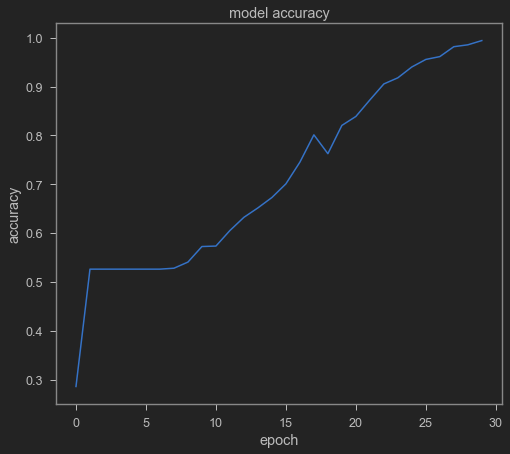

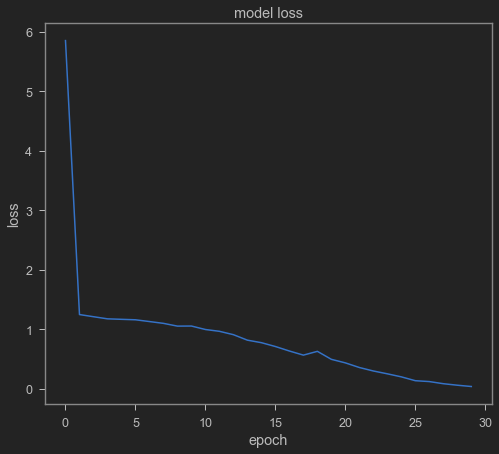

In [10]:
print(history0.history.keys())
# summarize history for accuracy
plt.plot(history0.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()
# summarize history for loss
plt.plot(history0.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

Accuracy: 0.637065637065637
                 precision    recall  f1-score   support

           Tank       0.76      0.76      0.76       136
Armored_tracked       0.49      0.58      0.53        60
Armored_wheeled       0.62      0.57      0.60        40
      Artillery       0.40      0.17      0.24        23

      micro avg       0.65      0.64      0.64       259
      macro avg       0.57      0.52      0.53       259
   weighted avg       0.64      0.64      0.64       259
    samples avg       0.64      0.64      0.64       259



C:\Users\PC\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


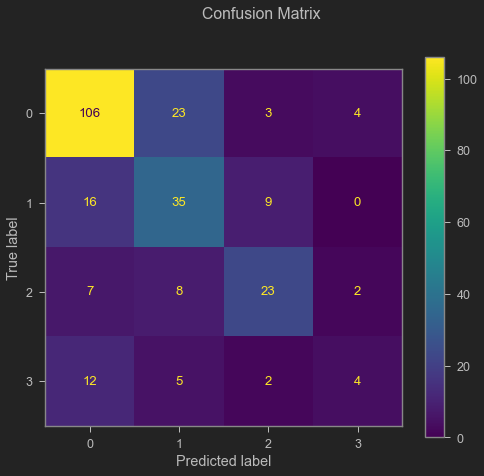

In [11]:
y_pred = baseline_model_0.predict(X_test).round()

print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred, target_names=target_names))

bm_0_acc_score = accuracy_score(y_test, y_pred)

conf_pred = np.argmax(y_pred, axis=1)
disp = ConfusionMatrixDisplay.from_predictions(conf_test, conf_pred)
disp.figure_.suptitle("Confusion Matrix")

plt.show()

### 1. IMPROVED MODEL - more parameters by same padding

We improved baseline model - adding more parameters by changing padding technique.

In [12]:
baseline_model_1 = Sequential()

baseline_model_1.add(Conv2D(64, kernel_size=(4, 4), activation='relu',
                          input_shape=(64, 64, 3), padding='same'))
baseline_model_1.add(MaxPool2D(pool_size=(2, 2)))

baseline_model_1.add(Conv2D(128, kernel_size=(4, 4), activation='relu', padding='same'))
baseline_model_1.add(MaxPool2D(pool_size=(2, 2)))

baseline_model_1.add(Flatten())
baseline_model_1.add(Dense(3200, activation='relu'))
baseline_model_1.add(Dropout(0.25))
baseline_model_1.add(Dense(2400, activation='relu'))
baseline_model_1.add(Dropout(0.25))
baseline_model_1.add(Dense(4, activation='softmax'))

es = EarlyStopping(patience=3, verbose=3, monitor='loss')
baseline_model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

baseline_model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        3136      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 128)       131200    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 128)      0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dense_3 (Dense)             (None, 3200)             

In [13]:
history1 = baseline_model_1.fit(X_train, y_train, epochs=30, batch_size=200, callbacks=es)

Epoch 1/30
6/6 [==============================] - 19s 3s/step - loss: 7.9609 - accuracy: 0.3407
Epoch 2/30
6/6 [==============================] - 18s 3s/step - loss: 1.2710 - accuracy: 0.5261
Epoch 3/30
6/6 [==============================] - 16s 3s/step - loss: 1.1818 - accuracy: 0.5261
Epoch 4/30
6/6 [==============================] - 17s 3s/step - loss: 1.1673 - accuracy: 0.5261
Epoch 5/30
6/6 [==============================] - 19s 3s/step - loss: 1.1674 - accuracy: 0.5261
Epoch 6/30
6/6 [==============================] - 17s 3s/step - loss: 1.1420 - accuracy: 0.5261
Epoch 7/30
6/6 [==============================] - 17s 3s/step - loss: 1.2306 - accuracy: 0.5261
Epoch 8/30
6/6 [==============================] - 16s 3s/step - loss: 1.1250 - accuracy: 0.5261
Epoch 9/30
6/6 [==============================] - 16s 3s/step - loss: 1.0812 - accuracy: 0.5261
Epoch 10/30
6/6 [==============================] - 17s 3s/step - loss: 1.0101 - accuracy: 0.5541
Epoch 11/30
6/6 [======================

dict_keys(['loss', 'accuracy'])


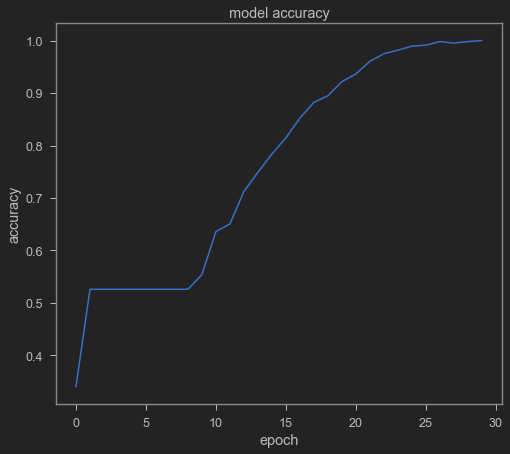

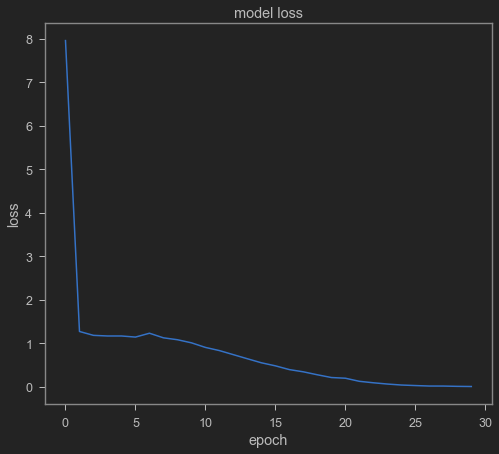

In [14]:
print(history1.history.keys())
# summarize history for accuracy
plt.plot(history1.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()
# summarize history for loss
plt.plot(history1.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

Accuracy: 0.6447876447876448
                 precision    recall  f1-score   support

           Tank       0.75      0.78      0.77       136
Armored_tracked       0.45      0.47      0.46        60
Armored_wheeled       0.57      0.62      0.60        40
      Artillery       0.67      0.35      0.46        23

      micro avg       0.64      0.64      0.64       259
      macro avg       0.61      0.55      0.57       259
   weighted avg       0.65      0.64      0.64       259
    samples avg       0.64      0.64      0.64       259



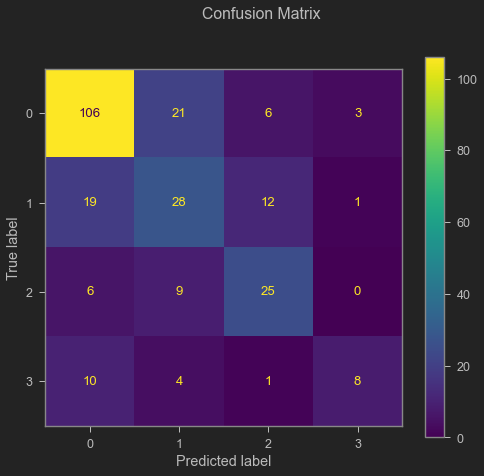

In [15]:
y_pred = baseline_model_1.predict(X_test).round()

print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred, target_names=target_names))

bm_1_acc_score = accuracy_score(y_test, y_pred)

conf_test = np.argmax(y_test, axis=1)
conf_pred = np.argmax(y_pred, axis=1)
disp = ConfusionMatrixDisplay.from_predictions(conf_test, conf_pred)
disp.figure_.suptitle("Confusion Matrix")

plt.show()

### 2. IMPROVED MODEL - add more conv2d layer

In next model we add more convolutional layers for better feature extractions and we return to valid padding.

In [16]:
baseline_model_2 = Sequential()

baseline_model_2.add(Conv2D(64, kernel_size=(4, 4), activation='relu',
                          input_shape=(64, 64, 3), padding='valid'))
baseline_model_2.add(Conv2D(64, kernel_size=(4, 4), activation='relu', padding='valid'))
baseline_model_2.add(MaxPool2D(pool_size=(2, 2)))

baseline_model_2.add(Conv2D(128, kernel_size=(4, 4), activation='relu', padding='valid'))
baseline_model_2.add(Conv2D(128, kernel_size=(4, 4), activation='relu', padding='valid'))
baseline_model_2.add(MaxPool2D(pool_size=(2, 2)))

baseline_model_2.add(Flatten())
baseline_model_2.add(Dense(3200, activation='relu'))
baseline_model_2.add(Dropout(0.25))
baseline_model_2.add(Dense(2400, activation='relu'))
baseline_model_2.add(Dropout(0.25))
baseline_model_2.add(Dense(4, activation='softmax'))

es = EarlyStopping(patience=4, verbose=3, monitor='loss')
baseline_model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

baseline_model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 61, 61, 64)        3136      
                                                                 
 conv2d_5 (Conv2D)           (None, 58, 58, 64)        65600     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 29, 29, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 26, 26, 128)       131200    
                                                                 
 conv2d_7 (Conv2D)           (None, 23, 23, 128)       262272    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 11, 11, 128)      0         
 2D)                                                  

In [17]:
history2 = baseline_model_2.fit(X_train, y_train, epochs=30, batch_size=200, callbacks=es)

Epoch 1/30
6/6 [==============================] - 33s 5s/step - loss: 3.3581 - accuracy: 0.2548
Epoch 2/30
6/6 [==============================] - 32s 5s/step - loss: 1.2032 - accuracy: 0.5203
Epoch 3/30
6/6 [==============================] - 32s 5s/step - loss: 1.2015 - accuracy: 0.5261
Epoch 4/30
6/6 [==============================] - 32s 5s/step - loss: 1.2115 - accuracy: 0.5261
Epoch 5/30
6/6 [==============================] - 32s 5s/step - loss: 1.1737 - accuracy: 0.5261
Epoch 6/30
6/6 [==============================] - 32s 5s/step - loss: 1.1780 - accuracy: 0.5261
Epoch 7/30
6/6 [==============================] - 31s 5s/step - loss: 1.1624 - accuracy: 0.5261
Epoch 8/30
6/6 [==============================] - 31s 5s/step - loss: 1.1514 - accuracy: 0.5261
Epoch 9/30
6/6 [==============================] - 30s 5s/step - loss: 1.1107 - accuracy: 0.5251
Epoch 10/30
6/6 [==============================] - 31s 5s/step - loss: 1.0746 - accuracy: 0.5541
Epoch 11/30
6/6 [======================

dict_keys(['loss', 'accuracy'])


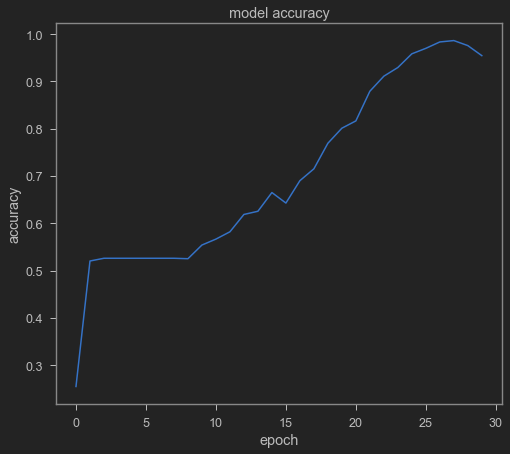

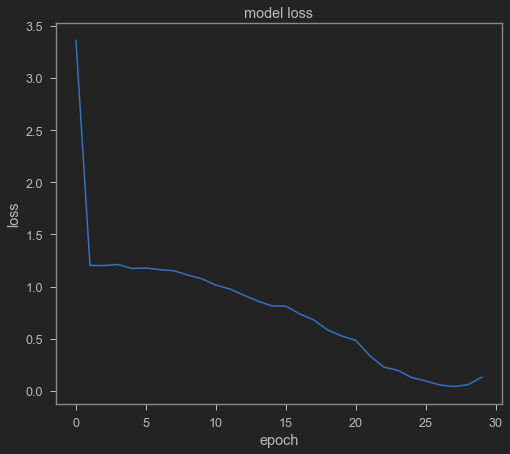

In [18]:
print(history2.history.keys())
# summarize history for accuracy
plt.plot(history2.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()
# summarize history for loss
plt.plot(history2.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

Accuracy: 0.6602316602316602
                 precision    recall  f1-score   support

           Tank       0.75      0.85      0.80       136
Armored_tracked       0.56      0.50      0.53        60
Armored_wheeled       0.62      0.50      0.56        40
      Artillery       0.50      0.22      0.30        23

      micro avg       0.68      0.66      0.67       259
      macro avg       0.61      0.52      0.55       259
   weighted avg       0.67      0.66      0.65       259
    samples avg       0.66      0.66      0.66       259



C:\Users\PC\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


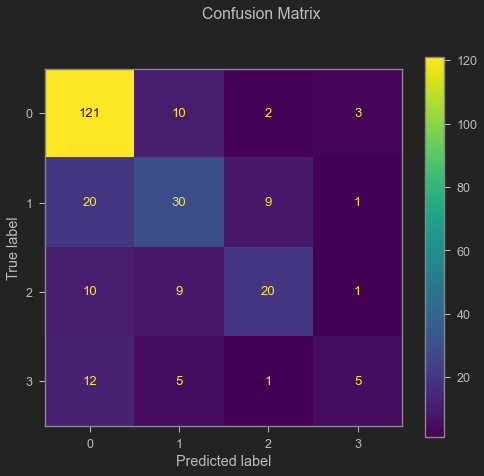

In [19]:
y_pred = baseline_model_2.predict(X_test).round()

print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred, target_names=target_names))

bm_2_acc_score = accuracy_score(y_test, y_pred)

conf_test = np.argmax(y_test, axis=1)
conf_pred = np.argmax(y_pred, axis=1)
disp = ConfusionMatrixDisplay.from_predictions(conf_test, conf_pred)
disp.figure_.suptitle("Confusion Matrix")

plt.show()

### 3. BASELINE MODEL - using oversampling

Imblearn library, can help us for handling imbalanced dataset problem. As we can see in previous steps, precision metric for the least numerous 3 class (with self-propeled artillery images) is low. Over-sampling/Under-sampling is the simplest solution. Idea of over-sampling is supplementing minoroty class with multiple copies of elements. On the other hand under-sampling (cutting majority class) is probably worse in our case because our majority class is relativly small. Mainly problem of over-sampling is high risk of over-fitting our model.

In [20]:
X_train = np.reshape(X_train, (1036, 12288))

In [21]:
from imblearn.over_sampling import RandomOverSampler


ros = RandomOverSampler()
y_train = np.argmax(y_train, axis=1)
X_ros, y_ros = ros.fit_resample(X_train, y_train)
y_ros = np_utils.to_categorical(y_ros)
data_to_transform = np.array(X_ros)
X_ros = np.reshape(data_to_transform, (data_to_transform.shape[0], 64, 64, 3))
y_train = np_utils.to_categorical(y_train)

In [22]:
baseline_model_0_ros = Sequential()

baseline_model_0_ros.add(Conv2D(64, kernel_size=(4, 4), activation='relu',
                          input_shape=(64, 64, 3)))
baseline_model_0_ros.add(MaxPool2D(pool_size=(2, 2)))

baseline_model_0_ros.add(Conv2D(128, kernel_size=(4, 4), activation='relu'))
baseline_model_0_ros.add(MaxPool2D(pool_size=(2, 2)))

baseline_model_0_ros.add(Flatten())
baseline_model_0_ros.add(Dense(3200, activation='relu'))
baseline_model_0_ros.add(Dropout(0.25))
baseline_model_0_ros.add(Dense(2400, activation='relu'))
baseline_model_0_ros.add(Dropout(0.25))
baseline_model_0_ros.add(Dense(4, activation='softmax'))

es = EarlyStopping(patience=3, verbose=3, monitor='loss')
baseline_model_0_ros.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

baseline_model_0_ros.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 61, 61, 64)        3136      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 27, 27, 128)       131200    
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 13, 13, 128)      0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 21632)             0         
                                                                 
 dense_9 (Dense)             (None, 3200)             

In [23]:
history0_ros = baseline_model_0_ros.fit(X_ros, y_ros, epochs=30, batch_size=200, callbacks=es)

Epoch 1/30
11/11 [==============================] - 25s 2s/step - loss: 3.4284 - accuracy: 0.2550
Epoch 2/30
11/11 [==============================] - 24s 2s/step - loss: 1.3564 - accuracy: 0.3023
Epoch 3/30
11/11 [==============================] - 24s 2s/step - loss: 1.2354 - accuracy: 0.4505
Epoch 4/30
11/11 [==============================] - 24s 2s/step - loss: 1.0149 - accuracy: 0.5867
Epoch 5/30
11/11 [==============================] - 24s 2s/step - loss: 0.8402 - accuracy: 0.6674
Epoch 6/30
11/11 [==============================] - 24s 2s/step - loss: 0.6814 - accuracy: 0.7440
Epoch 7/30
11/11 [==============================] - 24s 2s/step - loss: 0.5083 - accuracy: 0.8101
Epoch 8/30
11/11 [==============================] - 24s 2s/step - loss: 0.3962 - accuracy: 0.8573
Epoch 9/30
11/11 [==============================] - 24s 2s/step - loss: 0.2848 - accuracy: 0.9060
Epoch 10/30
11/11 [==============================] - 24s 2s/step - loss: 0.1769 - accuracy: 0.9436
Epoch 11/30
11/11 [

dict_keys(['loss', 'accuracy'])


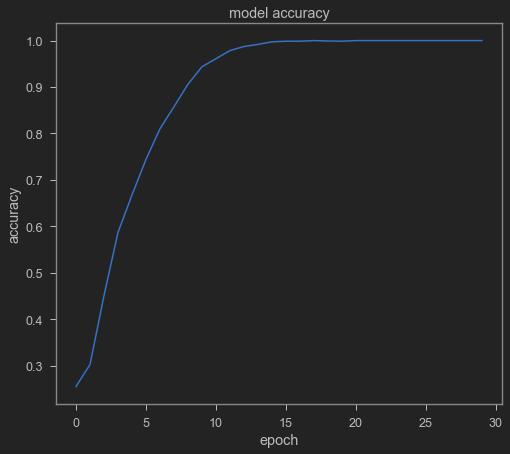

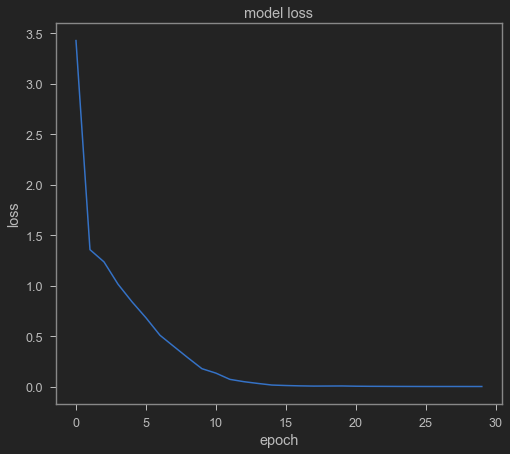

In [24]:
print(history0_ros.history.keys())
# summarize history for accuracy
plt.plot(history0_ros.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()
# summarize history for loss
plt.plot(history0_ros.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

This model is obviously over-fitted.

Accuracy: 0.5945945945945946
                 precision    recall  f1-score   support

           Tank       0.74      0.67      0.70       136
Armored_tracked       0.48      0.52      0.50        60
Armored_wheeled       0.50      0.62      0.56        40
      Artillery       0.41      0.30      0.35        23

      micro avg       0.60      0.59      0.60       259
      macro avg       0.53      0.53      0.53       259
   weighted avg       0.61      0.59      0.60       259
    samples avg       0.59      0.59      0.59       259



C:\Users\PC\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


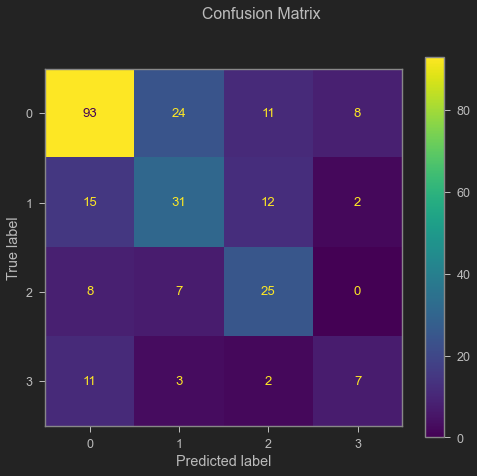

In [25]:
y_pred = baseline_model_0_ros.predict(X_test).round()

print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred, target_names=target_names))

bm_0_ros_acc_score = accuracy_score(y_test, y_pred)

conf_test = np.argmax(y_test, axis=1)
conf_pred = np.argmax(y_pred, axis=1)
disp = ConfusionMatrixDisplay.from_predictions(conf_test, conf_pred)
disp.figure_.suptitle("Confusion Matrix")

plt.show()

As we can see, model with data oversampling is obviously overfited. It is common problem with oversampling. On the other hand, our data set is to small to use undersampling technique.

### 4. BASELINE MODEL - using data augmentation

The data augmentation is better way. We used random horizontal flip and change contrast of image. It is consistent with assumption that model should learn on similar data to test data - so we exclude vertical flip.

In [26]:
from keras.layers import RandomContrast
from keras.layers import RandomFlip

data_augmentation = Sequential([
    RandomFlip("horizontal", input_shape=(64,64,3)),
    RandomContrast(factor=0.1) 
 ])

In [27]:
from keras.layers import Input

input_shape = (64, 64, 3)
baseline_model_0_aug = Sequential([
    data_augmentation,
    Input(shape=(64, 64, 3)),
    Conv2D(64, kernel_size=(4, 4), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Conv2D(128, kernel_size=(4, 4), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Flatten(),
    Dense(2400, activation='relu'),
    Dropout(0.25),
    Dense(1600, activation='relu'),
    Dropout(0.25),
    Dense(4, activation='softmax')]
)

baseline_model_0_aug.compile(optimizer='adam', 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
baseline_model_0_aug.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 64, 64, 3)         0         
                                                                 
 input_1 (InputLayer)        multiple                  0         
                                                                 
 conv2d_10 (Conv2D)          (None, 61, 61, 64)        3136      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 27, 27, 128)       131200    
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 13, 13, 128)      0         
 2D)                                                  

In [28]:
X_train = np.reshape(X_train, (X_train.shape[0], 64, 64, 3))

In [29]:
history0_aug = baseline_model_0_aug.fit(X_train, y_train, epochs=30, batch_size=200, callbacks=es)

Epoch 1/30
6/6 [==============================] - 11s 2s/step - loss: 2.9533 - accuracy: 0.3600
Epoch 2/30
6/6 [==============================] - 11s 2s/step - loss: 1.2710 - accuracy: 0.5261
Epoch 3/30
6/6 [==============================] - 10s 2s/step - loss: 1.2032 - accuracy: 0.5261
Epoch 4/30
6/6 [==============================] - 10s 2s/step - loss: 1.1852 - accuracy: 0.5261
Epoch 5/30
6/6 [==============================] - 10s 2s/step - loss: 1.1668 - accuracy: 0.5261
Epoch 6/30
6/6 [==============================] - 11s 2s/step - loss: 1.1593 - accuracy: 0.5261
Epoch 7/30
6/6 [==============================] - 10s 2s/step - loss: 1.1574 - accuracy: 0.5261
Epoch 8/30
6/6 [==============================] - 10s 2s/step - loss: 1.1189 - accuracy: 0.5261
Epoch 9/30
6/6 [==============================] - 10s 2s/step - loss: 1.0695 - accuracy: 0.5309
Epoch 10/30
6/6 [==============================] - 10s 2s/step - loss: 1.0265 - accuracy: 0.5840
Epoch 11/30
6/6 [======================

dict_keys(['loss', 'accuracy'])


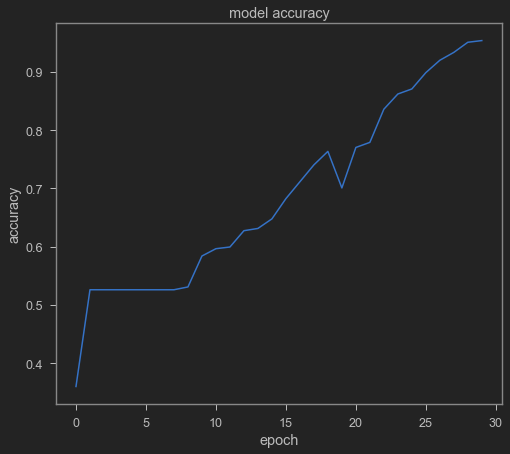

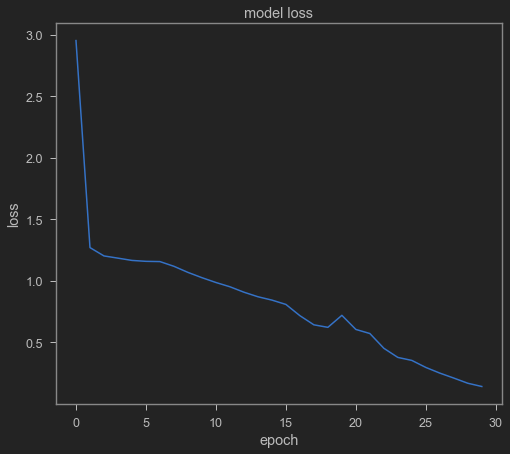

In [30]:
print(history0_aug.history.keys())
# summarize history for accuracy
plt.plot(history0_aug.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()
# summarize history for loss
plt.plot(history0_aug.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

Accuracy: 0.6718146718146718
                 precision    recall  f1-score   support

           Tank       0.75      0.85      0.80       136
Armored_tracked       0.66      0.42      0.51        60
Armored_wheeled       0.60      0.75      0.67        40
      Artillery       0.40      0.17      0.24        23

      micro avg       0.69      0.67      0.68       259
      macro avg       0.60      0.55      0.55       259
   weighted avg       0.68      0.67      0.66       259
    samples avg       0.67      0.67      0.67       259



C:\Users\PC\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


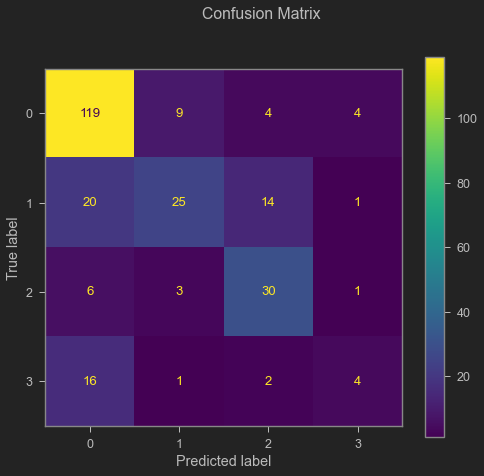

In [31]:
y_pred = baseline_model_0_aug.predict(X_test).round()

print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred, target_names=target_names))

bm_0_aug_acc_score = accuracy_score(y_test, y_pred)

conf_pred = np.argmax(y_pred, axis=1)
disp = ConfusionMatrixDisplay.from_predictions(conf_test, conf_pred)
disp.figure_.suptitle("Confusion Matrix")

plt.show()

### 5. IMPROVED MODEL - using grayscale images

Some problem of CNN arises from selection wrong features. For example if armored tracked vehicle are mainly in desert camouflage, our network learn wrong pattern. Story about problem: https://www.gwern.net/Tanks.

In [32]:
from tensorflow.image import rgb_to_grayscale
from keras.preprocessing.image import array_to_img
from tensorflow.image import rgb_to_grayscale

In [33]:
X_gs_train = []
X_gs_test = []
for k in range(X_train.shape[0]):
    img = array_to_img(X_train[k])
    img = rgb_to_grayscale(img)
    arr = img_to_array(img)
    X_gs_train.append(arr)
for k in range(X_test.shape[0]):
    img = array_to_img(X_train[k])
    img = rgb_to_grayscale(img)
    arr = img_to_array(img)
    X_gs_test.append(arr)
X_gs_train = np.vstack(X_gs_train)
X_gs_test = np.vstack(X_gs_test)

In [34]:
X_gs_train = np.reshape(X_gs_train, (1036, 64, 64, 1))

In [35]:
X_gs_test = np.reshape(X_gs_test, (259, 64, 64, 1))

In [36]:
from keras.layers import BatchNormalization

baseline_model_1_gs = Sequential()

baseline_model_1_gs.add(Conv2D(64, kernel_size=(4, 4), activation='relu',
                          input_shape=(64, 64, 1), padding='same'))
baseline_model_1_gs.add(MaxPool2D(pool_size=(2, 2)))

baseline_model_1_gs.add(Conv2D(128, kernel_size=(4, 4), activation='relu', padding='same'))
baseline_model_1_gs.add(MaxPool2D(pool_size=(2, 2)))

baseline_model_1_gs.add(Flatten())
baseline_model_1_gs.add(Dense(3200, activation='relu'))
baseline_model_1_gs.add(BatchNormalization())
baseline_model_1_gs.add(Dropout(0.25))
baseline_model_1_gs.add(Dense(2400, activation='relu'))
baseline_model_1_gs.add(BatchNormalization())
baseline_model_1_gs.add(Dropout(0.25))
baseline_model_1_gs.add(Dense(4, activation='softmax'))

es = EarlyStopping(patience=3, verbose=3, monitor='loss')
baseline_model_1_gs.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

baseline_model_1_gs.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 64, 64, 64)        1088      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 32, 32, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 32, 32, 128)       131200    
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 16, 16, 128)      0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 32768)             0         
                                                                 
 dense_15 (Dense)            (None, 3200)             

In [37]:
history1_gs = baseline_model_1_gs.fit(X_gs_train, y_train, epochs=30, batch_size=200, callbacks=es)

Epoch 1/30
6/6 [==============================] - 16s 3s/step - loss: 4.8296 - accuracy: 0.3060
Epoch 2/30
6/6 [==============================] - 15s 2s/step - loss: 2.4049 - accuracy: 0.3861
Epoch 3/30
6/6 [==============================] - 15s 2s/step - loss: 1.5119 - accuracy: 0.4778
Epoch 4/30
6/6 [==============================] - 15s 2s/step - loss: 1.2688 - accuracy: 0.5512
Epoch 5/30
6/6 [==============================] - 15s 3s/step - loss: 1.0602 - accuracy: 0.6023
Epoch 6/30
6/6 [==============================] - 15s 2s/step - loss: 0.9653 - accuracy: 0.6342
Epoch 7/30
6/6 [==============================] - 15s 2s/step - loss: 0.8644 - accuracy: 0.6747
Epoch 8/30
6/6 [==============================] - 15s 2s/step - loss: 0.7220 - accuracy: 0.7355
Epoch 9/30
6/6 [==============================] - 15s 2s/step - loss: 0.6393 - accuracy: 0.7770
Epoch 10/30
6/6 [==============================] - 15s 2s/step - loss: 0.5176 - accuracy: 0.8012
Epoch 11/30
6/6 [======================

dict_keys(['loss', 'accuracy'])


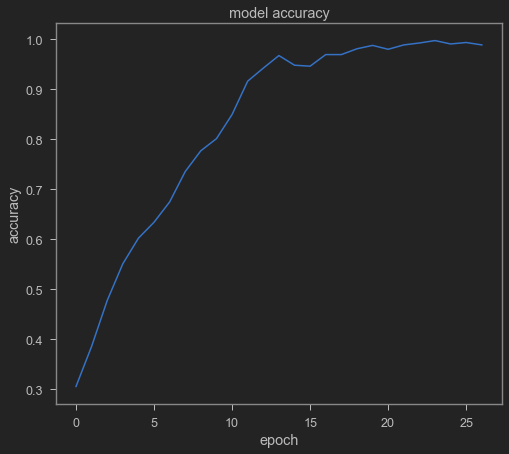

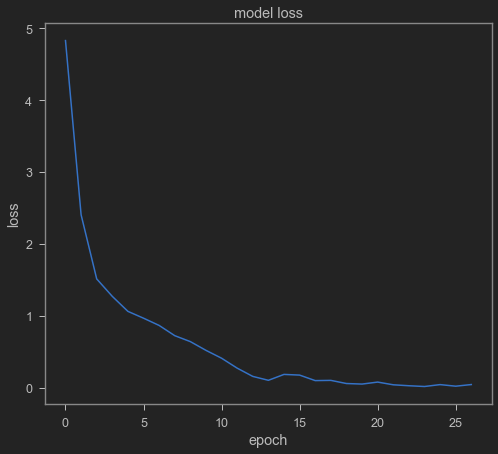

In [38]:
print(history1_gs.history.keys())
# summarize history for accuracy
plt.plot(history1_gs.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()
# summarize history for loss
plt.plot(history1_gs.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

Accuracy: 0.23938223938223938
                 precision    recall  f1-score   support

           Tank       0.56      0.07      0.12       136
Armored_tracked       0.26      0.52      0.35        60
Armored_wheeled       0.21      0.47      0.29        40
      Artillery       0.14      0.13      0.14        23

      micro avg       0.25      0.24      0.25       259
      macro avg       0.29      0.30      0.22       259
   weighted avg       0.40      0.24      0.20       259
    samples avg       0.24      0.24      0.24       259



C:\Users\PC\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


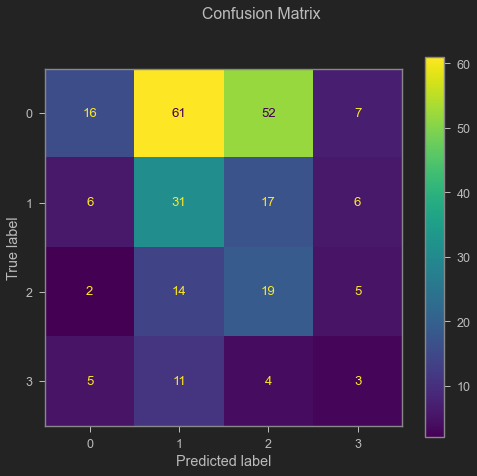

In [39]:
y_pred = baseline_model_1_gs.predict(X_gs_test).round()

print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred, target_names=target_names))

bm_1_gs_acc_score = accuracy_score(y_test, y_pred)

conf_pred = np.argmax(y_pred, axis=1)
disp = ConfusionMatrixDisplay.from_predictions(conf_test, conf_pred)
disp.figure_.suptitle("Confusion Matrix")

plt.show()

### 6. CONCLUSIONS

In [40]:
model_names = ['bm_0','bm_1','bm_2','bm_0_ros','bm_0_aug','bm_1_gs']
model_scores = [bm_0_acc_score, bm_1_acc_score, bm_2_acc_score,
 bm_0_ros_acc_score, bm_0_aug_acc_score, bm_1_gs_acc_score]
score = dict(zip(model_names, model_scores))

In [41]:
df_acc = pd.DataFrame(pd.Series(score))

In [42]:
df_acc.rename({0: 'accuracy'}, axis=1, inplace=True)

In [43]:
df_acc

accuracy
bm_0      0.637066
bm_1      0.644788
bm_2      0.660232
bm_0_ros  0.594595
bm_0_aug  0.671815
bm_1_gs   0.239382

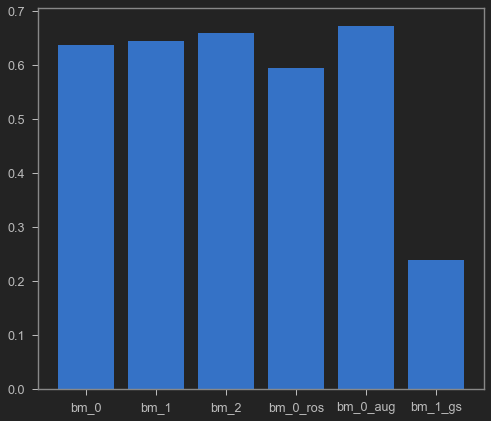

In [44]:
plt.bar(model_names, model_scores)
plt.show()

As we can see, the best result (about 70% accuracy) we achieved by baseline_model_0, supplemented by data augmentation whereas over-sampling is not properly approach - data set is imbalanced, but too small and over-sampling induces over-fitting. Second interesting approach is model bm_2 with additional convolutional layer.

Project has potiential for few next steps - especially combine improved models with data augmentation aproach, and use more data augementation techniques. From last step we have conclusion, that augmentation by grayscale is interesting step.

Next potential step is attempt with "classical" ML algorithm such as SGD.

The last one is using more powerfull CNN, especially from keras.applications, run it with GPU.

In the last step we use best model for visualization with predicted probability.

#### Visualisation predicted probability

In [45]:
y_name = np.argmax(y_test, axis=1)
vehicle_dict = {0:'Tank', 1:'Armored_tracked', 2:'Armored_wheeled', 3:'Artillery'}

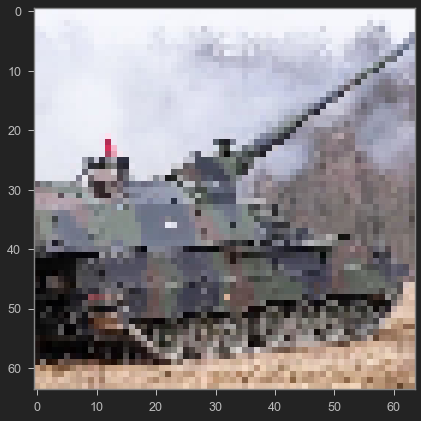

True class: Artillery
Predicted probability:
Tank: 1%, Armored_tracked: 90%, Armored_wheeled: 7%, Artillery: 0% 


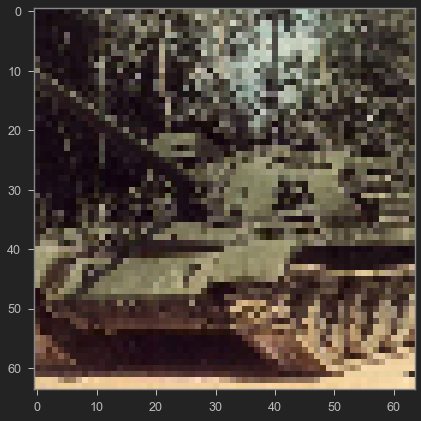

True class: Tank
Predicted probability:
Tank: 70%, Armored_tracked: 5%, Armored_wheeled: 20%, Artillery: 3% 


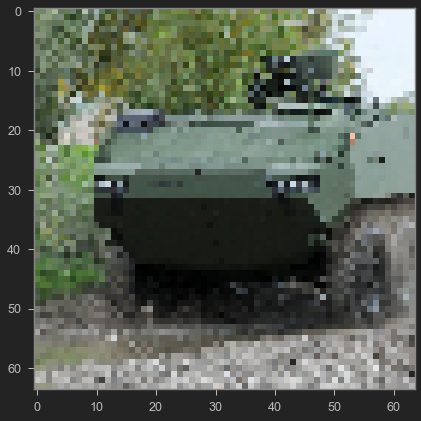

True class: Armored_wheeled
Predicted probability:
Tank: 8%, Armored_tracked: 19%, Armored_wheeled: 72%, Artillery: 0% 


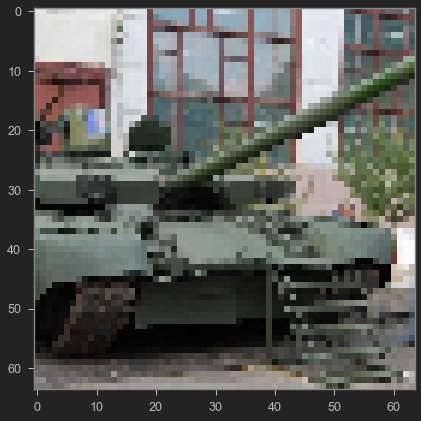

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


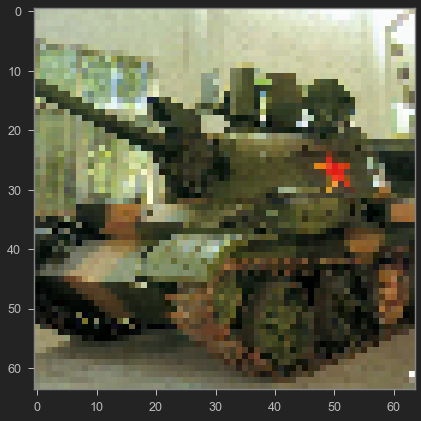

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


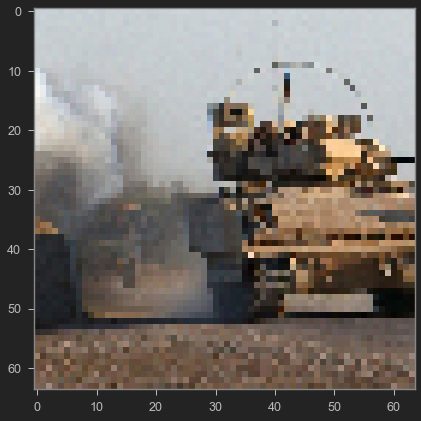

True class: Armored_tracked
Predicted probability:
Tank: 83%, Armored_tracked: 4%, Armored_wheeled: 9%, Artillery: 1% 


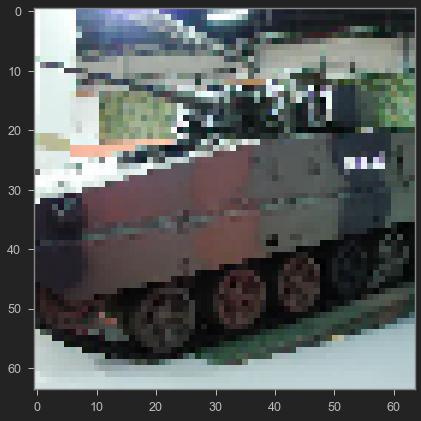

True class: Armored_tracked
Predicted probability:
Tank: 0%, Armored_tracked: 97%, Armored_wheeled: 2%, Artillery: 0% 


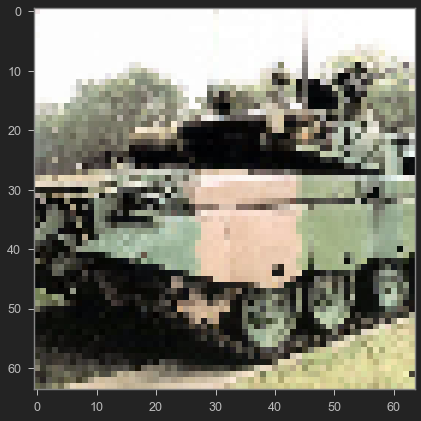

True class: Tank
Predicted probability:
Tank: 100%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


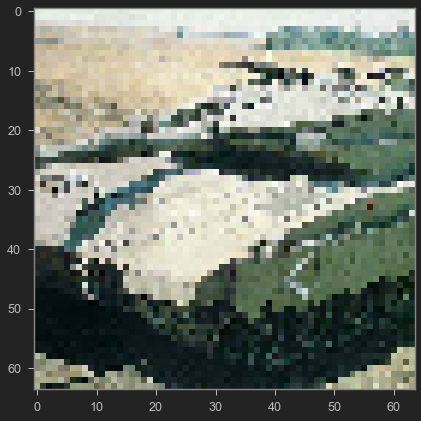

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


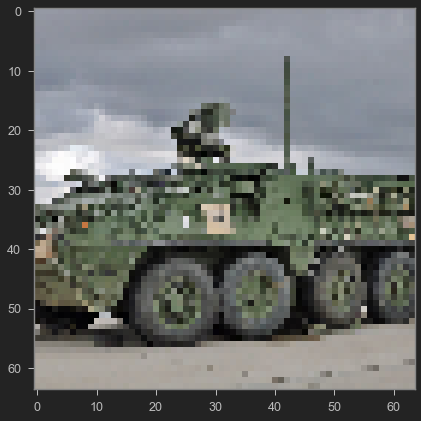

True class: Armored_wheeled
Predicted probability:
Tank: 0%, Armored_tracked: 15%, Armored_wheeled: 83%, Artillery: 0% 


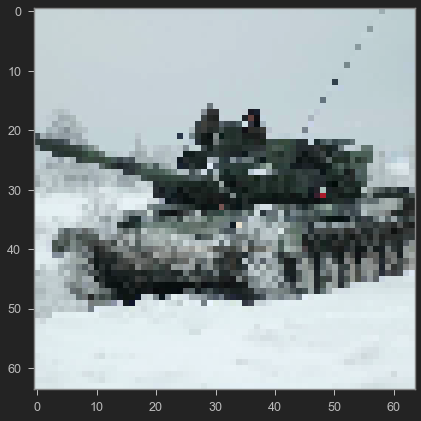

True class: Tank
Predicted probability:
Tank: 20%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 79% 


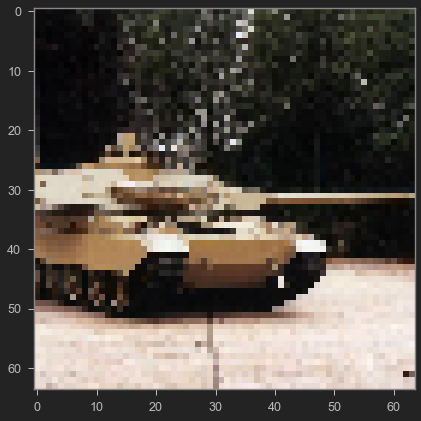

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


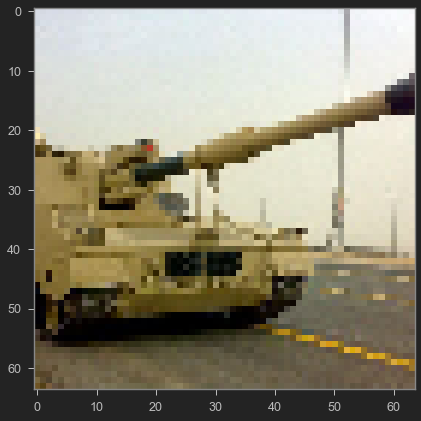

True class: Artillery
Predicted probability:
Tank: 20%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 79% 


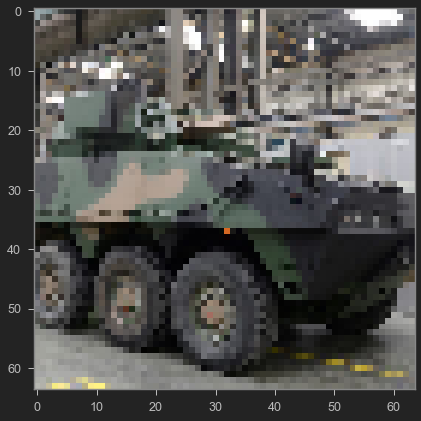

True class: Armored_wheeled
Predicted probability:
Tank: 0%, Armored_tracked: 0%, Armored_wheeled: 99%, Artillery: 0% 


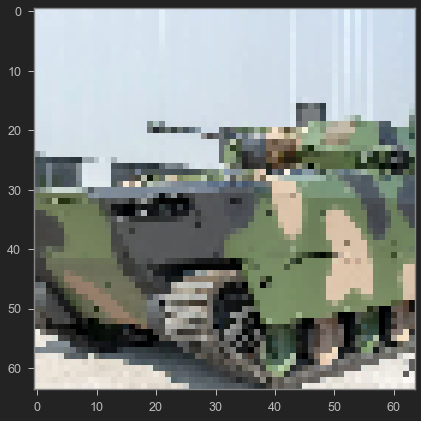

True class: Armored_tracked
Predicted probability:
Tank: 1%, Armored_tracked: 10%, Armored_wheeled: 88%, Artillery: 0% 


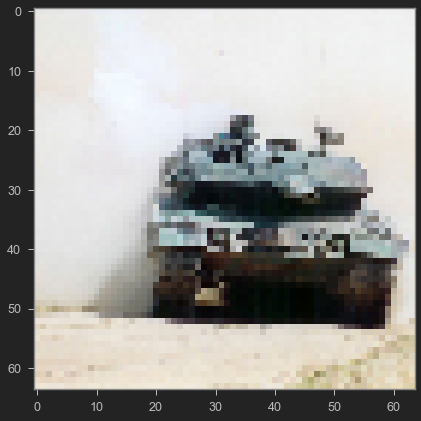

True class: Tank
Predicted probability:
Tank: 96%, Armored_tracked: 3%, Armored_wheeled: 0%, Artillery: 0% 


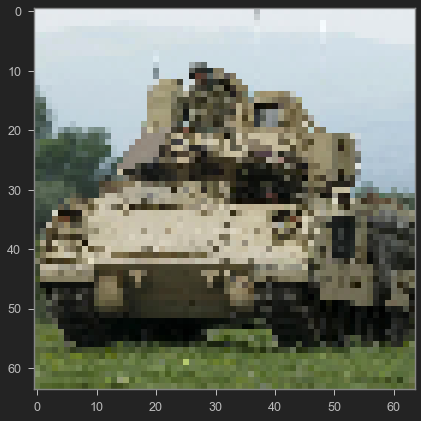

True class: Armored_tracked
Predicted probability:
Tank: 71%, Armored_tracked: 28%, Armored_wheeled: 0%, Artillery: 0% 


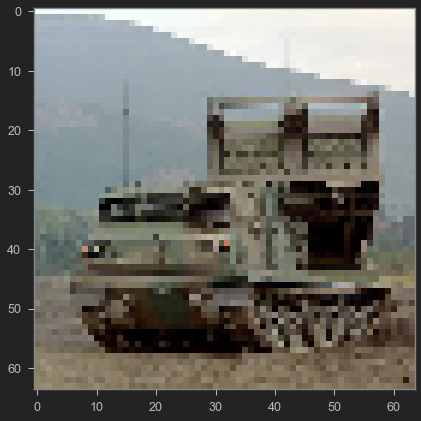

True class: Armored_tracked
Predicted probability:
Tank: 80%, Armored_tracked: 0%, Armored_wheeled: 4%, Artillery: 13% 


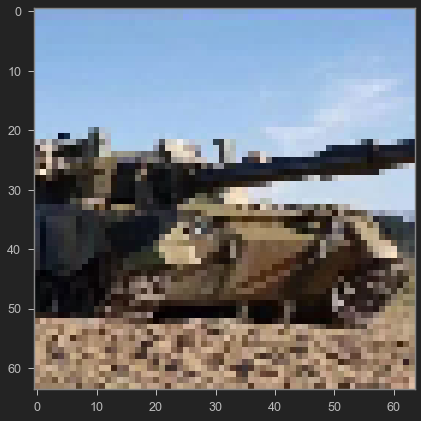

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


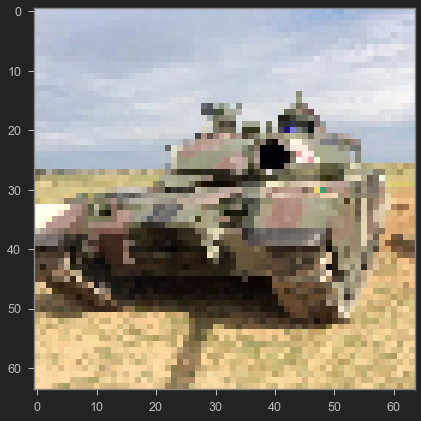

True class: Tank
Predicted probability:
Tank: 97%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 1% 


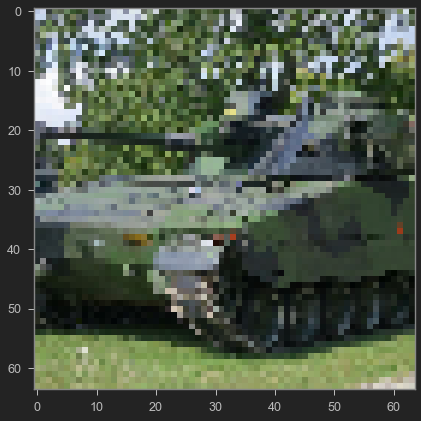

True class: Armored_tracked
Predicted probability:
Tank: 1%, Armored_tracked: 94%, Armored_wheeled: 3%, Artillery: 0% 


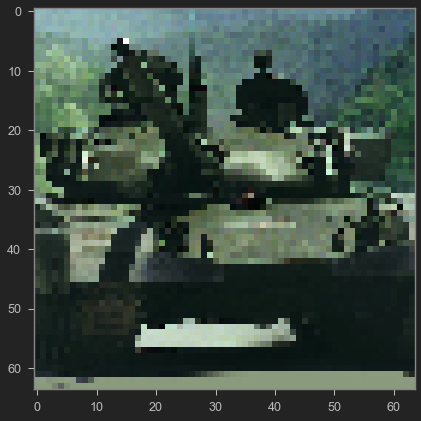

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


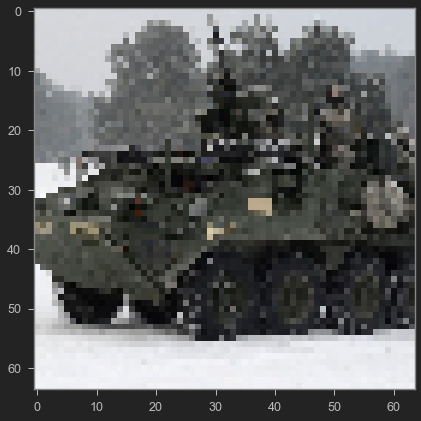

True class: Armored_wheeled
Predicted probability:
Tank: 0%, Armored_tracked: 98%, Armored_wheeled: 1%, Artillery: 0% 


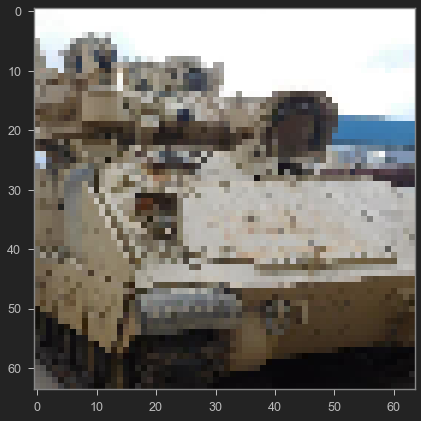

True class: Armored_tracked
Predicted probability:
Tank: 57%, Armored_tracked: 41%, Armored_wheeled: 0%, Artillery: 0% 


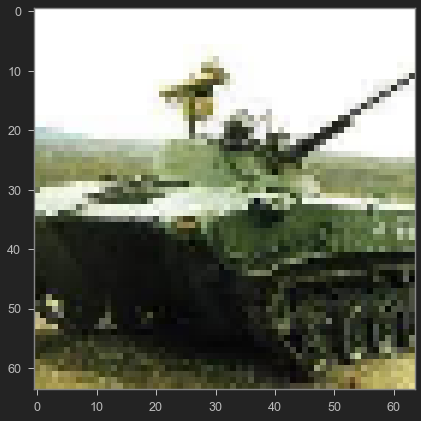

True class: Armored_tracked
Predicted probability:
Tank: 0%, Armored_tracked: 96%, Armored_wheeled: 3%, Artillery: 0% 


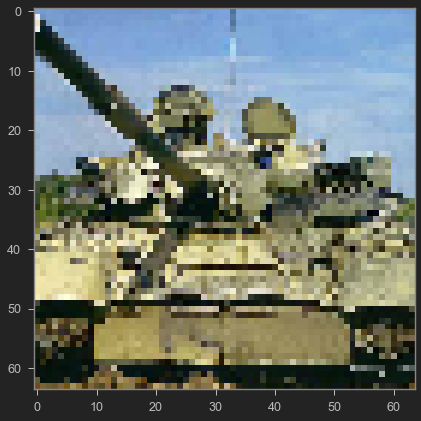

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


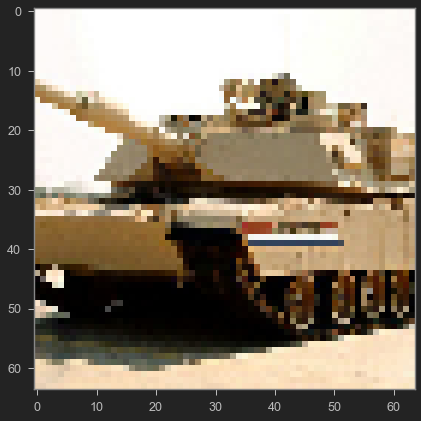

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


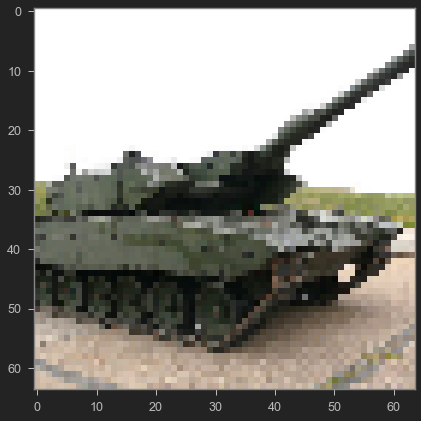

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


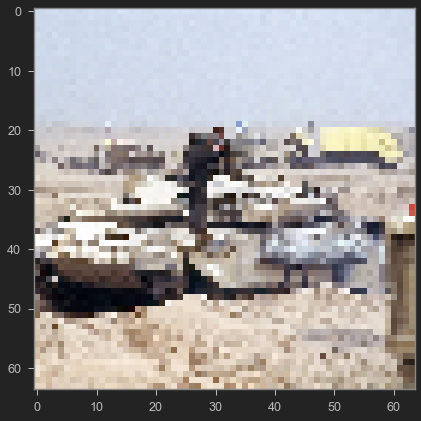

True class: Tank
Predicted probability:
Tank: 93%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 6% 


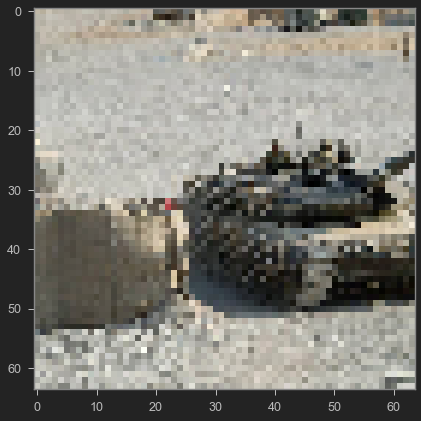

True class: Tank
Predicted probability:
Tank: 98%, Armored_tracked: 1%, Armored_wheeled: 0%, Artillery: 0% 


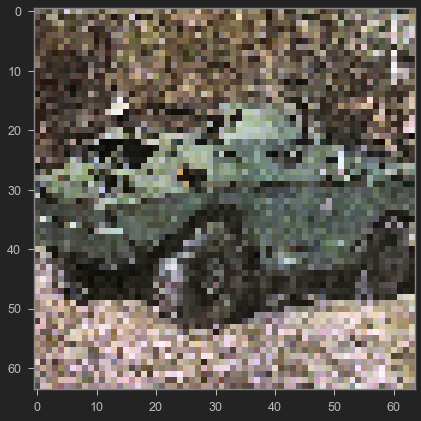

True class: Armored_wheeled
Predicted probability:
Tank: 0%, Armored_tracked: 36%, Armored_wheeled: 63%, Artillery: 0% 


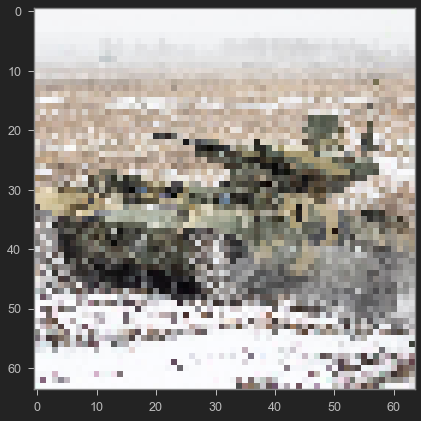

True class: Armored_tracked
Predicted probability:
Tank: 96%, Armored_tracked: 1%, Armored_wheeled: 0%, Artillery: 1% 


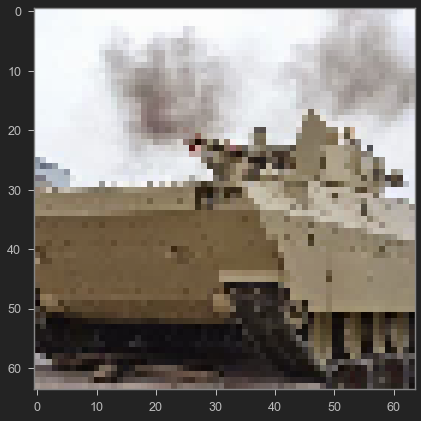

True class: Armored_tracked
Predicted probability:
Tank: 5%, Armored_tracked: 87%, Armored_wheeled: 6%, Artillery: 0% 


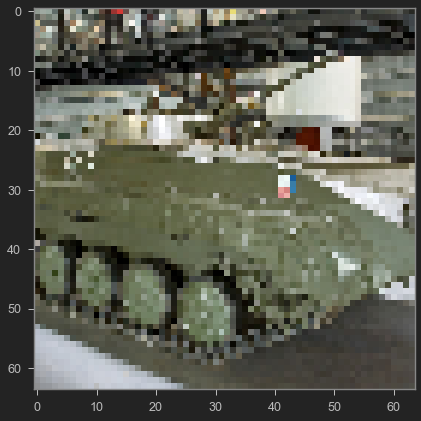

True class: Armored_tracked
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


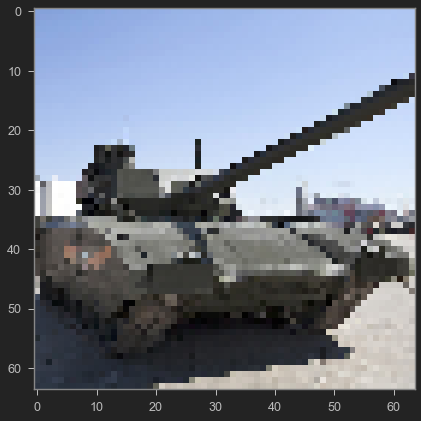

True class: Tank
Predicted probability:
Tank: 64%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 35% 


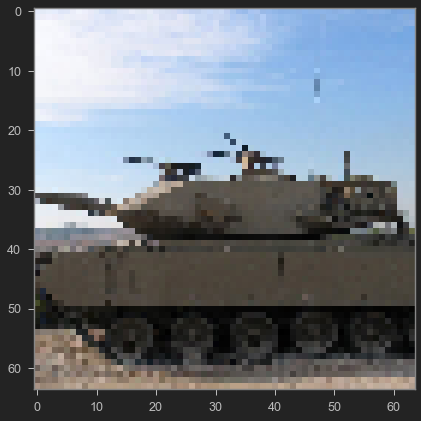

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


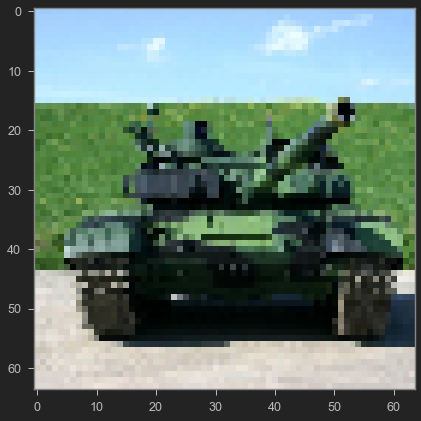

True class: Tank
Predicted probability:
Tank: 68%, Armored_tracked: 31%, Armored_wheeled: 0%, Artillery: 0% 


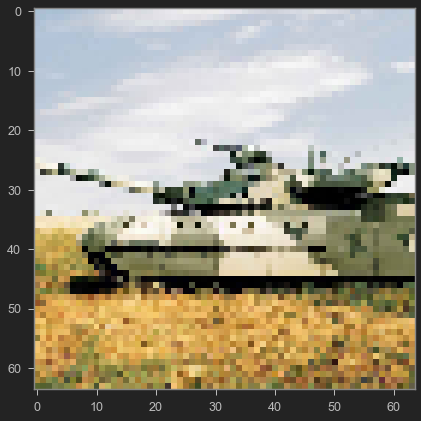

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


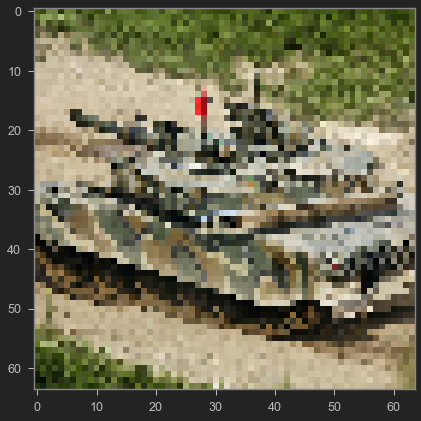

True class: Tank
Predicted probability:
Tank: 93%, Armored_tracked: 1%, Armored_wheeled: 0%, Artillery: 5% 


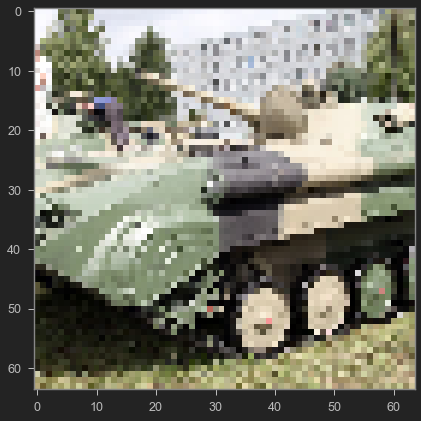

True class: Armored_tracked
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


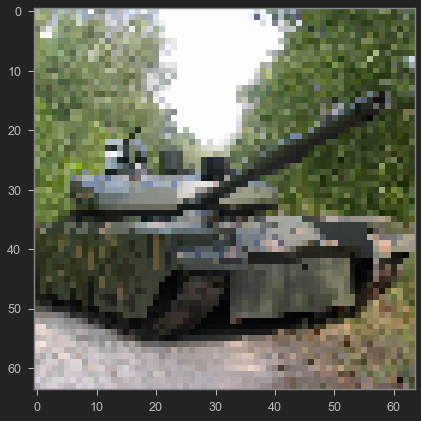

True class: Tank
Predicted probability:
Tank: 88%, Armored_tracked: 7%, Armored_wheeled: 0%, Artillery: 3% 


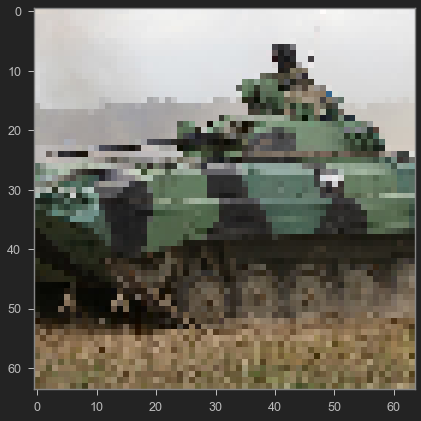

True class: Armored_tracked
Predicted probability:
Tank: 0%, Armored_tracked: 94%, Armored_wheeled: 4%, Artillery: 0% 


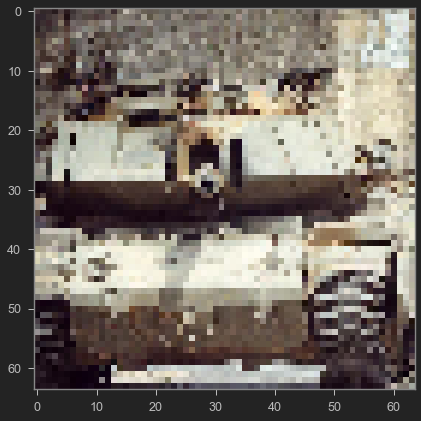

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


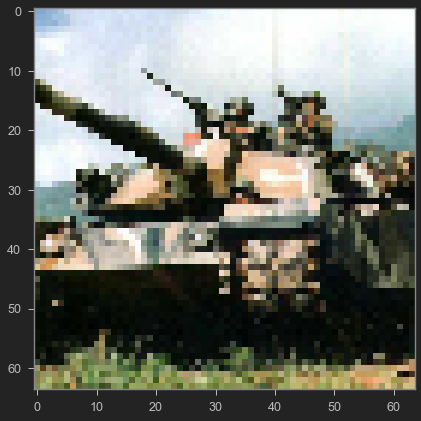

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


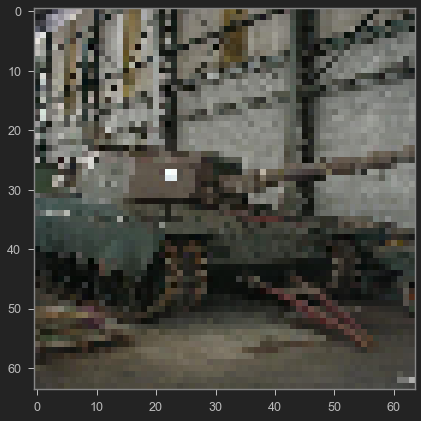

True class: Tank
Predicted probability:
Tank: 62%, Armored_tracked: 18%, Armored_wheeled: 7%, Artillery: 11% 


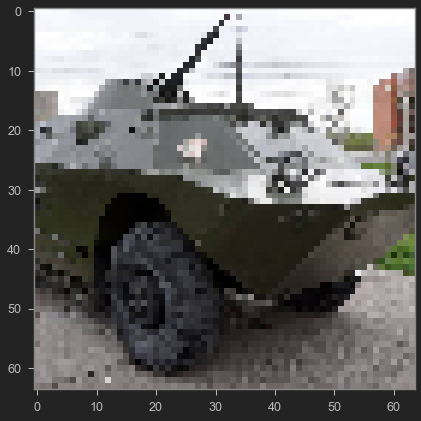

True class: Armored_wheeled
Predicted probability:
Tank: 0%, Armored_tracked: 2%, Armored_wheeled: 97%, Artillery: 0% 


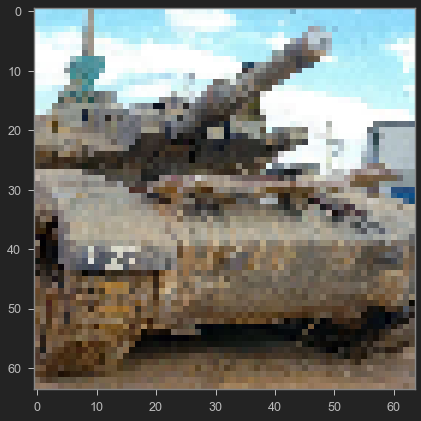

True class: Tank
Predicted probability:
Tank: 72%, Armored_tracked: 26%, Armored_wheeled: 0%, Artillery: 0% 


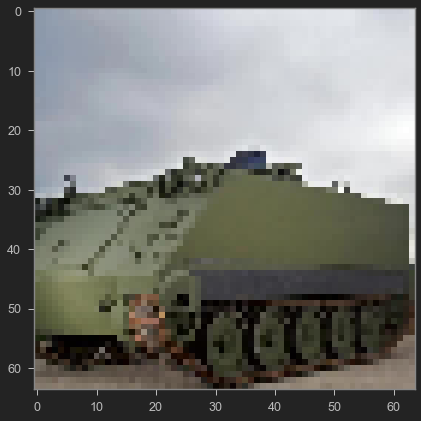

True class: Armored_tracked
Predicted probability:
Tank: 5%, Armored_tracked: 87%, Armored_wheeled: 6%, Artillery: 0% 


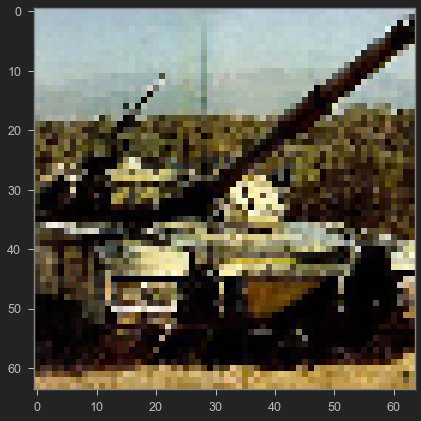

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


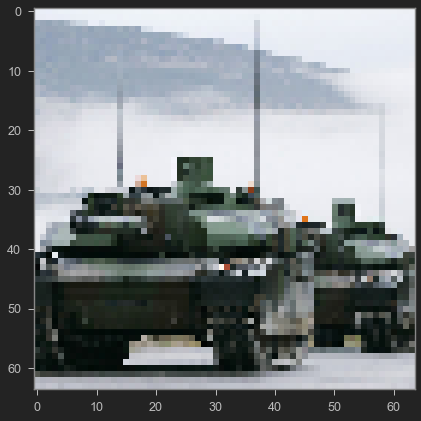

True class: Tank
Predicted probability:
Tank: 100%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


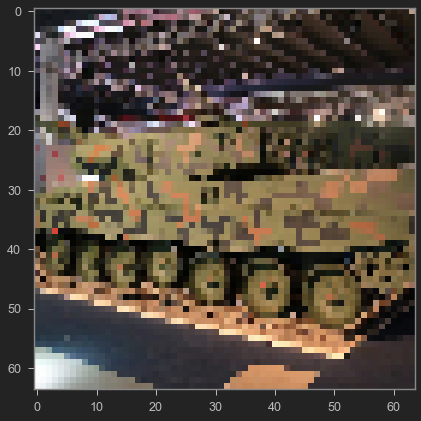

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


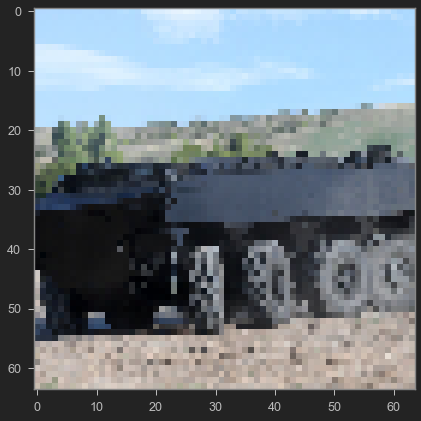

True class: Armored_wheeled
Predicted probability:
Tank: 96%, Armored_tracked: 2%, Armored_wheeled: 0%, Artillery: 0% 


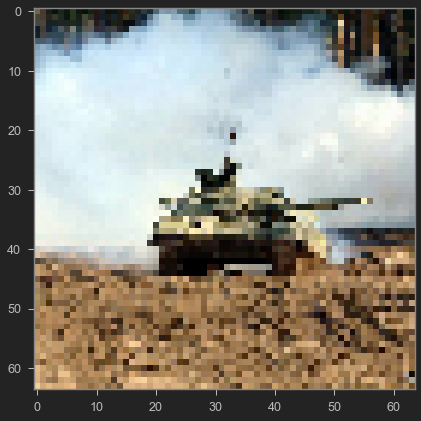

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


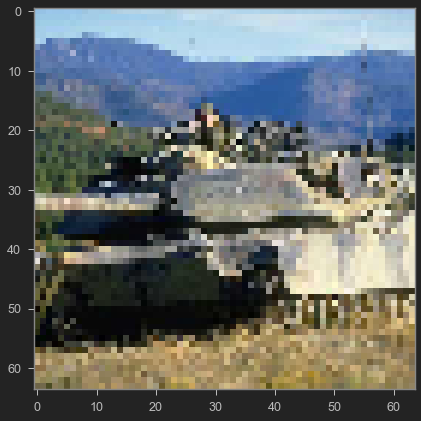

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


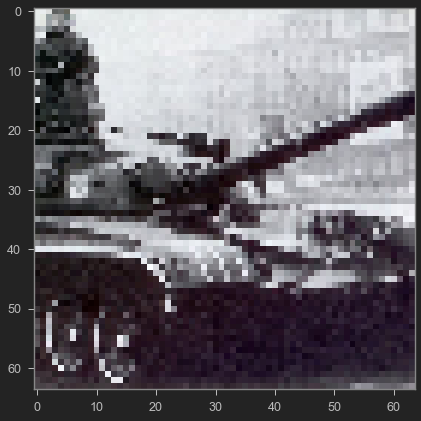

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


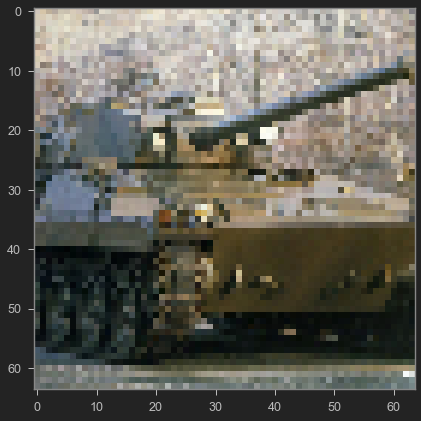

True class: Tank
Predicted probability:
Tank: 0%, Armored_tracked: 11%, Armored_wheeled: 87%, Artillery: 0% 


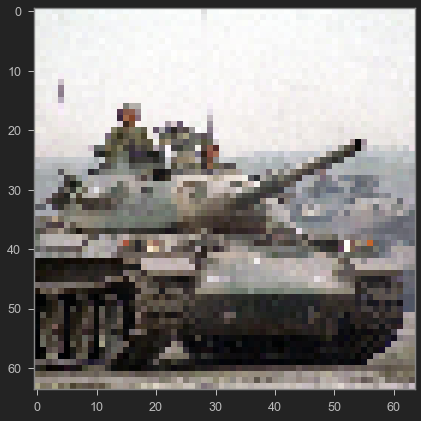

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


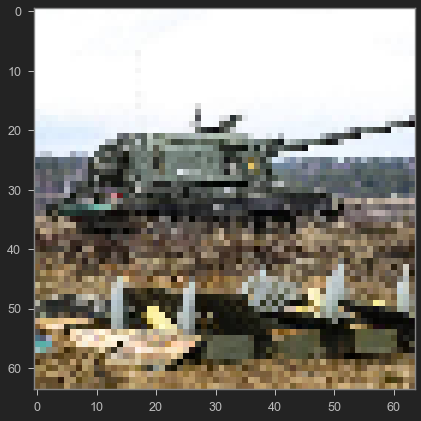

True class: Artillery
Predicted probability:
Tank: 24%, Armored_tracked: 4%, Armored_wheeled: 0%, Artillery: 71% 


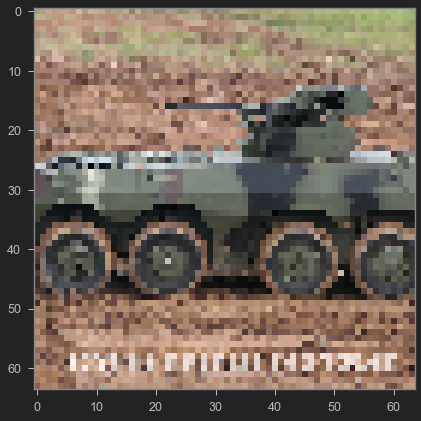

True class: Armored_wheeled
Predicted probability:
Tank: 96%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 2% 


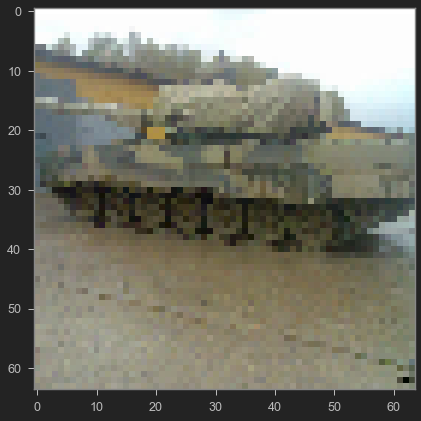

True class: Tank
Predicted probability:
Tank: 46%, Armored_tracked: 18%, Armored_wheeled: 35%, Artillery: 0% 


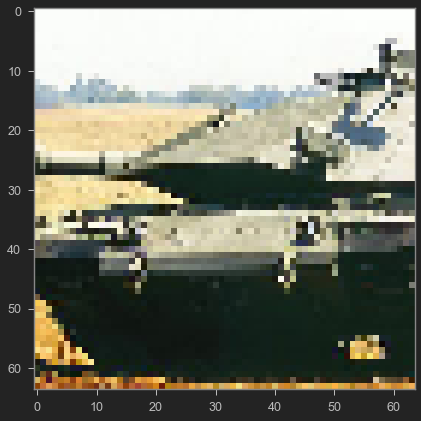

True class: Tank
Predicted probability:
Tank: 100%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


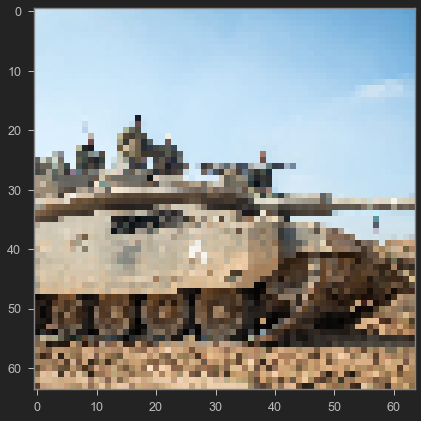

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


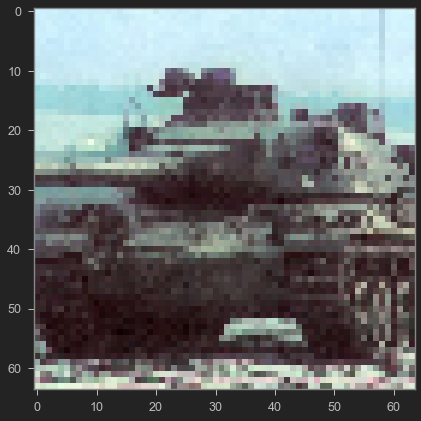

True class: Tank
Predicted probability:
Tank: 97%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 1% 


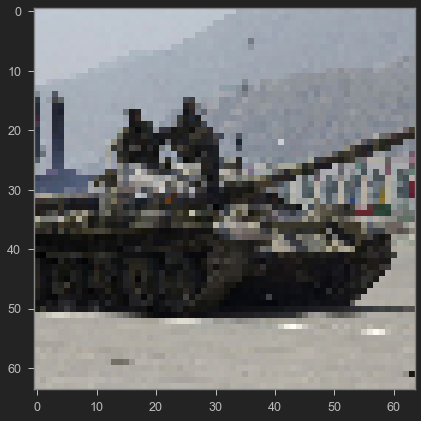

True class: Tank
Predicted probability:
Tank: 0%, Armored_tracked: 99%, Armored_wheeled: 0%, Artillery: 0% 


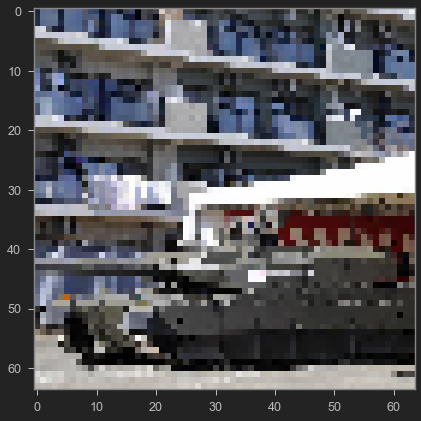

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


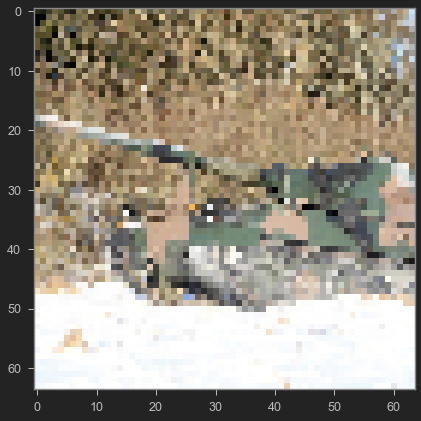

True class: Artillery
Predicted probability:
Tank: 6%, Armored_tracked: 1%, Armored_wheeled: 0%, Artillery: 91% 


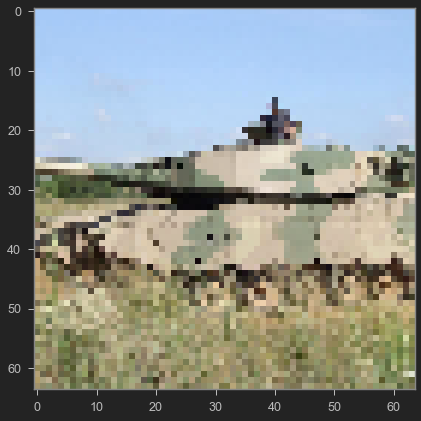

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


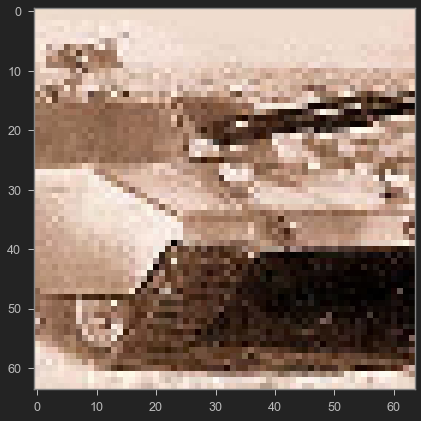

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


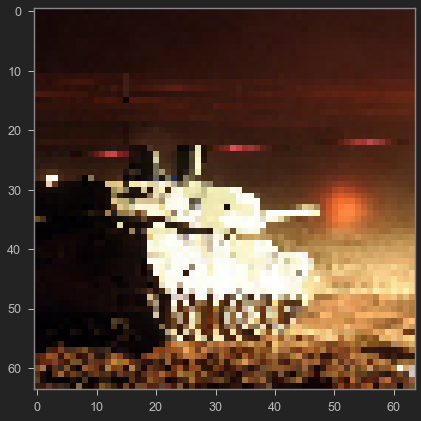

True class: Tank
Predicted probability:
Tank: 82%, Armored_tracked: 15%, Armored_wheeled: 2%, Artillery: 0% 


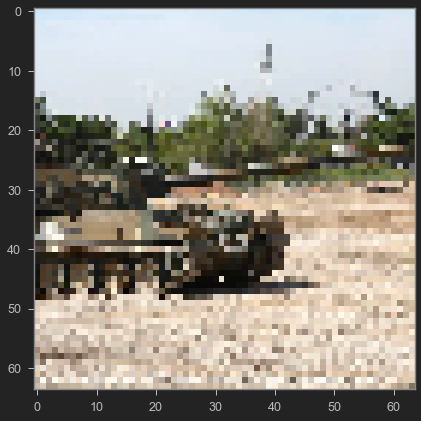

True class: Artillery
Predicted probability:
Tank: 88%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 11% 


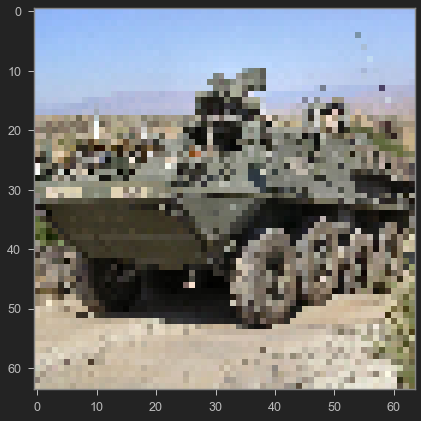

True class: Armored_wheeled
Predicted probability:
Tank: 0%, Armored_tracked: 95%, Armored_wheeled: 4%, Artillery: 0% 


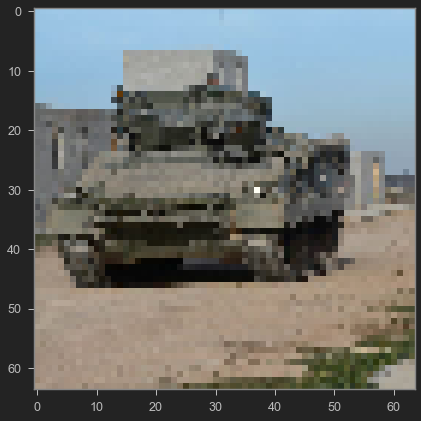

True class: Armored_tracked
Predicted probability:
Tank: 75%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 24% 


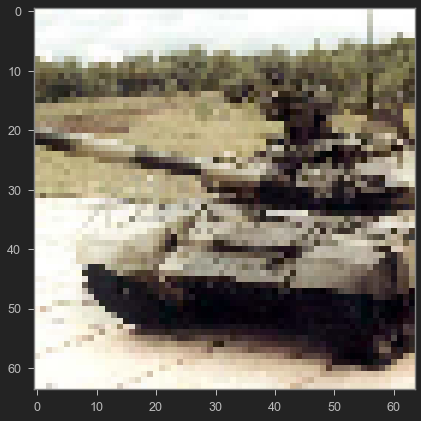

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


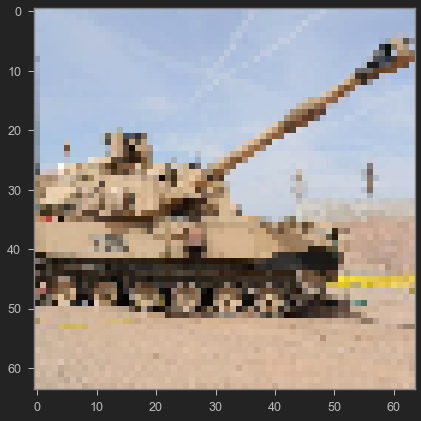

True class: Artillery
Predicted probability:
Tank: 61%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 37% 


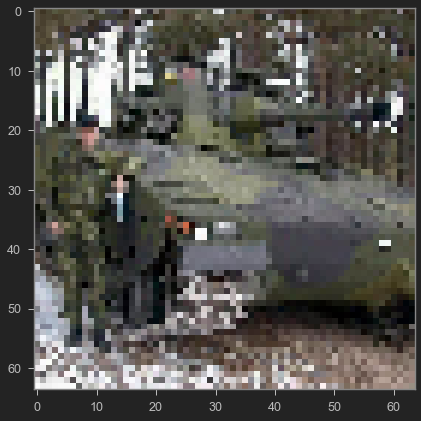

True class: Armored_tracked
Predicted probability:
Tank: 0%, Armored_tracked: 34%, Armored_wheeled: 65%, Artillery: 0% 


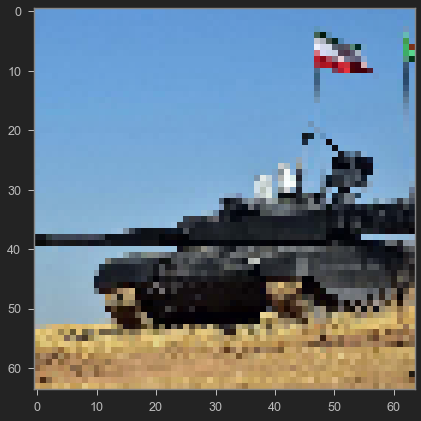

True class: Tank
Predicted probability:
Tank: 98%, Armored_tracked: 1%, Armored_wheeled: 0%, Artillery: 0% 


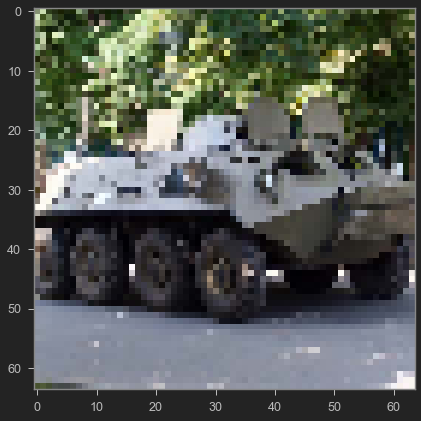

True class: Armored_wheeled
Predicted probability:
Tank: 0%, Armored_tracked: 2%, Armored_wheeled: 97%, Artillery: 0% 


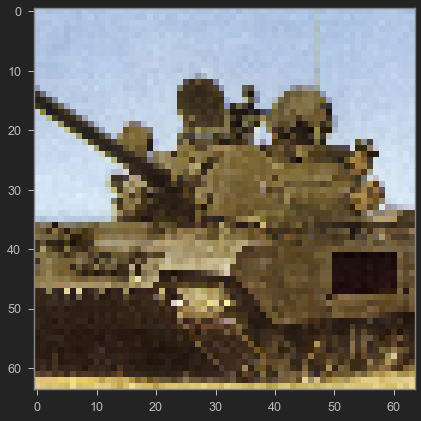

True class: Tank
Predicted probability:
Tank: 33%, Armored_tracked: 1%, Armored_wheeled: 0%, Artillery: 64% 


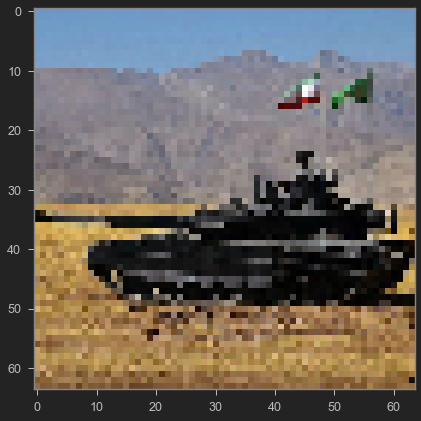

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


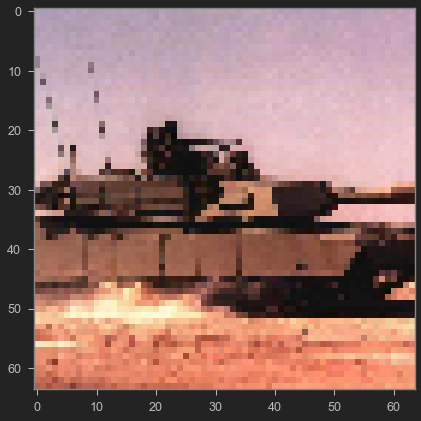

True class: Tank
Predicted probability:
Tank: 31%, Armored_tracked: 42%, Armored_wheeled: 0%, Artillery: 25% 


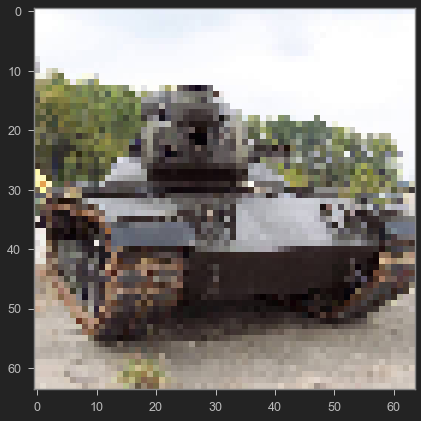

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


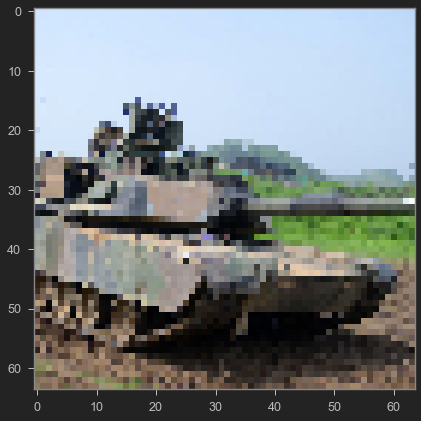

True class: Tank
Predicted probability:
Tank: 100%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


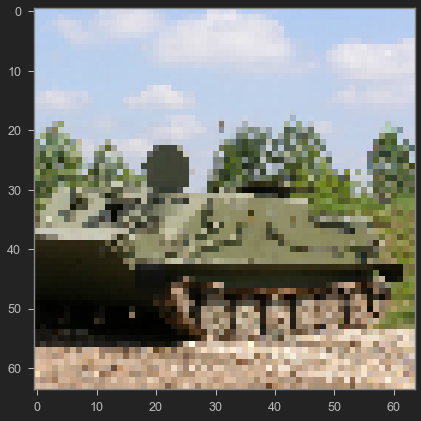

True class: Armored_tracked
Predicted probability:
Tank: 0%, Armored_tracked: 99%, Armored_wheeled: 0%, Artillery: 0% 


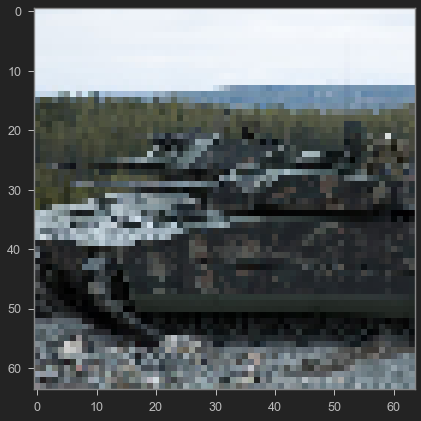

True class: Armored_tracked
Predicted probability:
Tank: 0%, Armored_tracked: 99%, Armored_wheeled: 0%, Artillery: 0% 


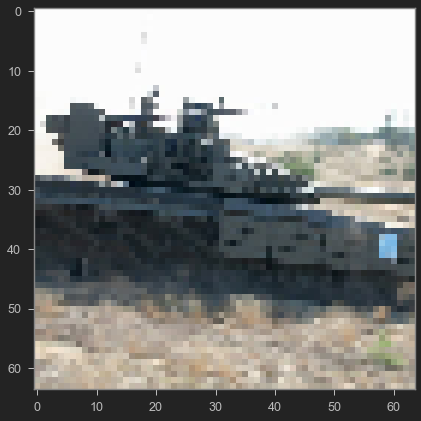

True class: Tank
Predicted probability:
Tank: 92%, Armored_tracked: 4%, Armored_wheeled: 0%, Artillery: 1% 


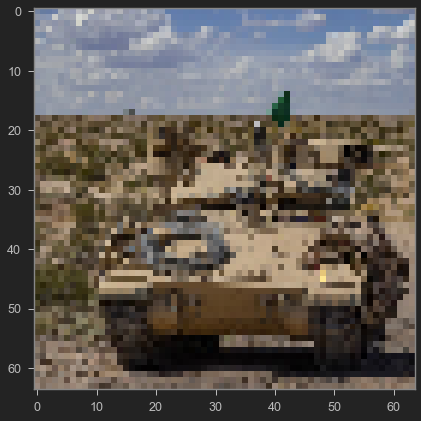

True class: Armored_tracked
Predicted probability:
Tank: 36%, Armored_tracked: 62%, Armored_wheeled: 0%, Artillery: 0% 


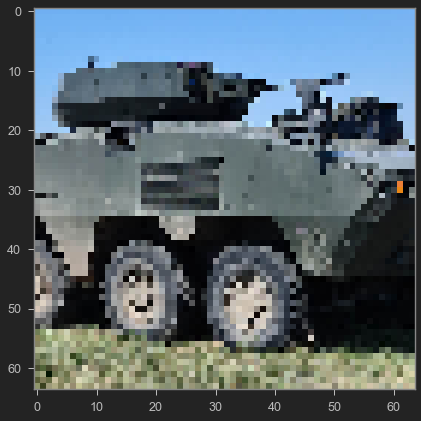

True class: Armored_wheeled
Predicted probability:
Tank: 0%, Armored_tracked: 0%, Armored_wheeled: 99%, Artillery: 0% 


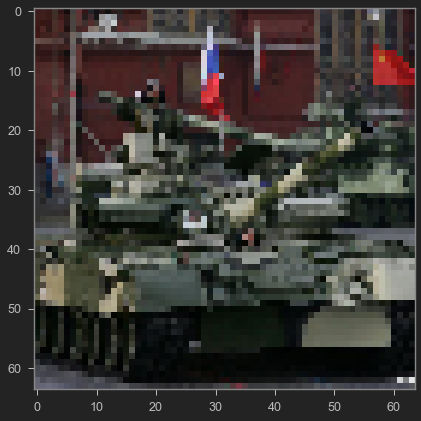

True class: Tank
Predicted probability:
Tank: 56%, Armored_tracked: 29%, Armored_wheeled: 0%, Artillery: 14% 


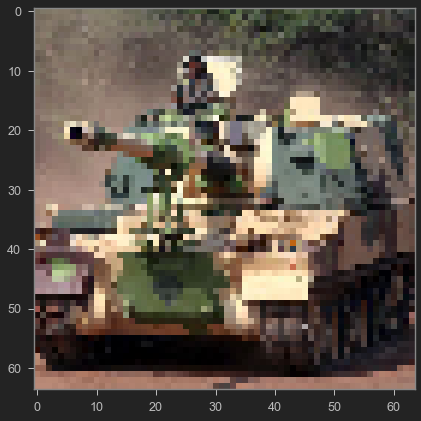

True class: Artillery
Predicted probability:
Tank: 50%, Armored_tracked: 36%, Armored_wheeled: 7%, Artillery: 5% 


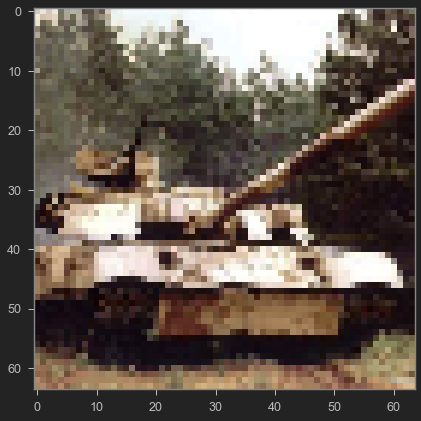

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


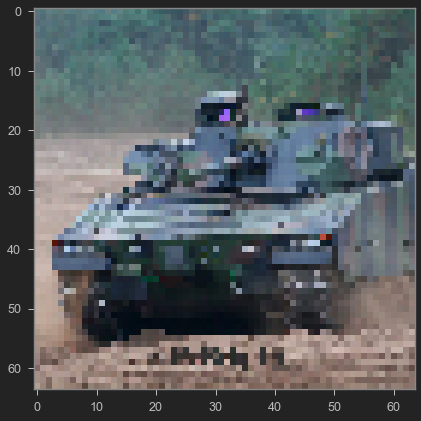

True class: Armored_tracked
Predicted probability:
Tank: 0%, Armored_tracked: 99%, Armored_wheeled: 0%, Artillery: 0% 


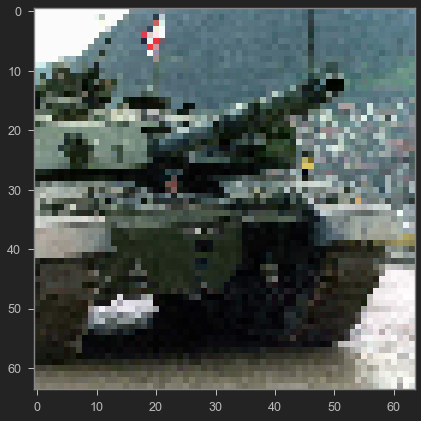

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


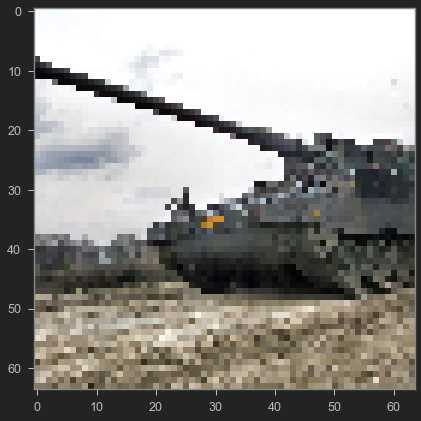

True class: Artillery
Predicted probability:
Tank: 8%, Armored_tracked: 91%, Armored_wheeled: 0%, Artillery: 0% 


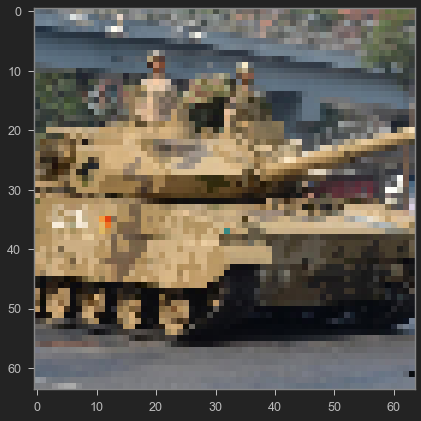

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


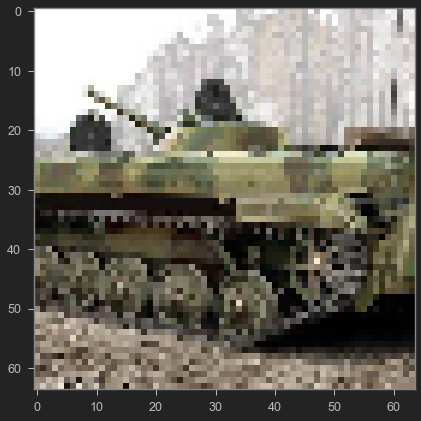

True class: Armored_tracked
Predicted probability:
Tank: 68%, Armored_tracked: 3%, Armored_wheeled: 28%, Artillery: 0% 


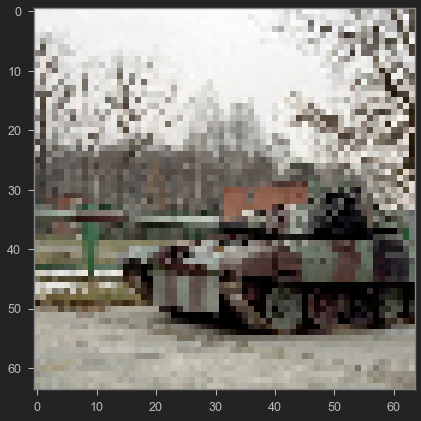

True class: Tank
Predicted probability:
Tank: 98%, Armored_tracked: 1%, Armored_wheeled: 0%, Artillery: 0% 


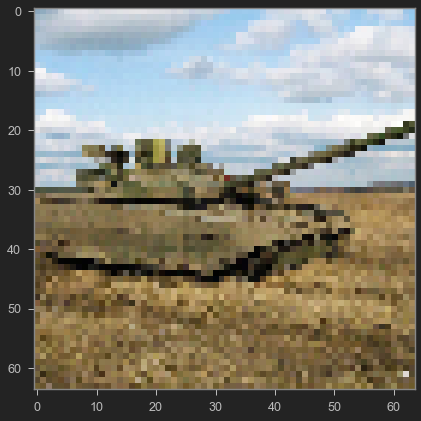

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


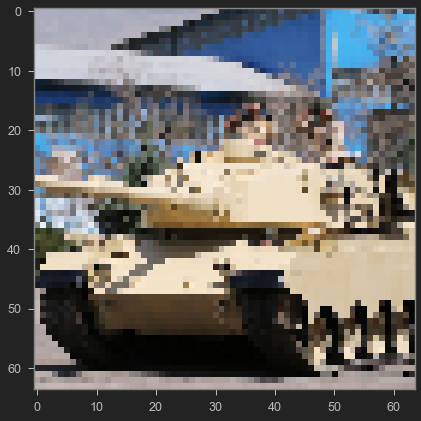

True class: Tank
Predicted probability:
Tank: 100%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


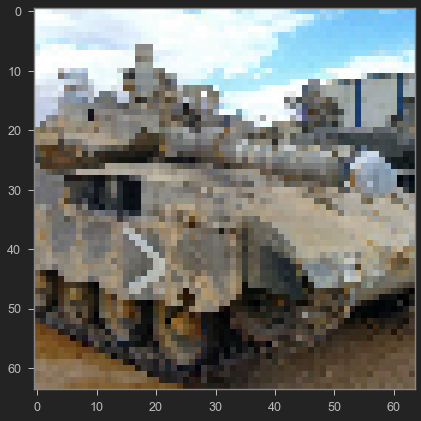

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


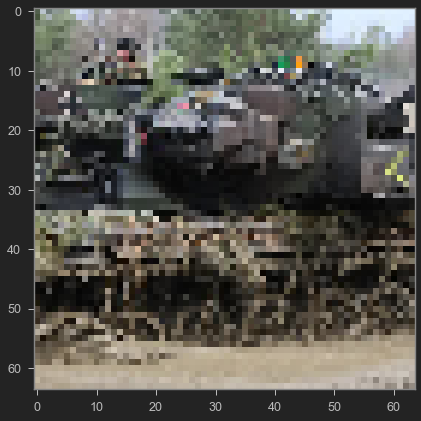

True class: Armored_tracked
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


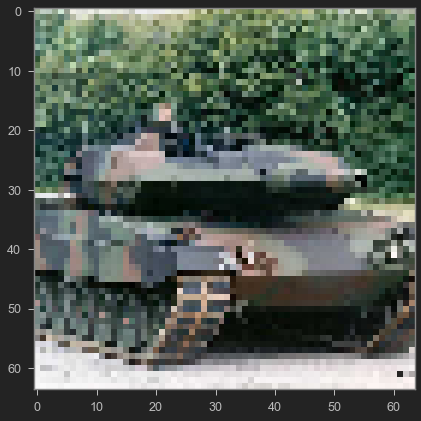

True class: Tank
Predicted probability:
Tank: 100%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


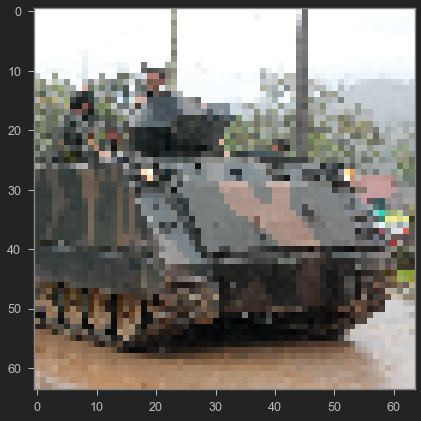

True class: Armored_tracked
Predicted probability:
Tank: 31%, Armored_tracked: 65%, Armored_wheeled: 1%, Artillery: 1% 


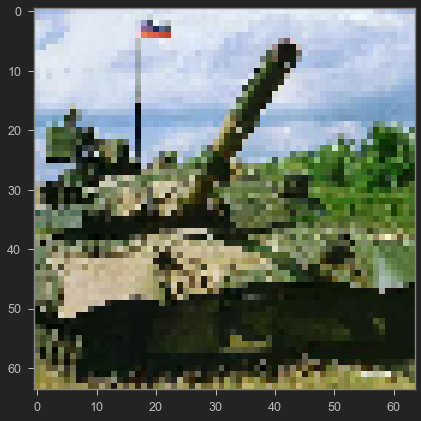

True class: Tank
Predicted probability:
Tank: 100%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


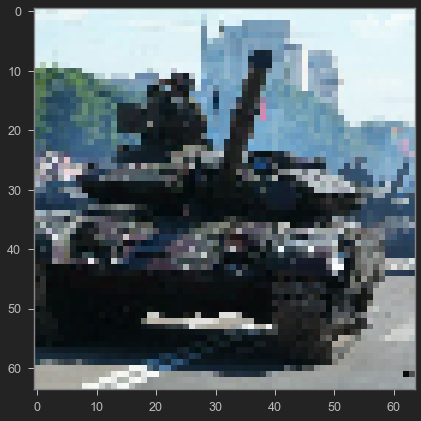

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


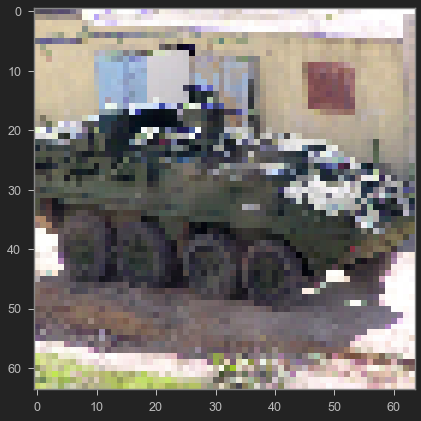

True class: Armored_wheeled
Predicted probability:
Tank: 10%, Armored_tracked: 14%, Armored_wheeled: 75%, Artillery: 0% 


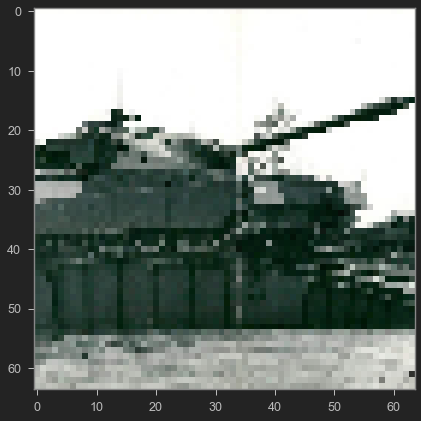

True class: Tank
Predicted probability:
Tank: 0%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 99% 


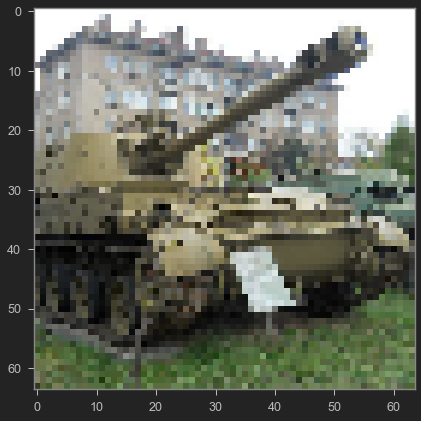

True class: Artillery
Predicted probability:
Tank: 36%, Armored_tracked: 47%, Armored_wheeled: 14%, Artillery: 0% 


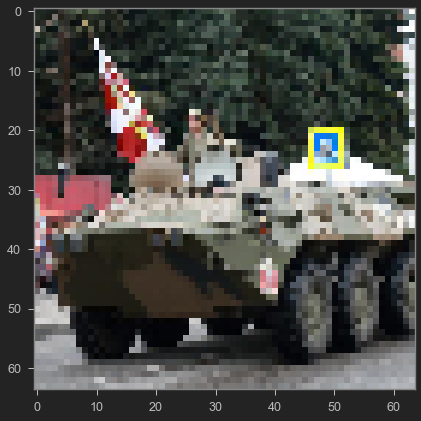

True class: Armored_wheeled
Predicted probability:
Tank: 29%, Armored_tracked: 54%, Armored_wheeled: 16%, Artillery: 0% 


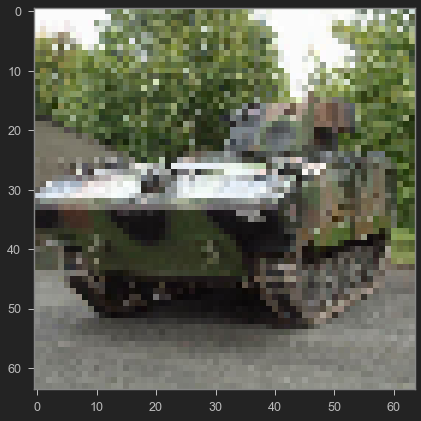

True class: Armored_tracked
Predicted probability:
Tank: 3%, Armored_tracked: 35%, Armored_wheeled: 61%, Artillery: 0% 


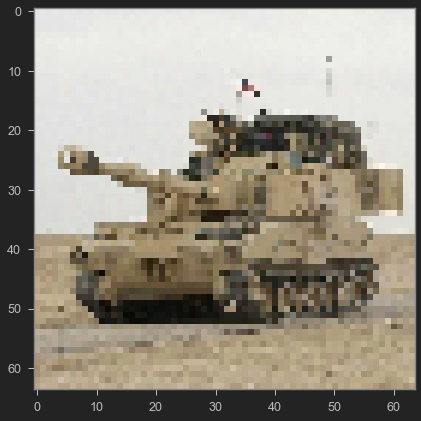

True class: Artillery
Predicted probability:
Tank: 95%, Armored_tracked: 4%, Armored_wheeled: 0%, Artillery: 0% 


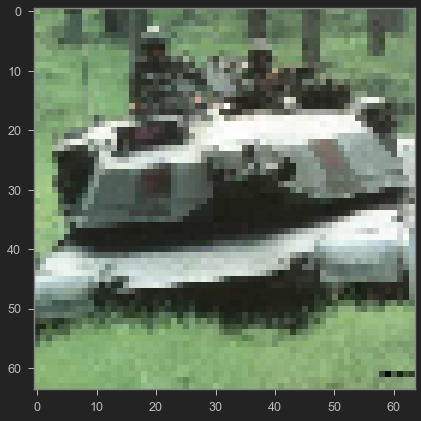

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


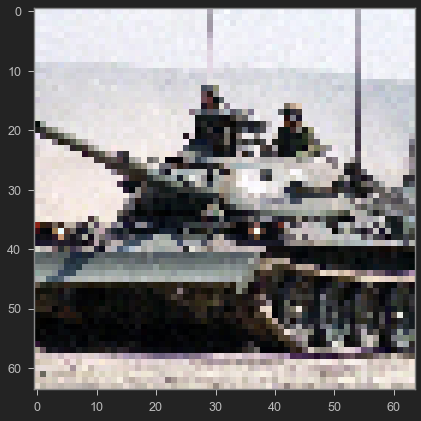

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


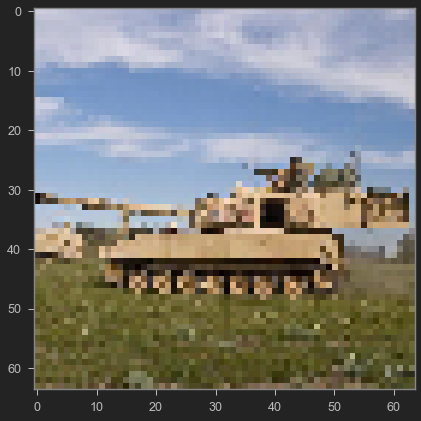

True class: Artillery
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


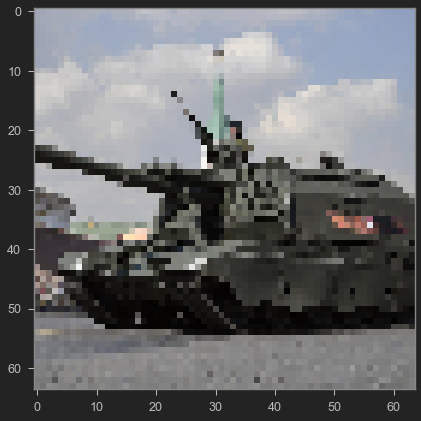

True class: Artillery
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


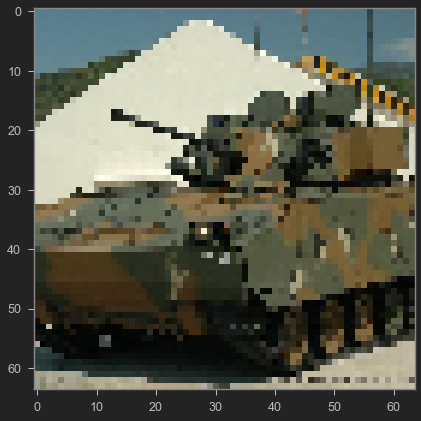

True class: Armored_tracked
Predicted probability:
Tank: 4%, Armored_tracked: 95%, Armored_wheeled: 0%, Artillery: 0% 


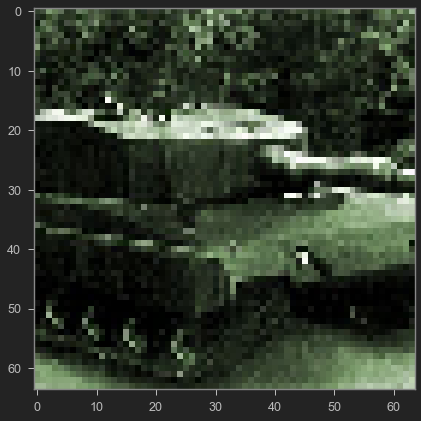

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


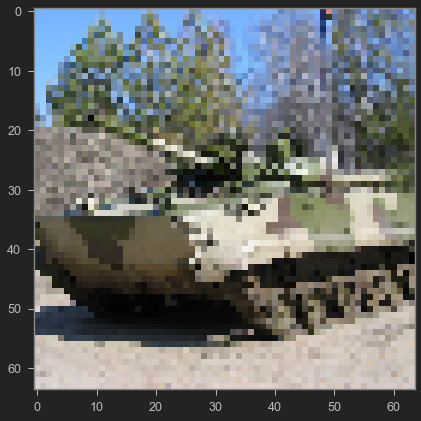

True class: Armored_tracked
Predicted probability:
Tank: 8%, Armored_tracked: 91%, Armored_wheeled: 0%, Artillery: 0% 


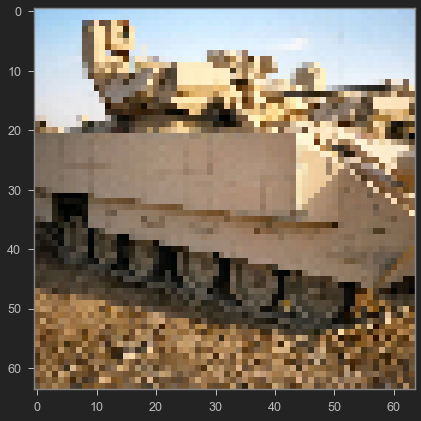

True class: Armored_tracked
Predicted probability:
Tank: 0%, Armored_tracked: 98%, Armored_wheeled: 1%, Artillery: 0% 


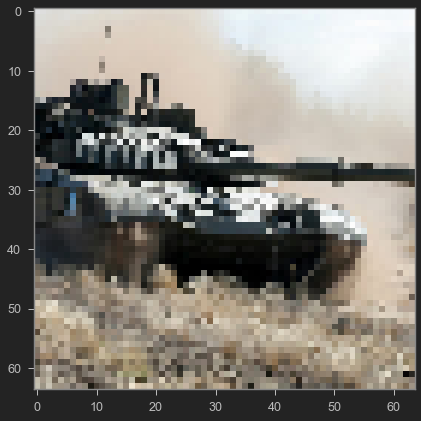

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


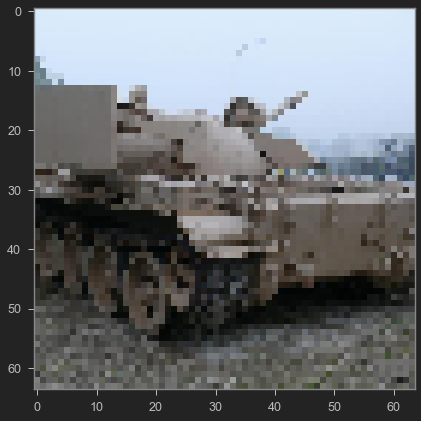

True class: Tank
Predicted probability:
Tank: 33%, Armored_tracked: 60%, Armored_wheeled: 4%, Artillery: 0% 


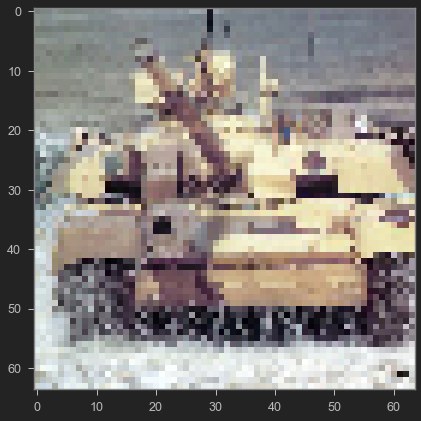

True class: Tank
Predicted probability:
Tank: 19%, Armored_tracked: 79%, Armored_wheeled: 0%, Artillery: 0% 


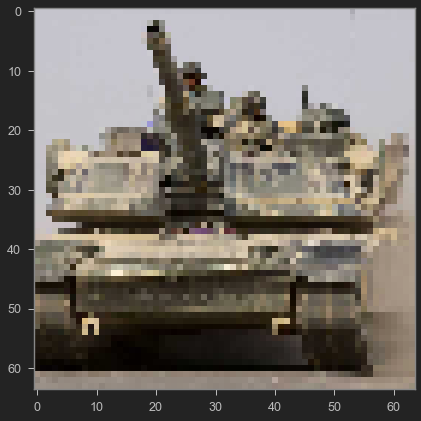

True class: Tank
Predicted probability:
Tank: 100%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


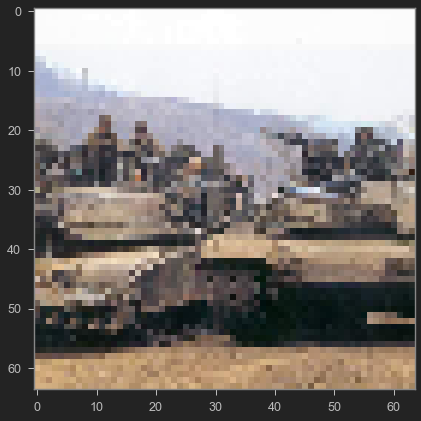

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


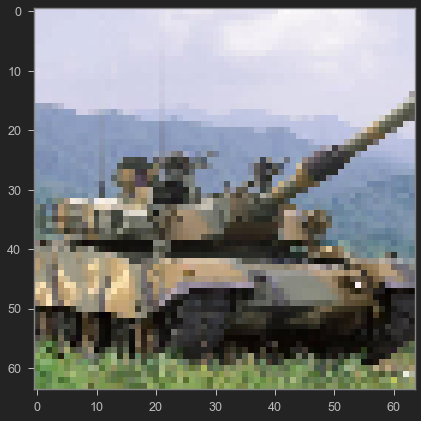

True class: Tank
Predicted probability:
Tank: 100%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


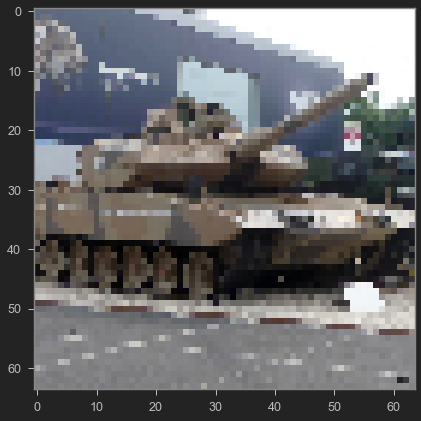

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


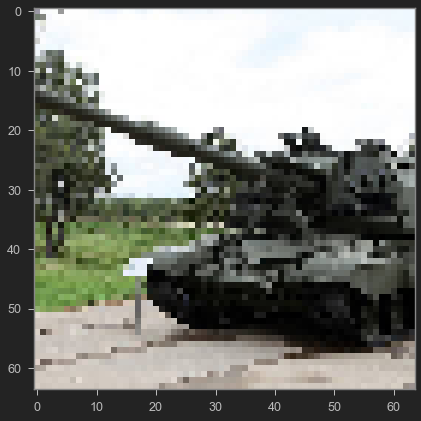

True class: Artillery
Predicted probability:
Tank: 0%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 99% 


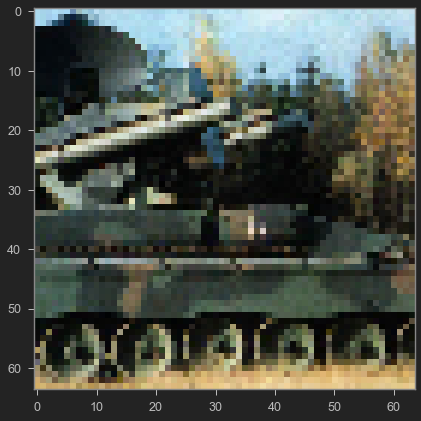

True class: Armored_tracked
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


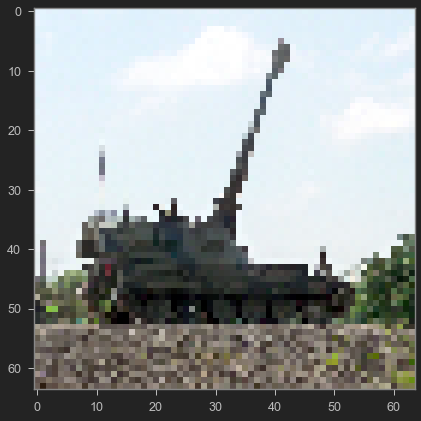

True class: Artillery
Predicted probability:
Tank: 5%, Armored_tracked: 94%, Armored_wheeled: 0%, Artillery: 0% 


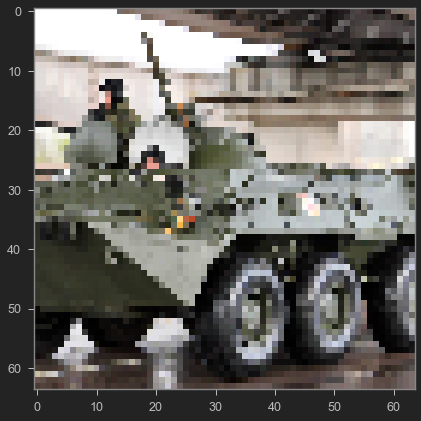

True class: Armored_wheeled
Predicted probability:
Tank: 0%, Armored_tracked: 7%, Armored_wheeled: 91%, Artillery: 0% 


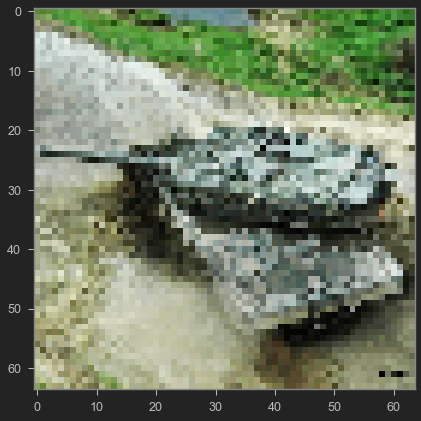

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


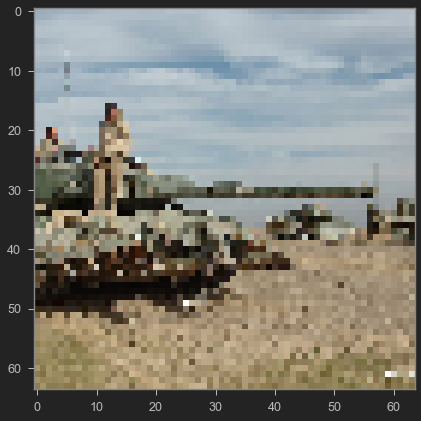

True class: Tank
Predicted probability:
Tank: 83%, Armored_tracked: 16%, Armored_wheeled: 0%, Artillery: 0% 


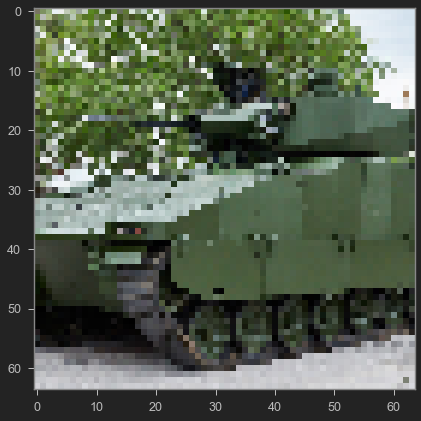

True class: Armored_tracked
Predicted probability:
Tank: 5%, Armored_tracked: 24%, Armored_wheeled: 69%, Artillery: 0% 


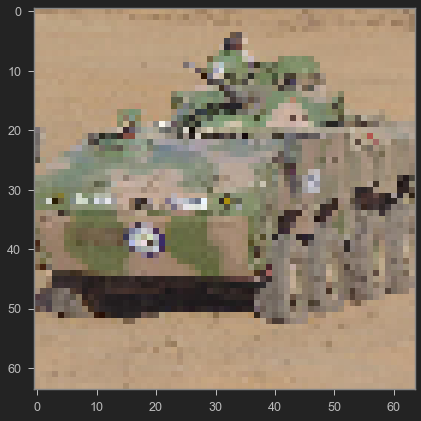

True class: Armored_wheeled
Predicted probability:
Tank: 1%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 98% 


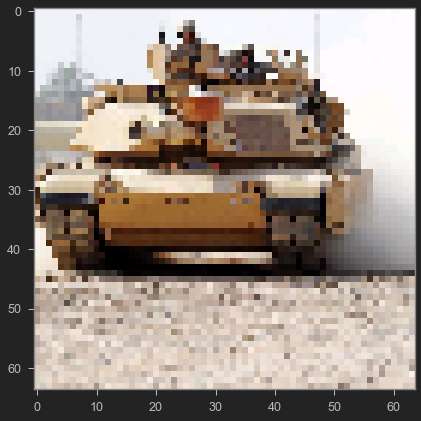

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


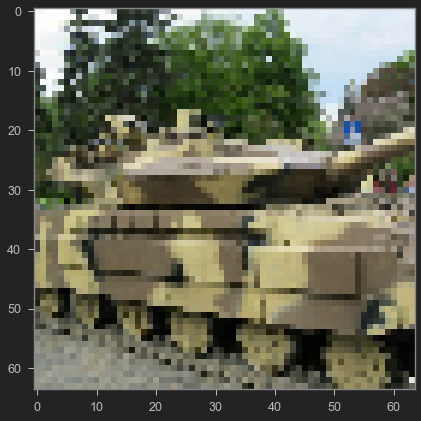

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


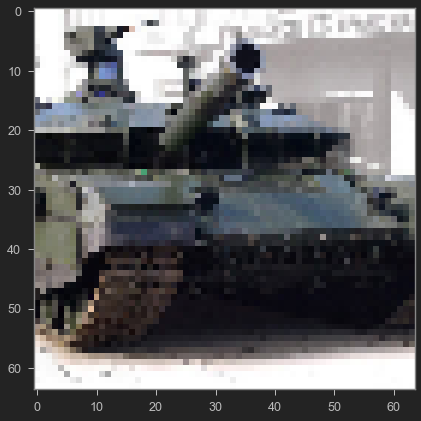

True class: Tank
Predicted probability:
Tank: 76%, Armored_tracked: 23%, Armored_wheeled: 0%, Artillery: 0% 


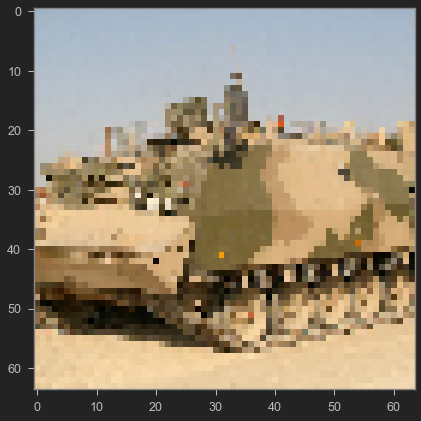

True class: Armored_tracked
Predicted probability:
Tank: 7%, Armored_tracked: 88%, Armored_wheeled: 0%, Artillery: 3% 


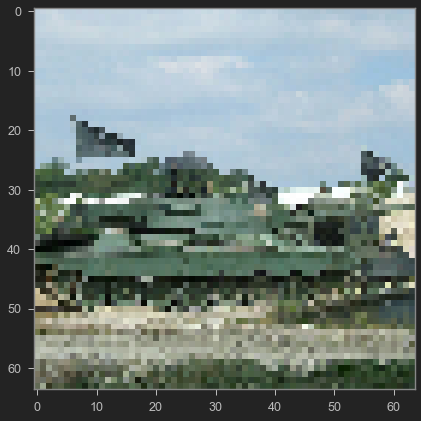

True class: Tank
Predicted probability:
Tank: 85%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 13% 


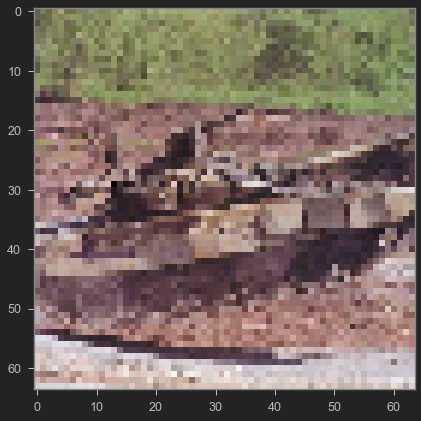

True class: Tank
Predicted probability:
Tank: 80%, Armored_tracked: 10%, Armored_wheeled: 7%, Artillery: 0% 


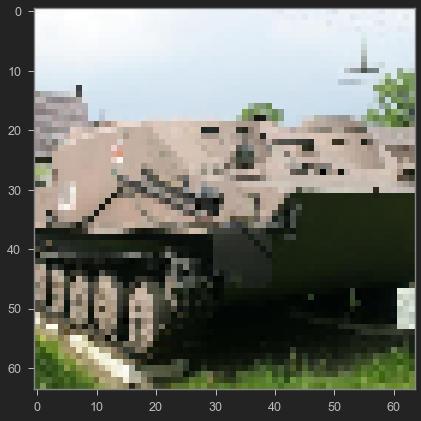

True class: Armored_tracked
Predicted probability:
Tank: 0%, Armored_tracked: 12%, Armored_wheeled: 84%, Artillery: 2% 


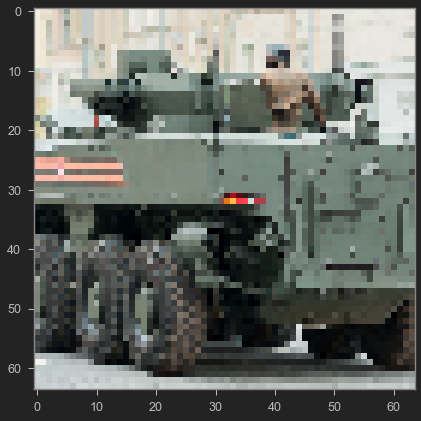

True class: Armored_wheeled
Predicted probability:
Tank: 0%, Armored_tracked: 0%, Armored_wheeled: 99%, Artillery: 0% 


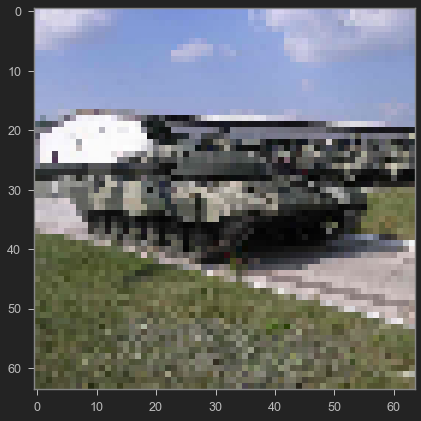

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


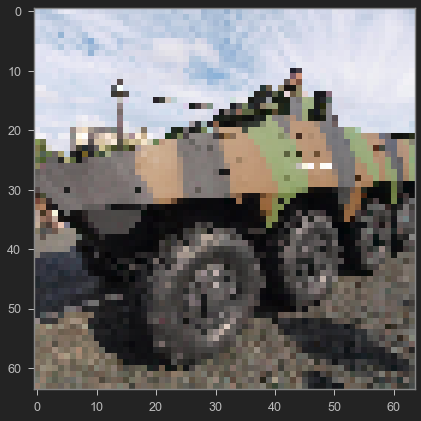

True class: Armored_wheeled
Predicted probability:
Tank: 0%, Armored_tracked: 0%, Armored_wheeled: 99%, Artillery: 0% 


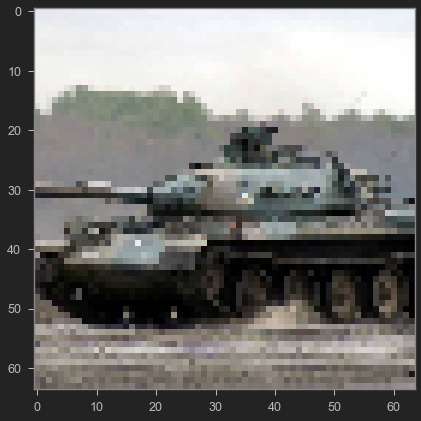

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


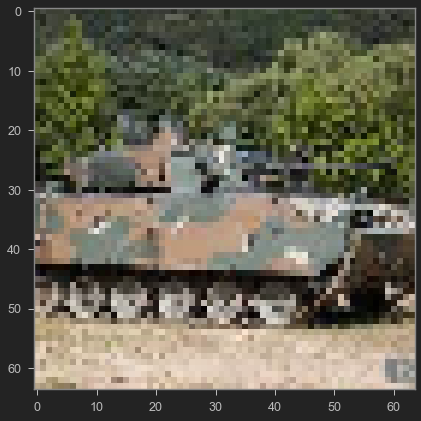

True class: Armored_tracked
Predicted probability:
Tank: 23%, Armored_tracked: 72%, Armored_wheeled: 4%, Artillery: 0% 


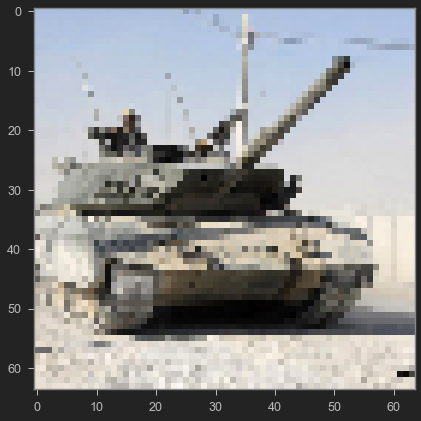

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


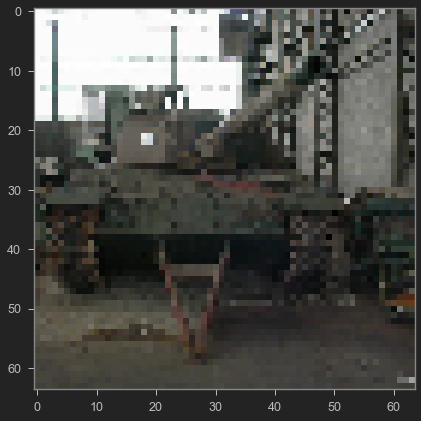

True class: Tank
Predicted probability:
Tank: 46%, Armored_tracked: 32%, Armored_wheeled: 20%, Artillery: 0% 


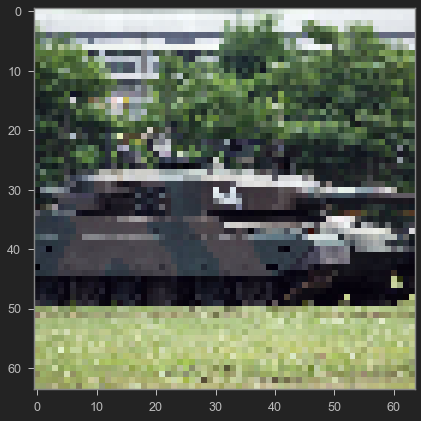

True class: Tank
Predicted probability:
Tank: 97%, Armored_tracked: 2%, Armored_wheeled: 0%, Artillery: 0% 


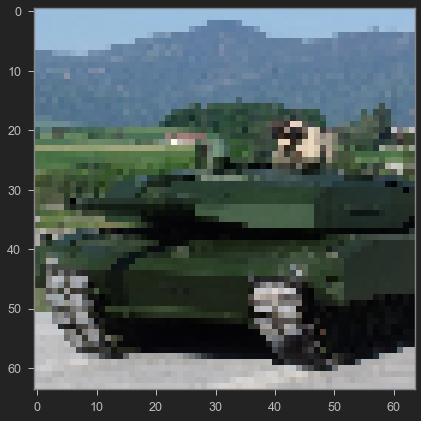

True class: Tank
Predicted probability:
Tank: 15%, Armored_tracked: 47%, Armored_wheeled: 36%, Artillery: 0% 


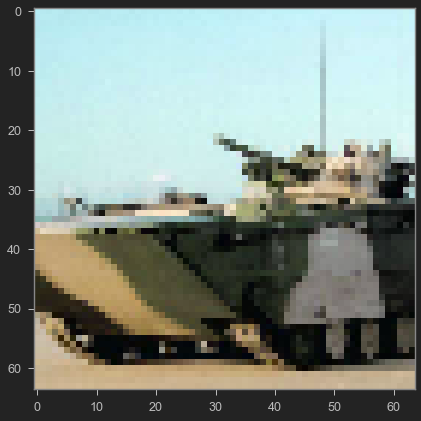

True class: Armored_tracked
Predicted probability:
Tank: 0%, Armored_tracked: 82%, Armored_wheeled: 17%, Artillery: 0% 


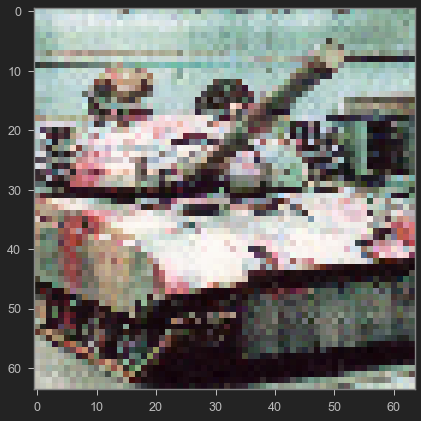

True class: Tank
Predicted probability:
Tank: 100%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


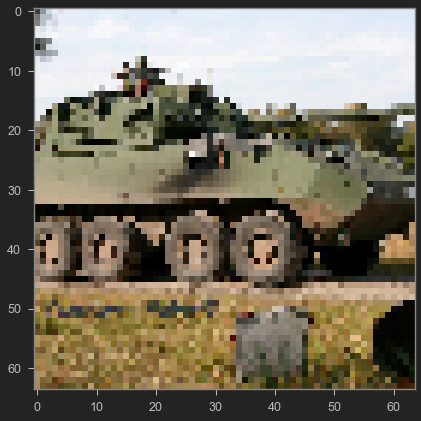

True class: Armored_wheeled
Predicted probability:
Tank: 0%, Armored_tracked: 0%, Armored_wheeled: 100%, Artillery: 0% 


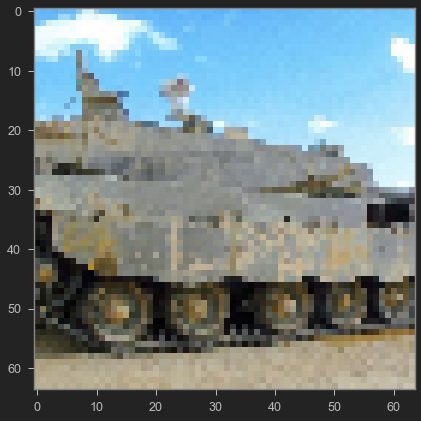

True class: Tank
Predicted probability:
Tank: 5%, Armored_tracked: 93%, Armored_wheeled: 0%, Artillery: 0% 


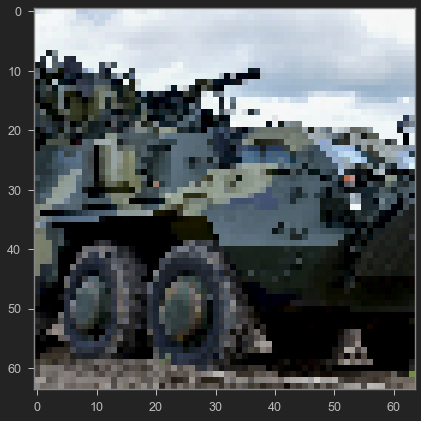

True class: Armored_wheeled
Predicted probability:
Tank: 0%, Armored_tracked: 2%, Armored_wheeled: 97%, Artillery: 0% 


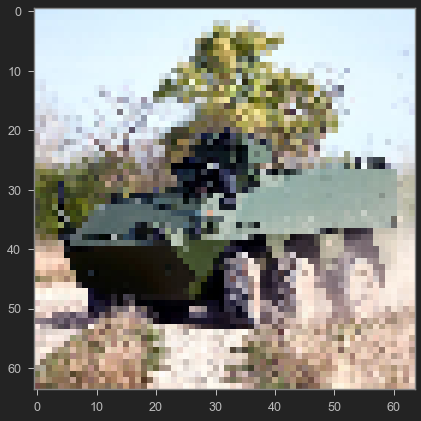

True class: Armored_wheeled
Predicted probability:
Tank: 0%, Armored_tracked: 99%, Armored_wheeled: 0%, Artillery: 0% 


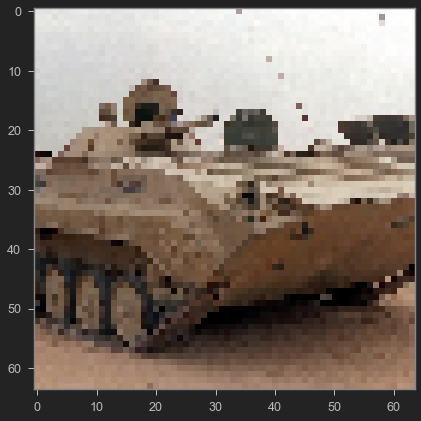

True class: Armored_tracked
Predicted probability:
Tank: 3%, Armored_tracked: 84%, Armored_wheeled: 11%, Artillery: 0% 


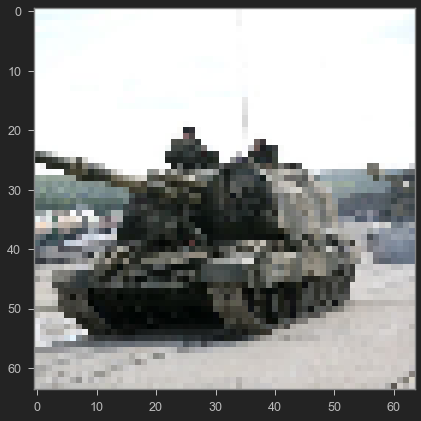

True class: Artillery
Predicted probability:
Tank: 89%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 10% 


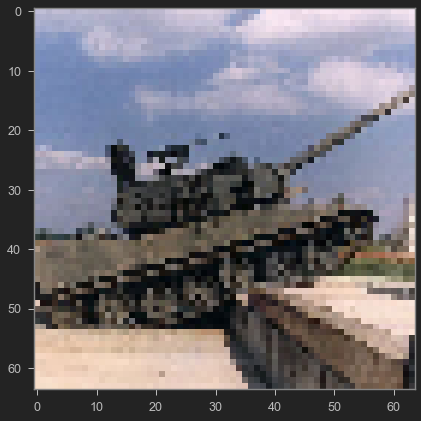

True class: Tank
Predicted probability:
Tank: 41%, Armored_tracked: 46%, Armored_wheeled: 9%, Artillery: 2% 


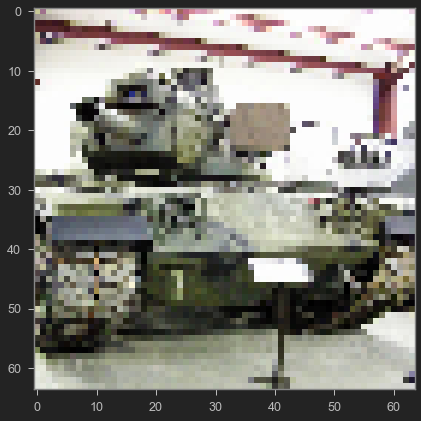

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


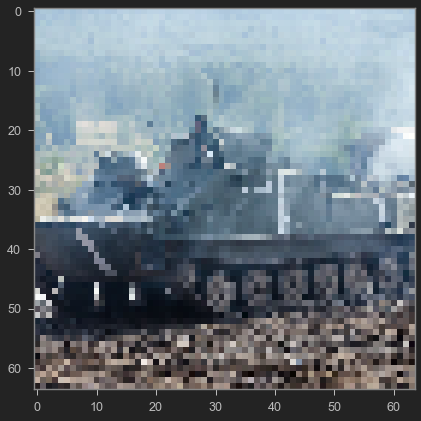

True class: Armored_tracked
Predicted probability:
Tank: 0%, Armored_tracked: 92%, Armored_wheeled: 6%, Artillery: 0% 


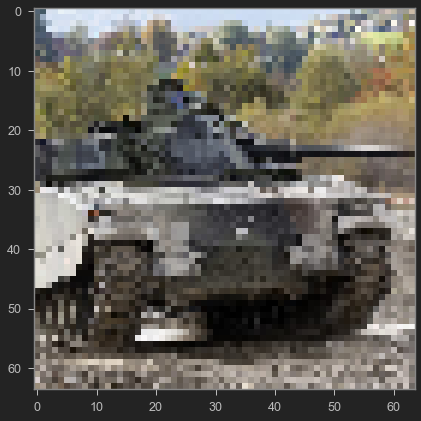

True class: Armored_tracked
Predicted probability:
Tank: 74%, Armored_tracked: 25%, Armored_wheeled: 0%, Artillery: 0% 


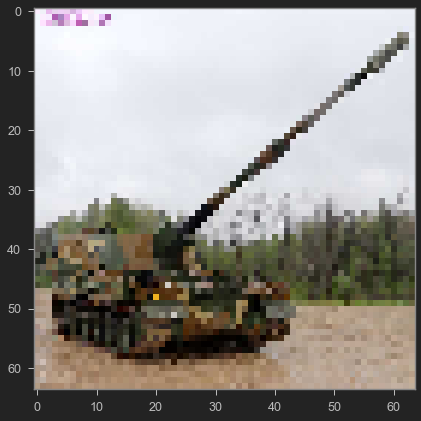

True class: Artillery
Predicted probability:
Tank: 3%, Armored_tracked: 18%, Armored_wheeled: 75%, Artillery: 2% 


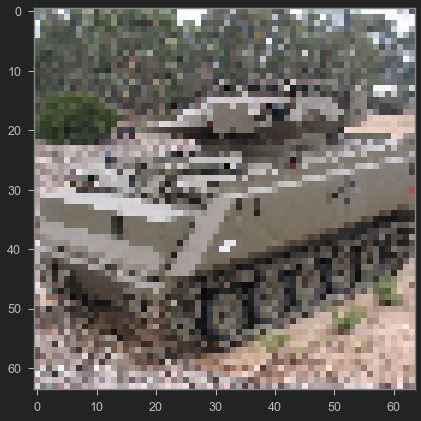

True class: Armored_tracked
Predicted probability:
Tank: 32%, Armored_tracked: 36%, Armored_wheeled: 30%, Artillery: 0% 


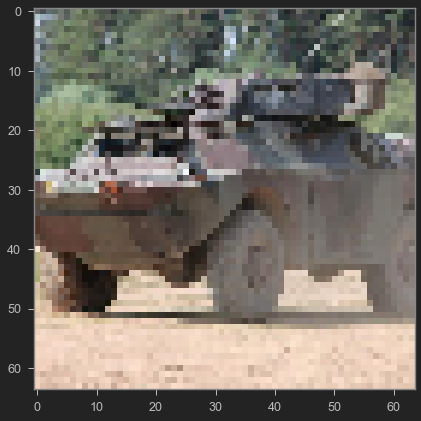

True class: Armored_wheeled
Predicted probability:
Tank: 5%, Armored_tracked: 43%, Armored_wheeled: 5%, Artillery: 45% 


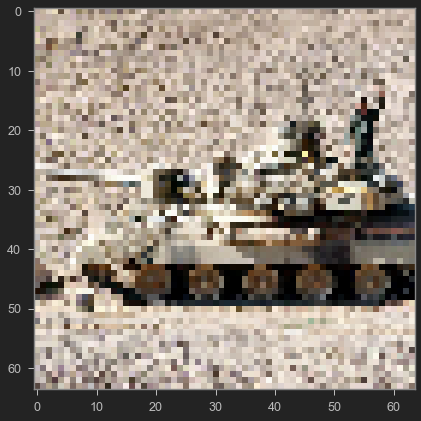

True class: Tank
Predicted probability:
Tank: 90%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 9% 


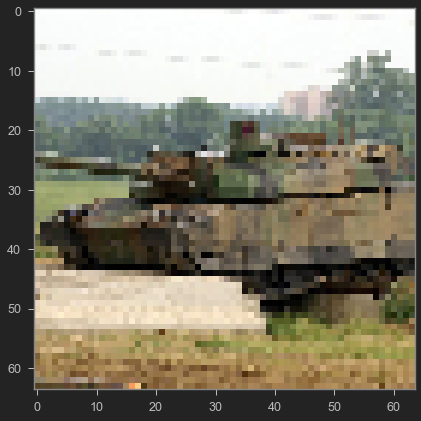

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


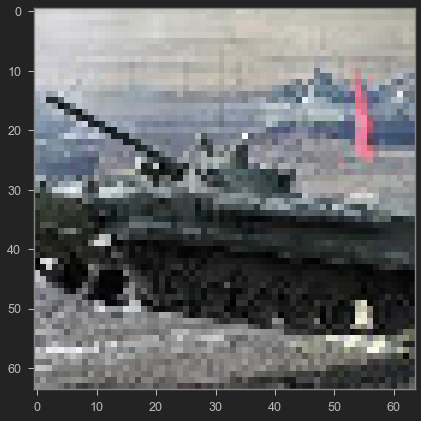

True class: Armored_tracked
Predicted probability:
Tank: 0%, Armored_tracked: 98%, Armored_wheeled: 0%, Artillery: 0% 


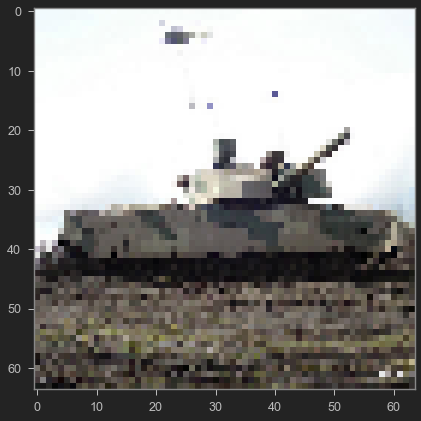

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


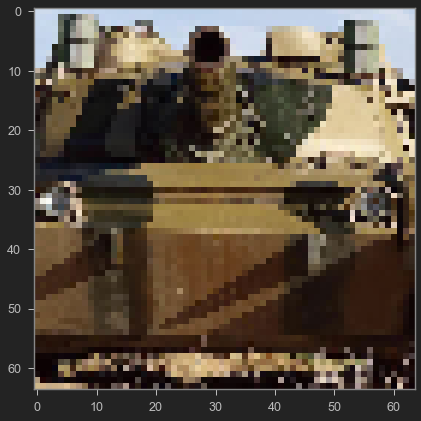

True class: Tank
Predicted probability:
Tank: 5%, Armored_tracked: 92%, Armored_wheeled: 1%, Artillery: 0% 


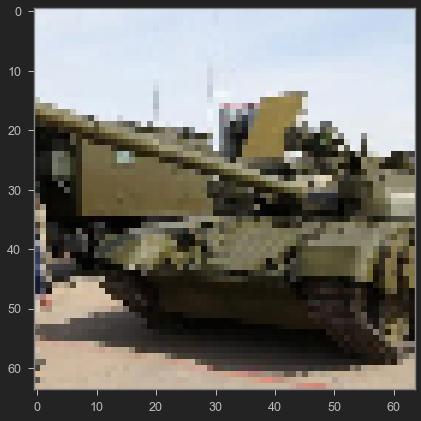

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


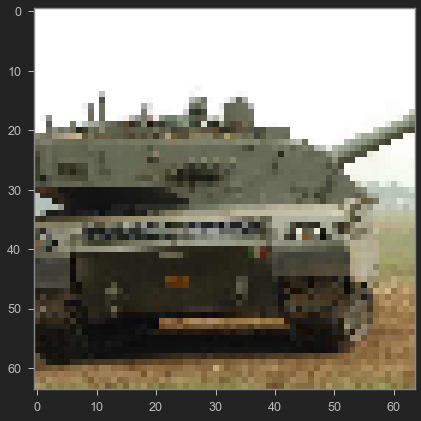

True class: Tank
Predicted probability:
Tank: 47%, Armored_tracked: 52%, Armored_wheeled: 0%, Artillery: 0% 


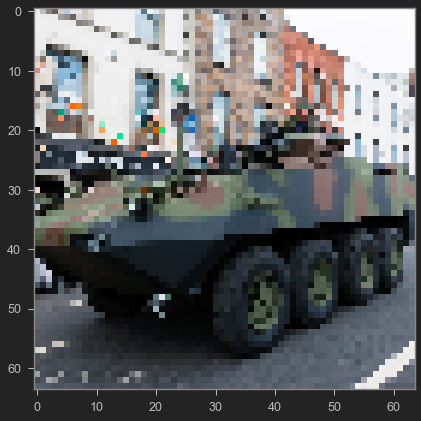

True class: Armored_wheeled
Predicted probability:
Tank: 0%, Armored_tracked: 2%, Armored_wheeled: 96%, Artillery: 0% 


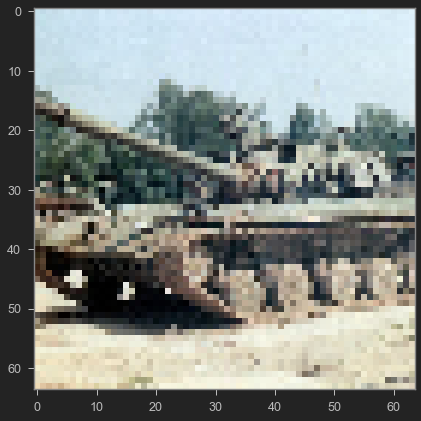

True class: Tank
Predicted probability:
Tank: 2%, Armored_tracked: 96%, Armored_wheeled: 0%, Artillery: 0% 


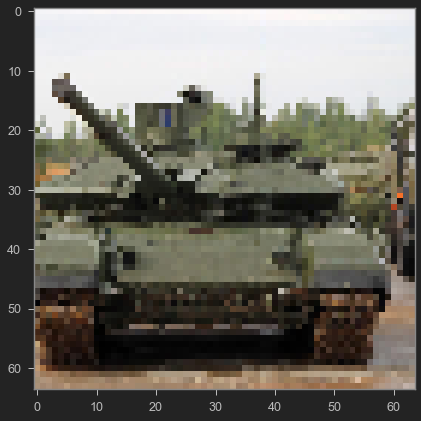

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


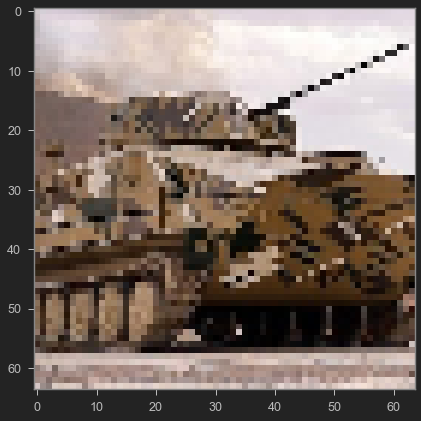

True class: Armored_tracked
Predicted probability:
Tank: 0%, Armored_tracked: 61%, Armored_wheeled: 38%, Artillery: 0% 


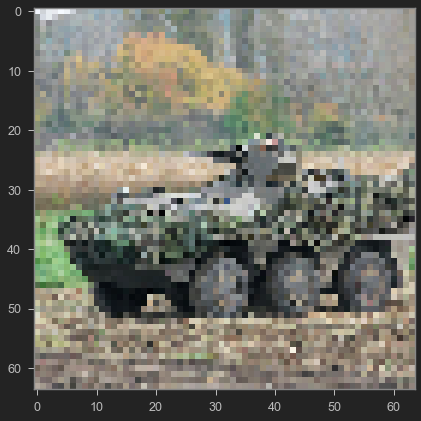

True class: Armored_wheeled
Predicted probability:
Tank: 0%, Armored_tracked: 76%, Armored_wheeled: 22%, Artillery: 0% 


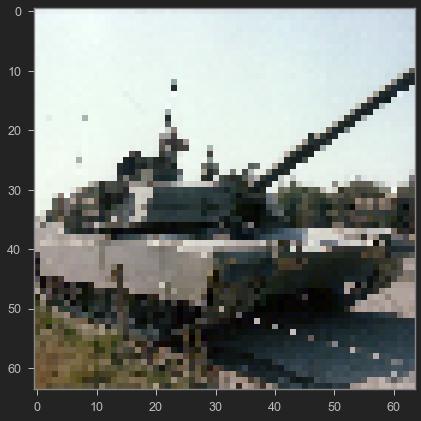

True class: Tank
Predicted probability:
Tank: 100%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


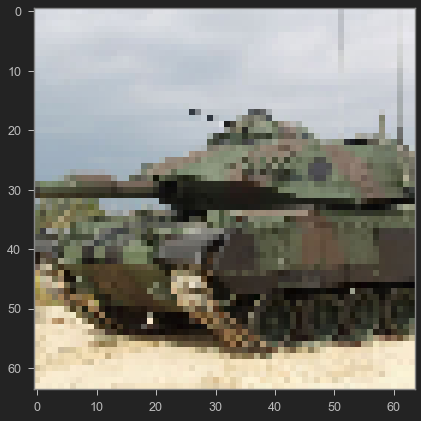

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


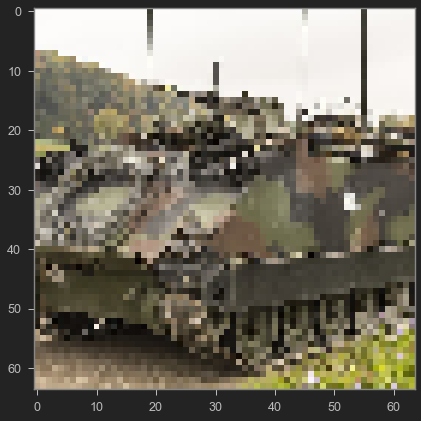

True class: Armored_tracked
Predicted probability:
Tank: 23%, Armored_tracked: 74%, Armored_wheeled: 0%, Artillery: 1% 


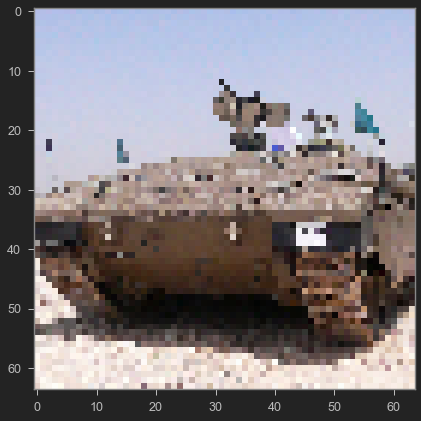

True class: Armored_tracked
Predicted probability:
Tank: 3%, Armored_tracked: 53%, Armored_wheeled: 41%, Artillery: 0% 


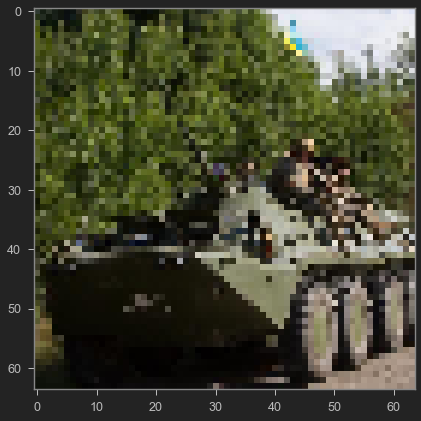

True class: Armored_wheeled
Predicted probability:
Tank: 73%, Armored_tracked: 23%, Armored_wheeled: 0%, Artillery: 2% 


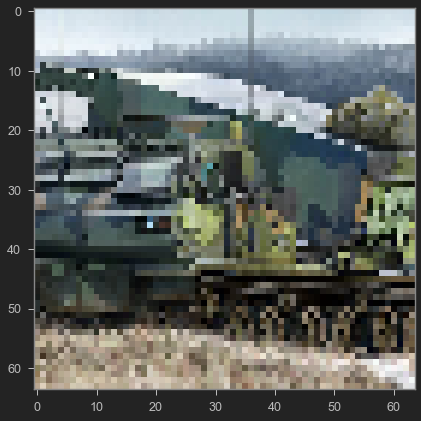

True class: Armored_tracked
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


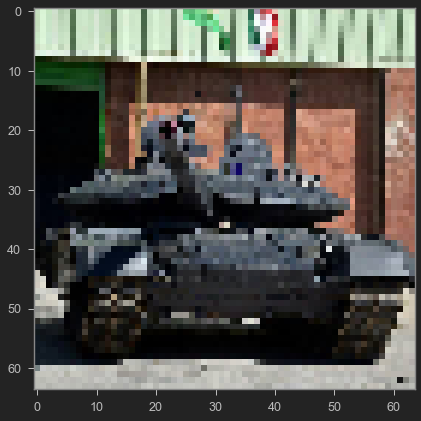

True class: Tank
Predicted probability:
Tank: 96%, Armored_tracked: 0%, Armored_wheeled: 3%, Artillery: 0% 


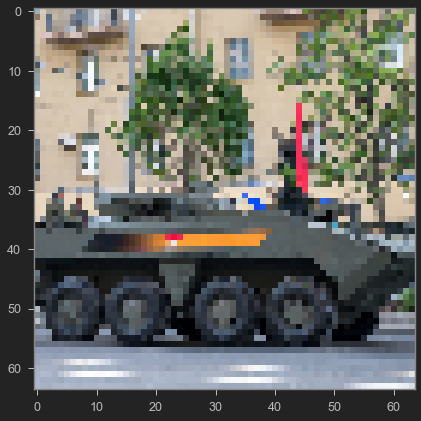

True class: Armored_wheeled
Predicted probability:
Tank: 0%, Armored_tracked: 17%, Armored_wheeled: 82%, Artillery: 0% 


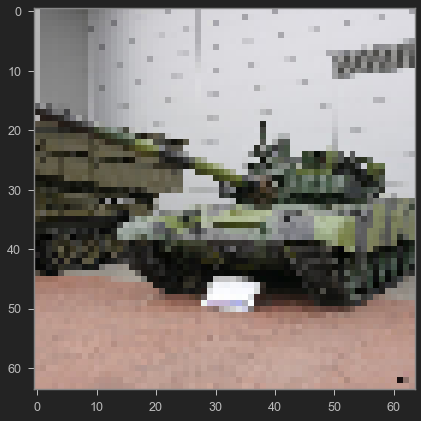

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


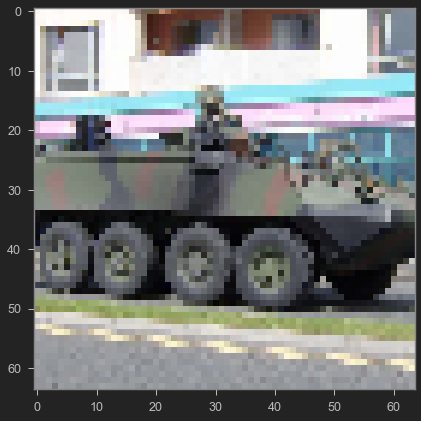

True class: Armored_wheeled
Predicted probability:
Tank: 75%, Armored_tracked: 23%, Armored_wheeled: 0%, Artillery: 0% 


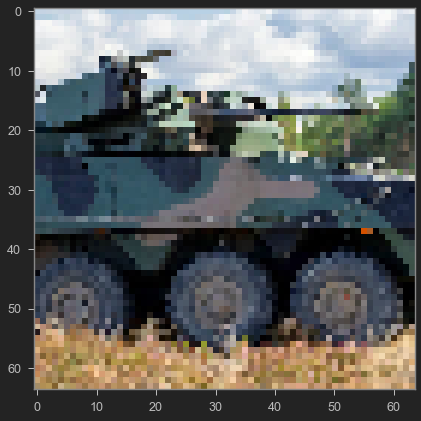

True class: Armored_wheeled
Predicted probability:
Tank: 0%, Armored_tracked: 0%, Armored_wheeled: 99%, Artillery: 0% 


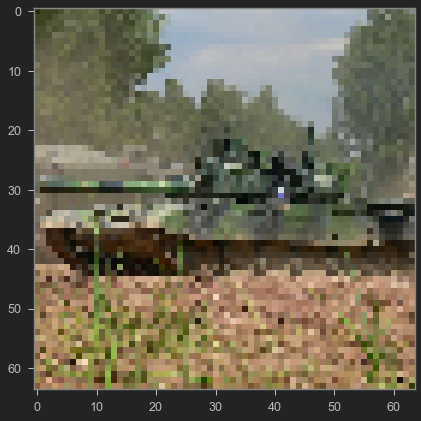

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


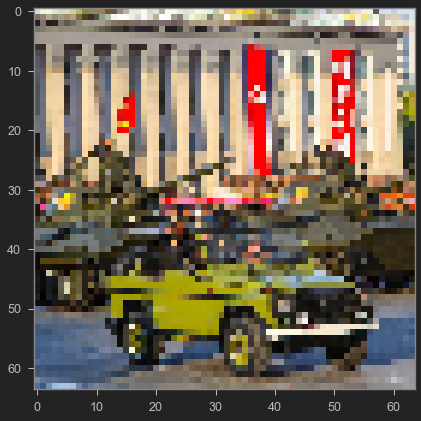

True class: Tank
Predicted probability:
Tank: 15%, Armored_tracked: 79%, Armored_wheeled: 3%, Artillery: 1% 


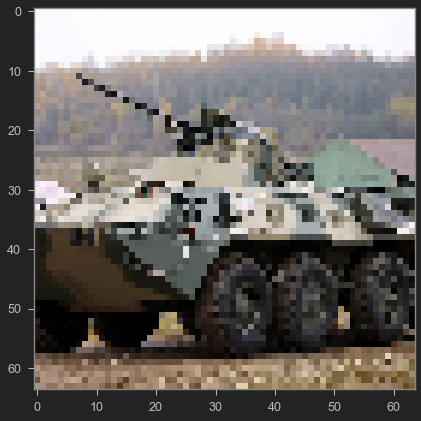

True class: Armored_wheeled
Predicted probability:
Tank: 0%, Armored_tracked: 19%, Armored_wheeled: 80%, Artillery: 0% 


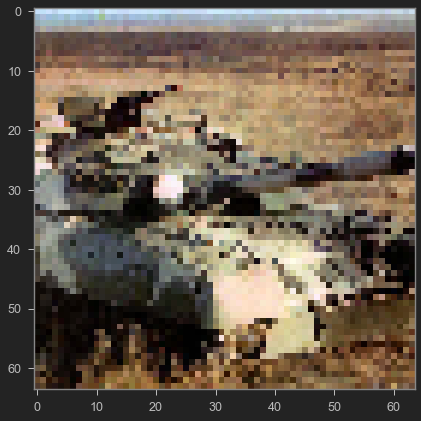

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


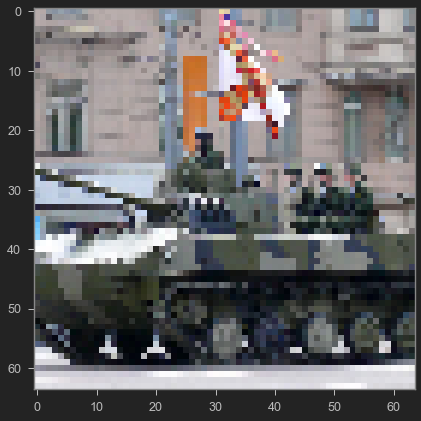

True class: Armored_tracked
Predicted probability:
Tank: 98%, Armored_tracked: 1%, Armored_wheeled: 0%, Artillery: 0% 


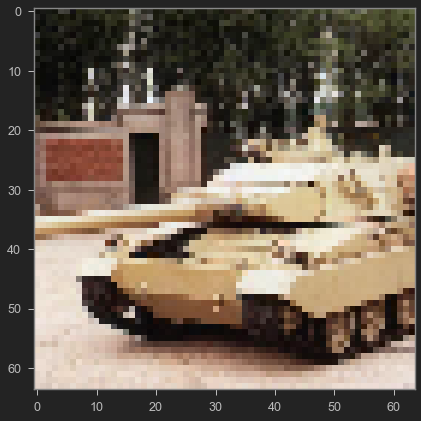

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


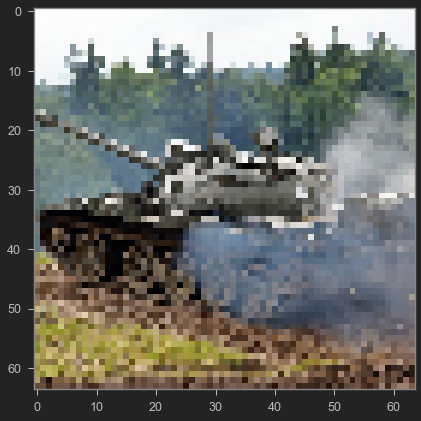

True class: Tank
Predicted probability:
Tank: 18%, Armored_tracked: 66%, Armored_wheeled: 15%, Artillery: 0% 


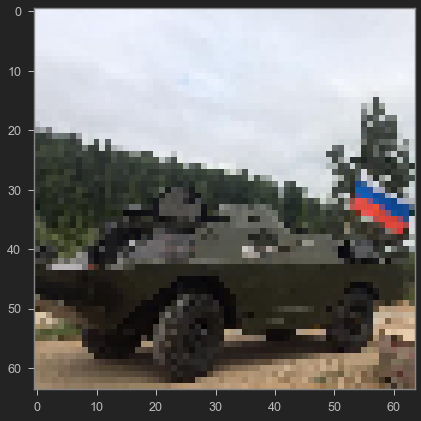

True class: Armored_wheeled
Predicted probability:
Tank: 95%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 3% 


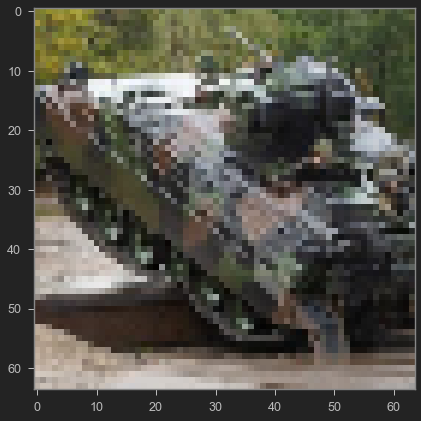

True class: Armored_tracked
Predicted probability:
Tank: 46%, Armored_tracked: 53%, Armored_wheeled: 0%, Artillery: 0% 


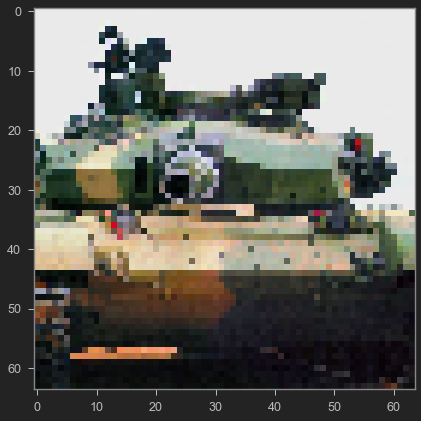

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


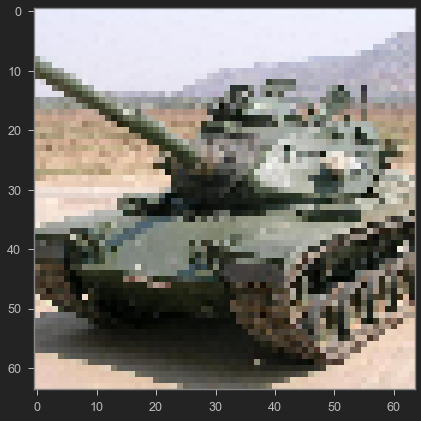

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


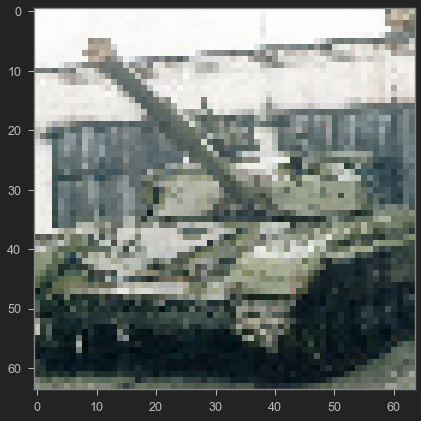

True class: Tank
Predicted probability:
Tank: 97%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 2% 


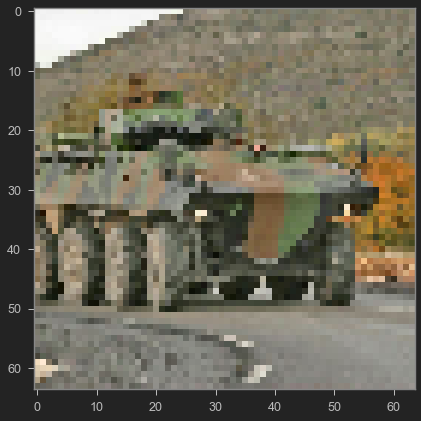

True class: Armored_wheeled
Predicted probability:
Tank: 26%, Armored_tracked: 65%, Armored_wheeled: 1%, Artillery: 6% 


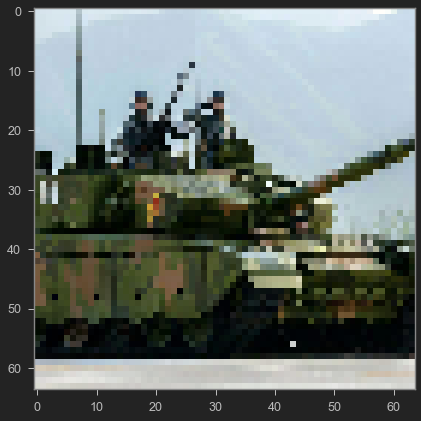

True class: Tank
Predicted probability:
Tank: 100%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


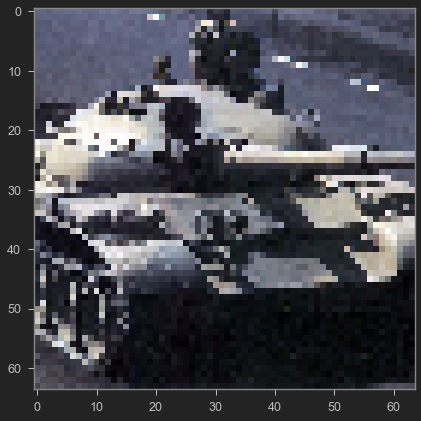

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


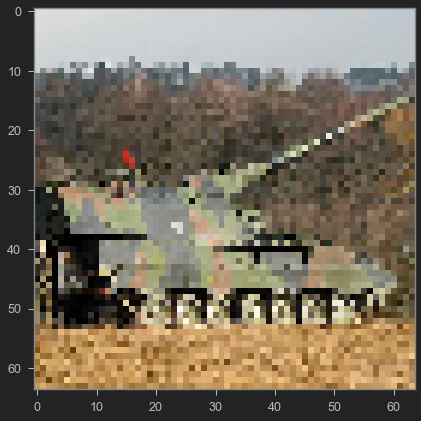

True class: Artillery
Predicted probability:
Tank: 6%, Armored_tracked: 86%, Armored_wheeled: 2%, Artillery: 5% 


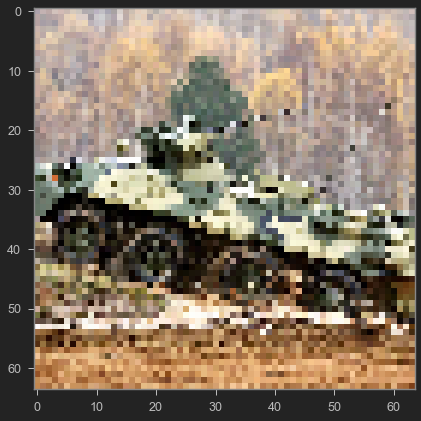

True class: Armored_wheeled
Predicted probability:
Tank: 47%, Armored_tracked: 38%, Armored_wheeled: 13%, Artillery: 0% 


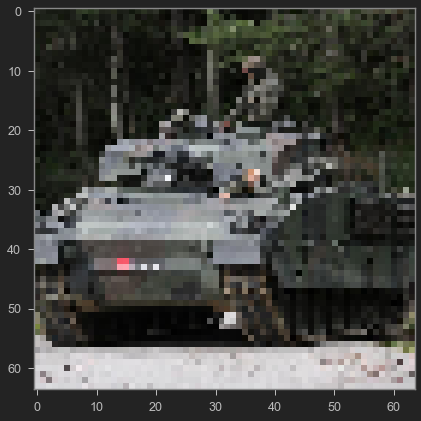

True class: Armored_tracked
Predicted probability:
Tank: 0%, Armored_tracked: 99%, Armored_wheeled: 0%, Artillery: 0% 


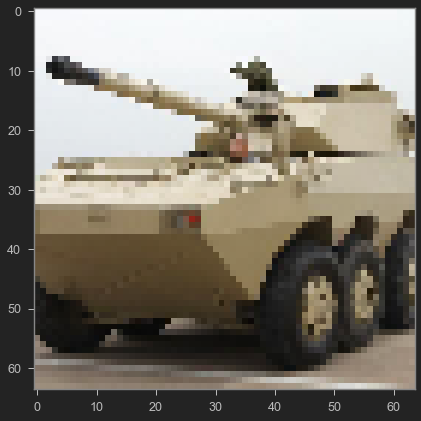

True class: Armored_wheeled
Predicted probability:
Tank: 40%, Armored_tracked: 57%, Armored_wheeled: 1%, Artillery: 0% 


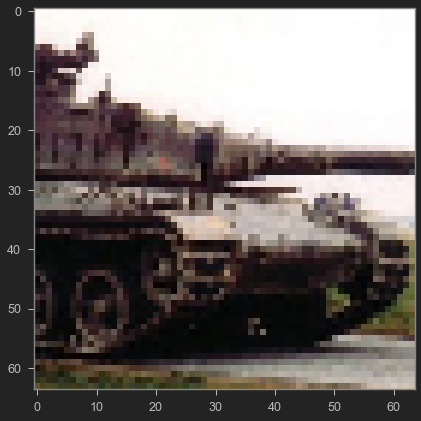

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


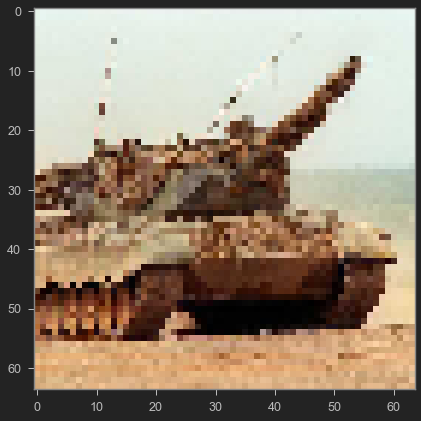

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


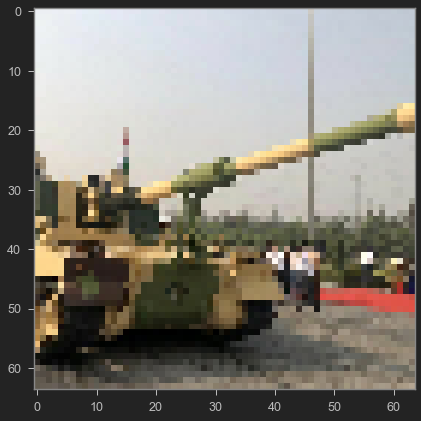

True class: Artillery
Predicted probability:
Tank: 62%, Armored_tracked: 1%, Armored_wheeled: 0%, Artillery: 36% 


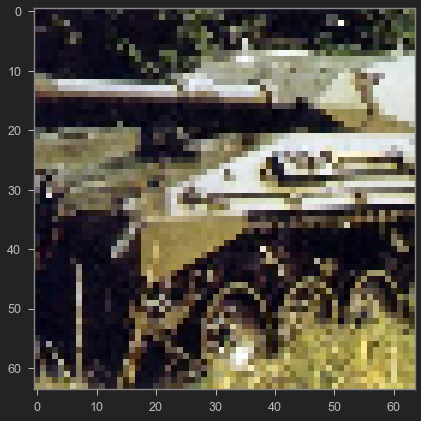

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


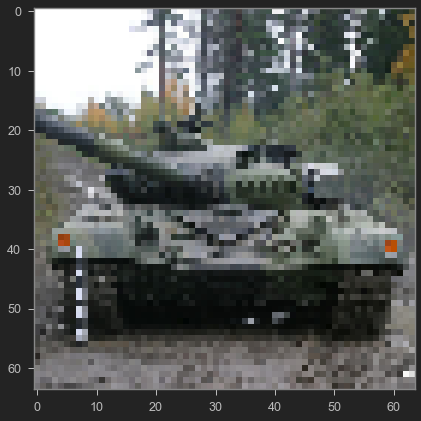

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


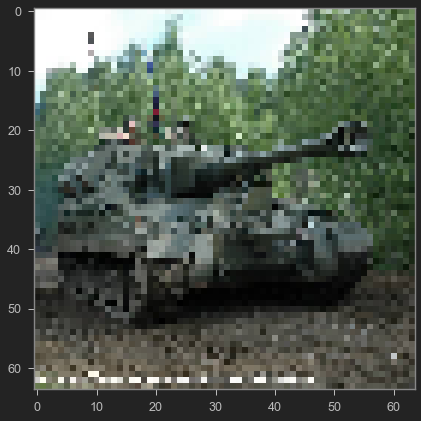

True class: Artillery
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


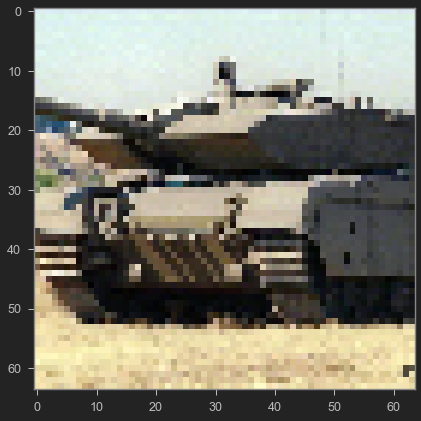

True class: Tank
Predicted probability:
Tank: 100%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


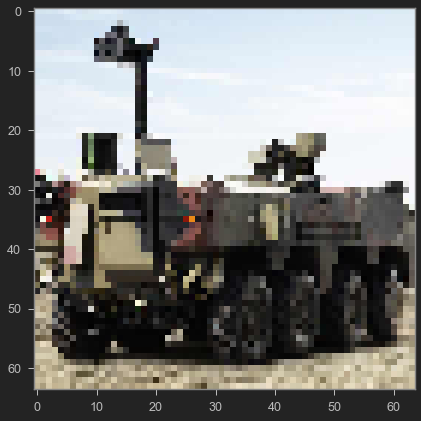

True class: Armored_wheeled
Predicted probability:
Tank: 0%, Armored_tracked: 73%, Armored_wheeled: 26%, Artillery: 0% 


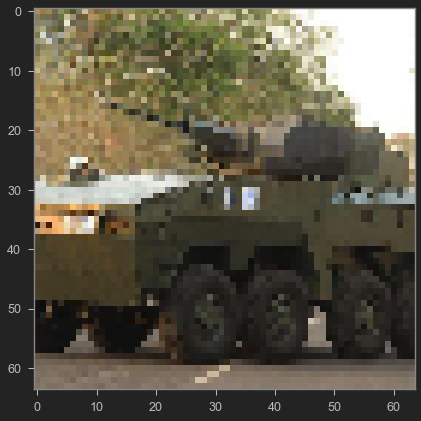

True class: Armored_wheeled
Predicted probability:
Tank: 0%, Armored_tracked: 8%, Armored_wheeled: 91%, Artillery: 0% 


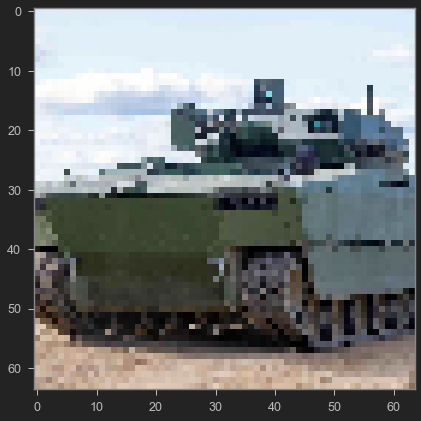

True class: Armored_tracked
Predicted probability:
Tank: 0%, Armored_tracked: 7%, Armored_wheeled: 92%, Artillery: 0% 


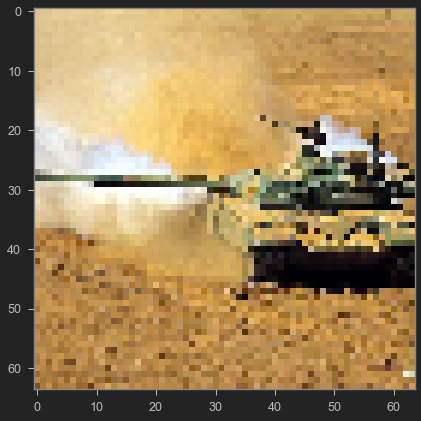

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


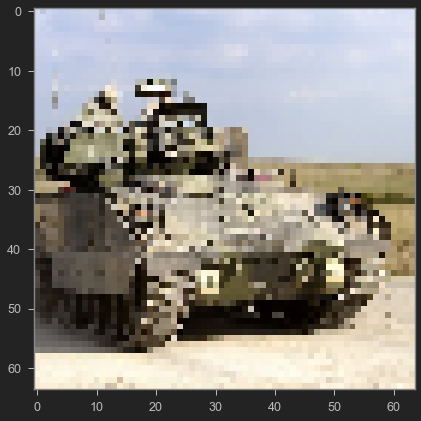

True class: Armored_tracked
Predicted probability:
Tank: 88%, Armored_tracked: 8%, Armored_wheeled: 0%, Artillery: 2% 


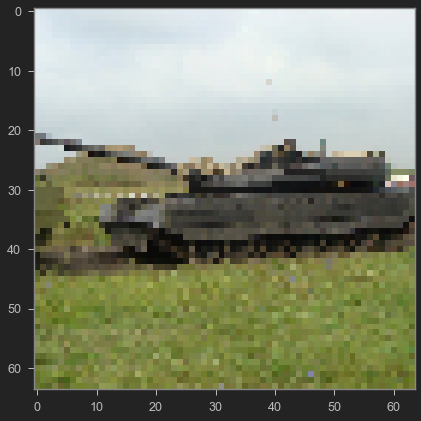

True class: Tank
Predicted probability:
Tank: 95%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 4% 


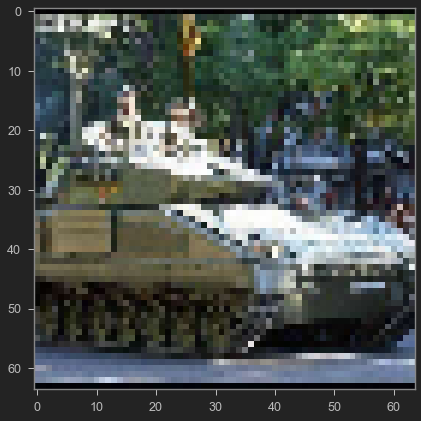

True class: Armored_tracked
Predicted probability:
Tank: 0%, Armored_tracked: 99%, Armored_wheeled: 0%, Artillery: 0% 


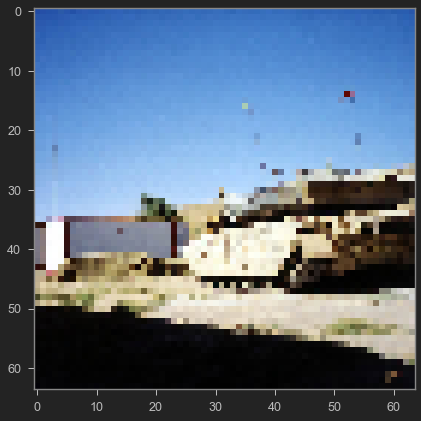

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


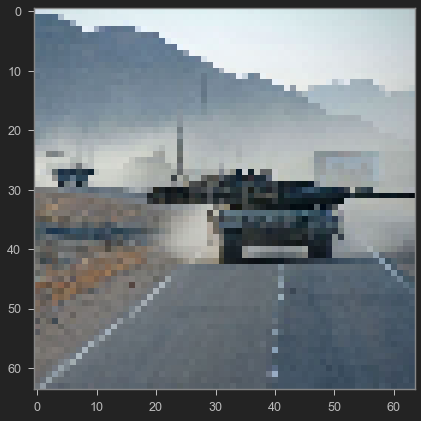

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


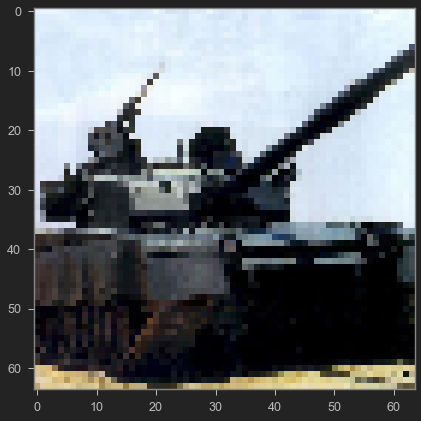

True class: Tank
Predicted probability:
Tank: 100%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


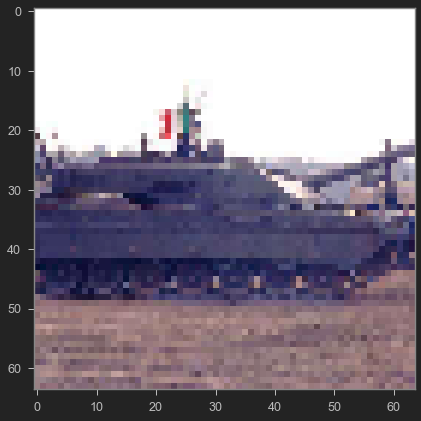

True class: Tank
Predicted probability:
Tank: 91%, Armored_tracked: 2%, Armored_wheeled: 1%, Artillery: 5% 


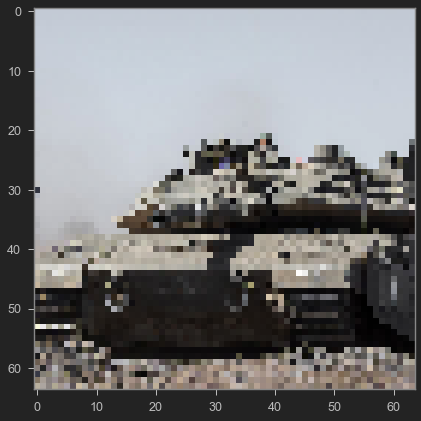

True class: Tank
Predicted probability:
Tank: 100%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


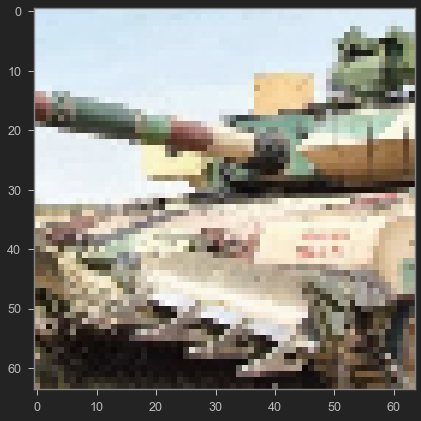

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


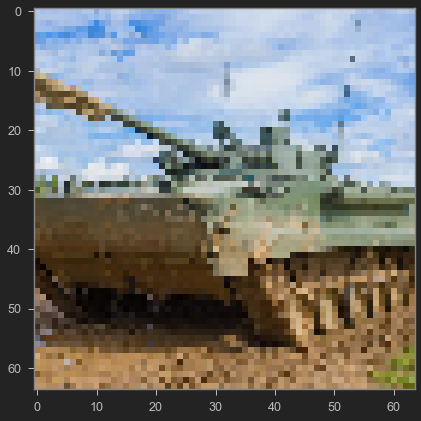

True class: Armored_tracked
Predicted probability:
Tank: 25%, Armored_tracked: 5%, Armored_wheeled: 0%, Artillery: 69% 


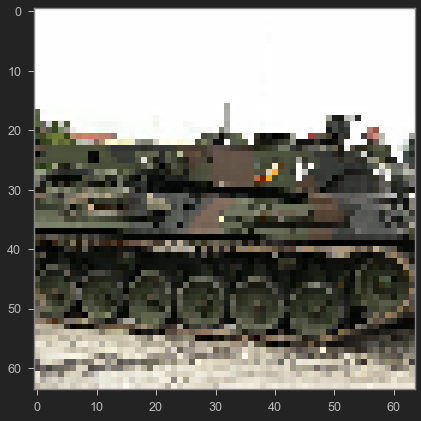

True class: Armored_tracked
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


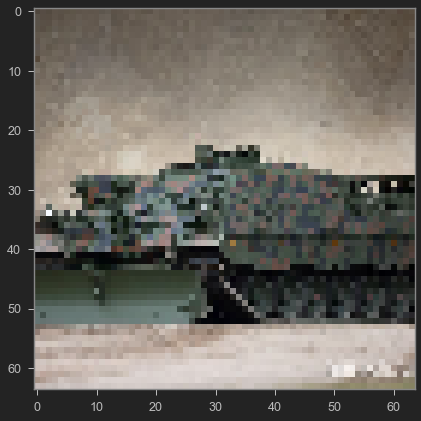

True class: Armored_tracked
Predicted probability:
Tank: 3%, Armored_tracked: 80%, Armored_wheeled: 9%, Artillery: 6% 


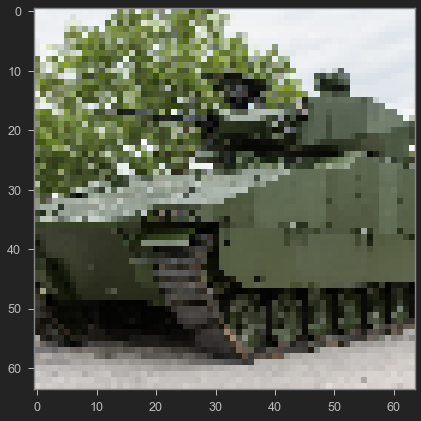

True class: Armored_tracked
Predicted probability:
Tank: 71%, Armored_tracked: 17%, Armored_wheeled: 10%, Artillery: 0% 


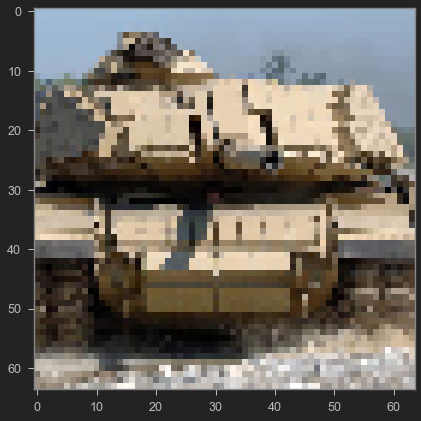

True class: Tank
Predicted probability:
Tank: 100%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


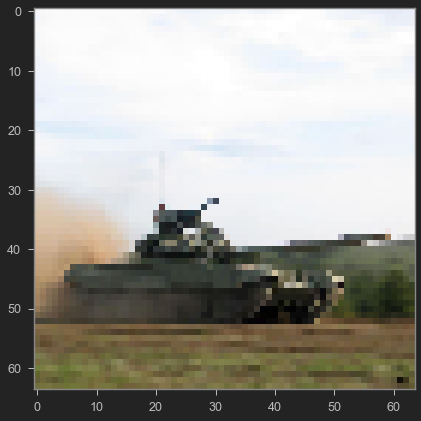

True class: Tank
Predicted probability:
Tank: 7%, Armored_tracked: 41%, Armored_wheeled: 50%, Artillery: 0% 


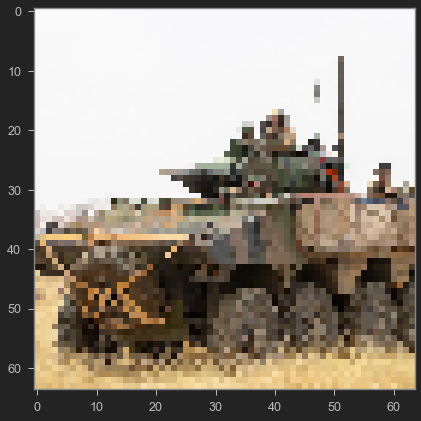

True class: Armored_wheeled
Predicted probability:
Tank: 87%, Armored_tracked: 9%, Armored_wheeled: 2%, Artillery: 0% 


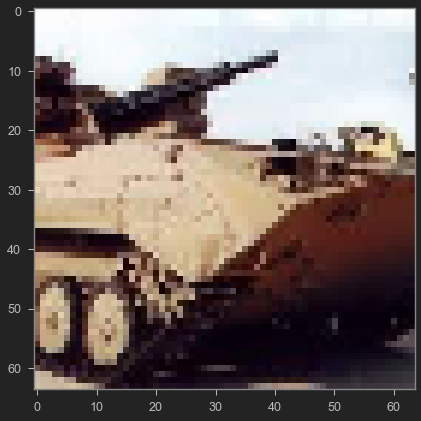

True class: Armored_tracked
Predicted probability:
Tank: 0%, Armored_tracked: 1%, Armored_wheeled: 98%, Artillery: 0% 


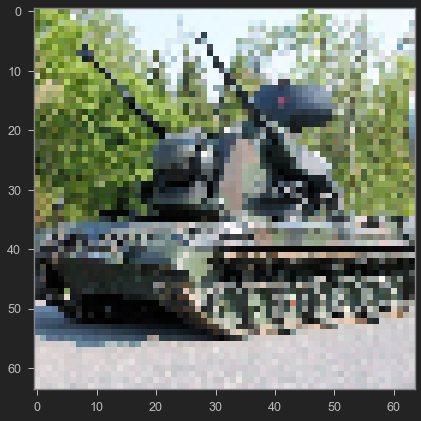

True class: Armored_tracked
Predicted probability:
Tank: 95%, Armored_tracked: 4%, Armored_wheeled: 0%, Artillery: 0% 


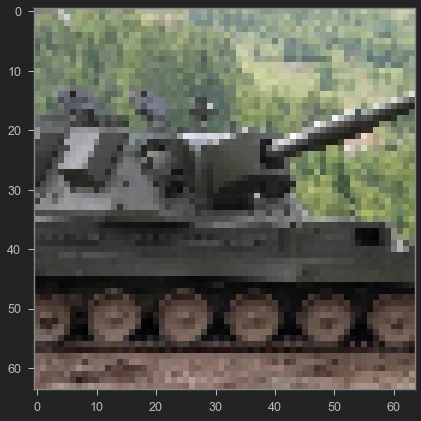

True class: Artillery
Predicted probability:
Tank: 58%, Armored_tracked: 5%, Armored_wheeled: 2%, Artillery: 34% 


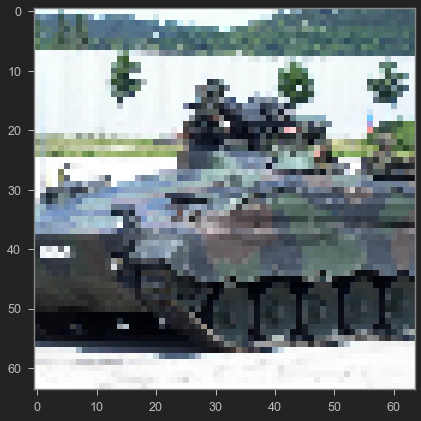

True class: Armored_tracked
Predicted probability:
Tank: 0%, Armored_tracked: 79%, Armored_wheeled: 20%, Artillery: 0% 


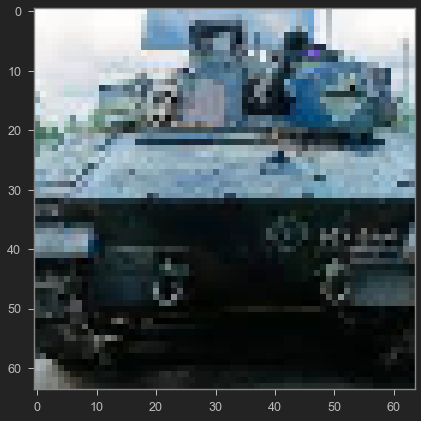

True class: Armored_tracked
Predicted probability:
Tank: 0%, Armored_tracked: 0%, Armored_wheeled: 99%, Artillery: 0% 


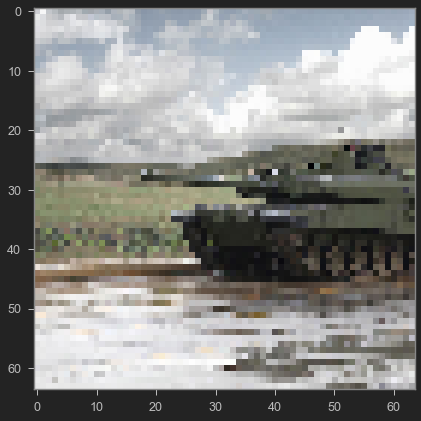

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


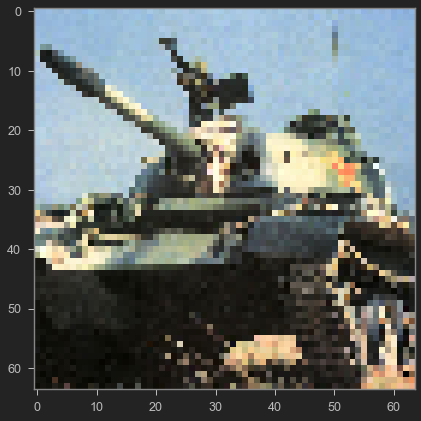

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


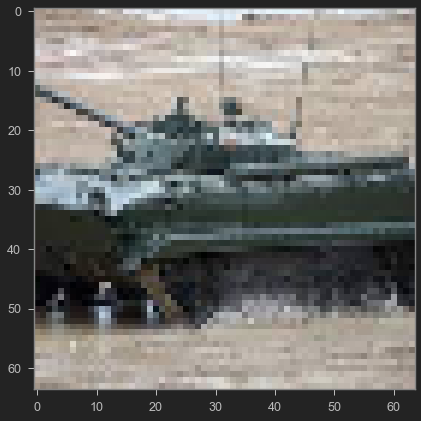

True class: Armored_tracked
Predicted probability:
Tank: 18%, Armored_tracked: 76%, Armored_wheeled: 4%, Artillery: 0% 


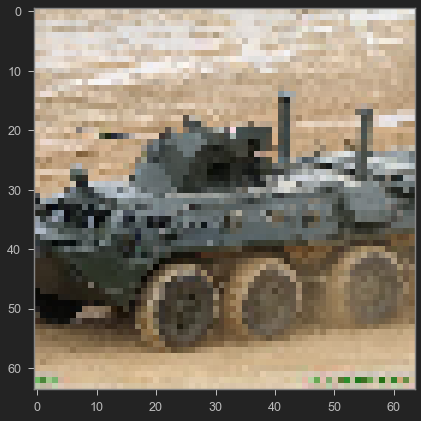

True class: Armored_wheeled
Predicted probability:
Tank: 98%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


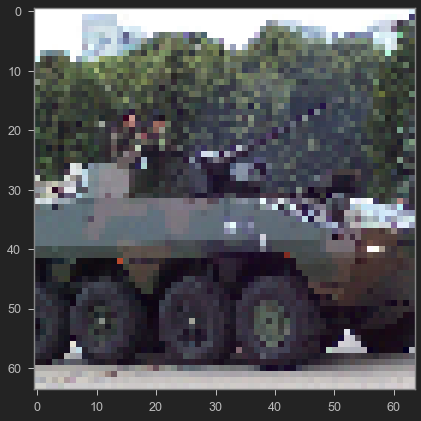

True class: Armored_wheeled
Predicted probability:
Tank: 0%, Armored_tracked: 3%, Armored_wheeled: 96%, Artillery: 0% 


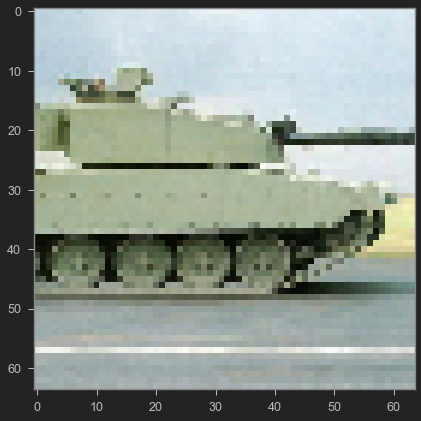

True class: Tank
Predicted probability:
Tank: 68%, Armored_tracked: 9%, Armored_wheeled: 21%, Artillery: 0% 


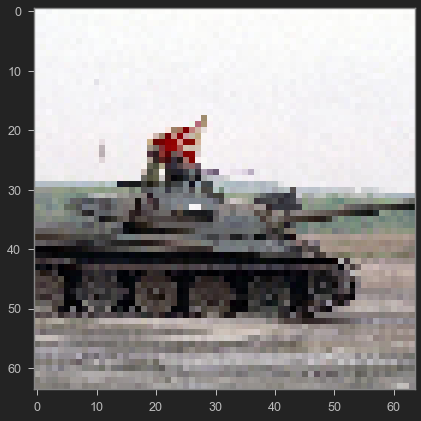

True class: Tank
Predicted probability:
Tank: 30%, Armored_tracked: 64%, Armored_wheeled: 0%, Artillery: 4% 


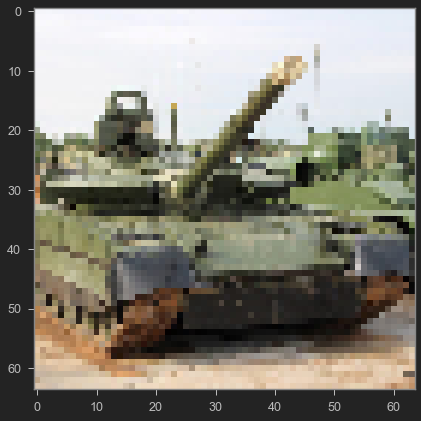

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


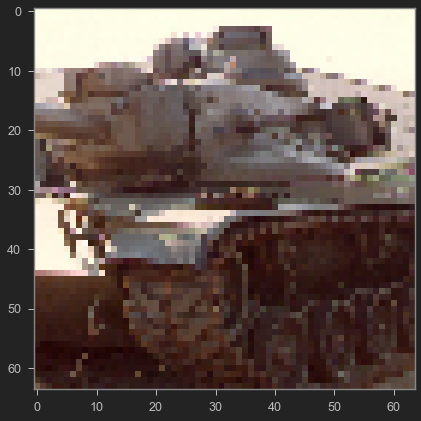

True class: Tank
Predicted probability:
Tank: 96%, Armored_tracked: 3%, Armored_wheeled: 0%, Artillery: 0% 


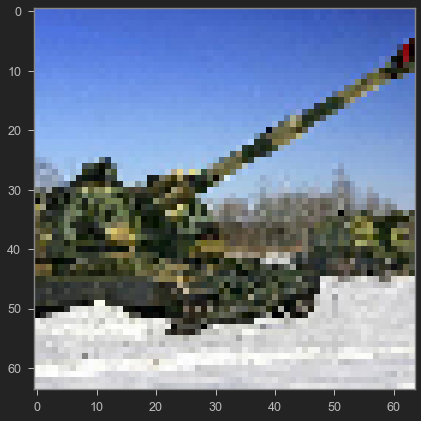

True class: Artillery
Predicted probability:
Tank: 1%, Armored_tracked: 93%, Armored_wheeled: 0%, Artillery: 4% 


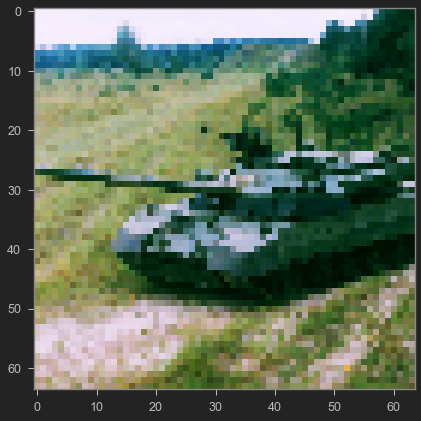

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


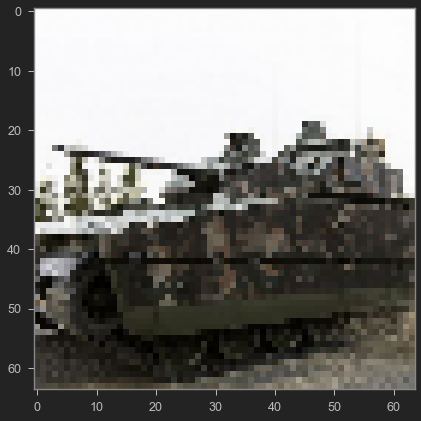

True class: Armored_tracked
Predicted probability:
Tank: 19%, Armored_tracked: 80%, Armored_wheeled: 0%, Artillery: 0% 


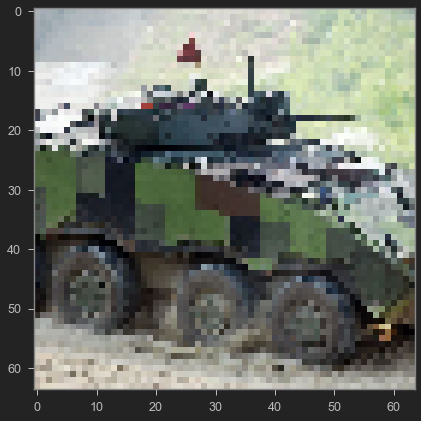

True class: Armored_wheeled
Predicted probability:
Tank: 38%, Armored_tracked: 58%, Armored_wheeled: 2%, Artillery: 0% 


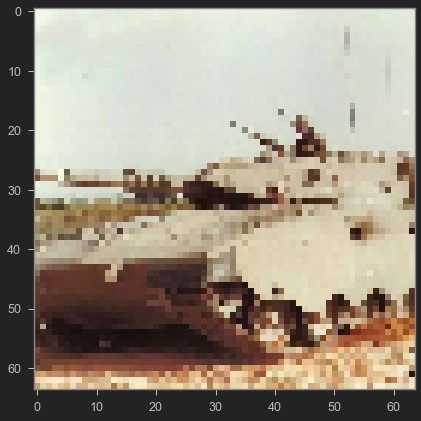

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


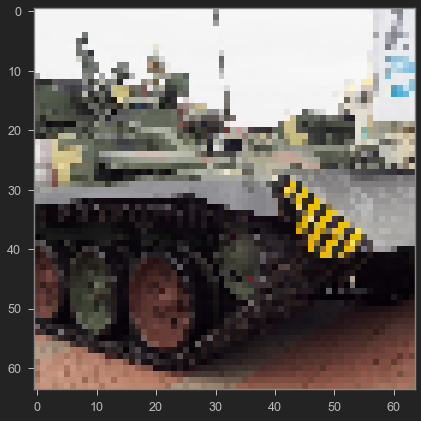

True class: Armored_tracked
Predicted probability:
Tank: 0%, Armored_tracked: 0%, Armored_wheeled: 99%, Artillery: 0% 


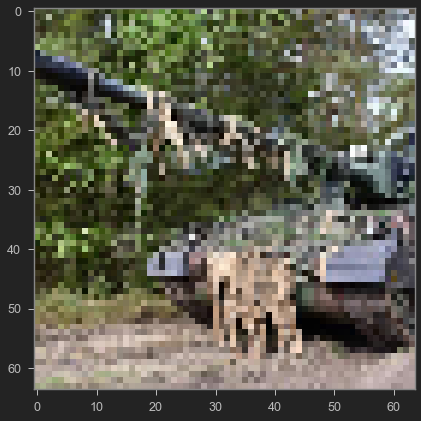

True class: Artillery
Predicted probability:
Tank: 69%, Armored_tracked: 22%, Armored_wheeled: 4%, Artillery: 2% 


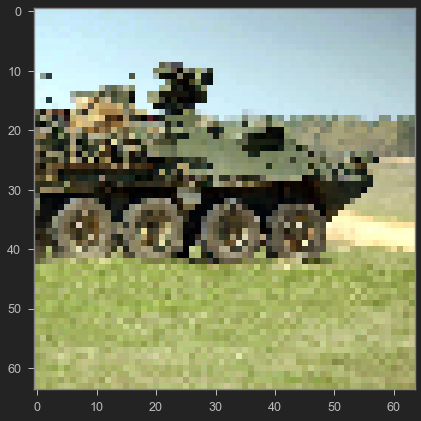

True class: Armored_wheeled
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


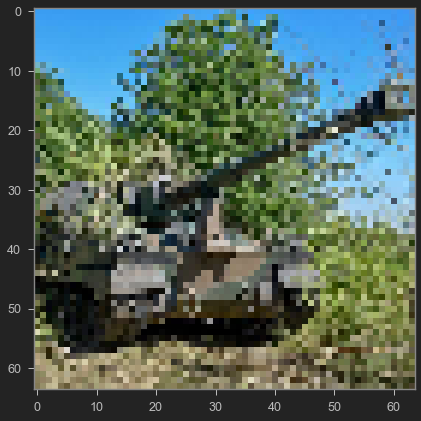

True class: Artillery
Predicted probability:
Tank: 0%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 99% 


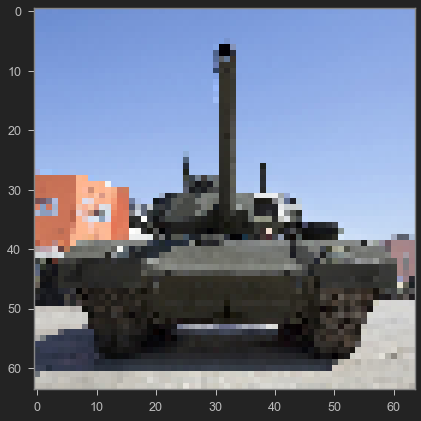

True class: Tank
Predicted probability:
Tank: 99%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


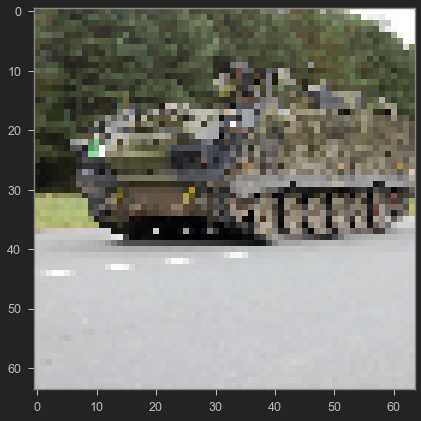

True class: Armored_tracked
Predicted probability:
Tank: 100%, Armored_tracked: 0%, Armored_wheeled: 0%, Artillery: 0% 


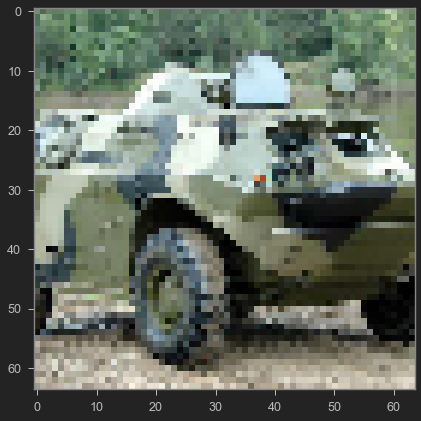

True class: Armored_wheeled
Predicted probability:
Tank: 0%, Armored_tracked: 0%, Armored_wheeled: 98%, Artillery: 0% 


In [46]:
from keras.preprocessing.image import array_to_img

for k in range(len(X_test)):
    image = array_to_img(X_test[k])
    plt.imshow(image, cmap='binary')
    plt.show()
    data = X_test[k].reshape(1, 64, 64, 3)
    y_pred = baseline_model_2.predict(data)
    print(f'True class: {vehicle_dict[y_name[k]]}')
    print('Predicted probability:')
    print(f'Tank: {round(int(y_pred.take(0)*100))}%, Armored_tracked: {int(y_pred.take(1)*100)}%, Armored_wheeled: {int(y_pred.take(2)*100)}%, Artillery: {int(y_pred.take(3)*100)}% ')